# Hotel Ranking 

In this task, we ask you to train a model that learns to `rank properties`.

Hotels.com travellers provide their trip information, like destination, holiday dates and number of people in the search. Our search engine then returns a list of properties, `ranked by their relevance to that traveller`.

We provide you a data set with this travel information augmented by some features we have found to be predictive, including search-level features like booking window (length of time between booking the trip and taking it), and property-level features, like the country the property is in.

Please feel free to model with all, some or none of these, or create your own features.
The label in this data set is `booking_bool`, indicating whether this property was the one that was booked by the customer.
Please provide justification for your metric for this ranking task.

In the leader board, you’ll see the popularity benchmark. This is a useful baseline. It’s the score you’d achieve on the test set if you simply ranked the properties in each search by the number of times it was booked in the training set.
Happy modelling, and good luck!

In [1]:
# import libraries
import shap
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GroupShuffleSplit
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore some warning 

## Import data and overview

In [2]:
train = pd.read_csv('train.csv')  # input train data and test data
test = pd.read_csv('test.csv')

In [3]:
train.head() # have a overview of train data

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,...,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,257690,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,575,4.1,403.0,0,2014-09-13
1,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
2,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13
3,-1046322713,3308025,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98278,272,4.8,221.0,0,2014-09-13
4,-1046322713,3222046,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,198,3.9,702.0,0,2014-09-13


In [4]:
y = train['prop_booking_bool']  # get the labels of data 
train_data = train.drop(['prop_booking_bool'],axis=1) # get the training dataset without label

## Exploratory Data Analysis (EDA)    
1. Analyse the number of searches in train and test dataset and display the distribution for number of hotels in each search
2. Analyse the type of columns 
3. Analyse the missing values 
4. Dataset summary

### 1. Number of searches

In [5]:
train_group = train_data.groupby(by=['srch_id']).count()
print('there are totally '+str(len(train_group))+' searches in training data')
test_group = test.groupby(by=['srch_id']).count()
print('there are totally '+str(len(test_group))+' searches in test data')

there are totally 24013 searches in training data
there are totally 10064 searches in test data


In [6]:
max(train_group['srch_date_time'])

54

#### Distribution of number of hotels displayed in each search
The number of hotels in each search varies from 1 to 54, the searches with 10 and 50 hotels account for the majority.

<AxesSubplot:xlabel='srch_date_time', ylabel='Count'>

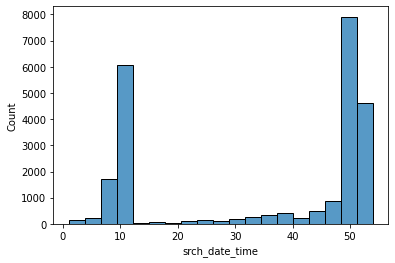

In [7]:
sns.histplot(train_group['srch_date_time'])   ## display the freq of number of hotels in each search

<AxesSubplot:xlabel='srch_date_time', ylabel='Count'>

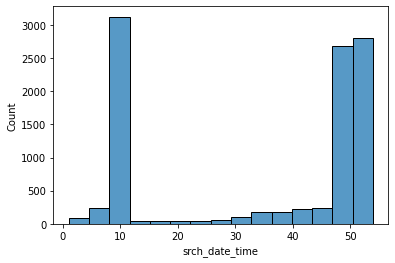

In [8]:
sns.histplot(test_group['srch_date_time'])

### 2. Check the column type

In [9]:
col_types = {}
Dtypes = train_data.dtypes
for col_name in Dtypes.index:
    tmp = col_types.get(Dtypes[col_name],[])
    tmp.append(col_name)
    col_types[Dtypes[col_name]] = tmp

In [10]:
for Type in col_types:
    print('There are '+str(len(col_types[Type]))+ ' columns with type '+ str(Type))
    print(col_types[Type],'\n')

There are 19 columns with type int64
['srch_id', 'prop_key', 'srch_visitor_visit_nbr', 'srch_hcom_destination_id', 'srch_ci_day', 'srch_co_day', 'srch_los', 'srch_bw', 'srch_rm_cnt', 'srch_mobile_bool', 'srch_mobile_app', 'prop_travelad_bool', 'prop_dotd_bool', 'prop_imp_drr', 'prop_brand_bool', 'prop_market_id', 'prop_submarket_id', 'prop_room_capacity', 'prop_hostel_bool'] 

There are 16 columns with type object
['srch_date_time', 'srch_visitor_id', 'srch_visitor_loc_country', 'srch_visitor_loc_region', 'srch_visitor_loc_city', 'srch_visitor_wr_member', 'srch_posa_continent', 'srch_posa_country', 'srch_ci', 'srch_co', 'srch_device', 'srch_currency', 'prop_super_region', 'prop_continent', 'prop_country', 'srch_local_date'] 

There are 11 columns with type float64
['srch_dest_longitude', 'srch_dest_latitude', 'srch_adults_cnt', 'srch_children_cnt', 'prop_price_without_discount_local', 'prop_price_without_discount_usd', 'prop_price_with_discount_local', 'prop_price_with_discount_usd', '

### Missing value analysis

<AxesSubplot:>

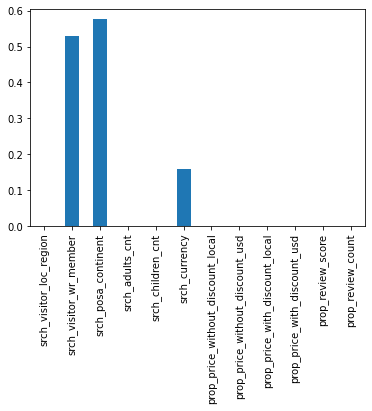

In [11]:
missing = train_data.isnull().sum()/len(train_data)
missing = missing[missing>0]
missing.plot.bar()

<AxesSubplot:>

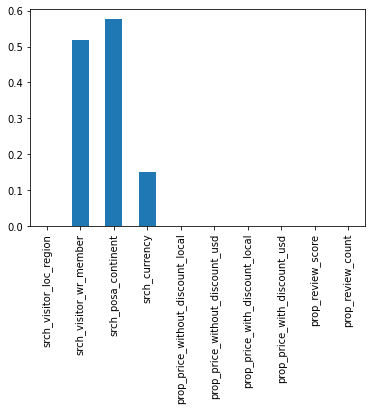

In [12]:
missing_test = test.isnull().sum()/len(test)
missing_test = missing_test[missing_test>0]
missing_test.plot.bar()

In [13]:
missing.index  # print the columns that contains null value

Index(['srch_visitor_loc_region', 'srch_visitor_wr_member',
       'srch_posa_continent', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_currency', 'prop_price_without_discount_local',
       'prop_price_without_discount_usd', 'prop_price_with_discount_local',
       'prop_price_with_discount_usd', 'prop_review_score',
       'prop_review_count'],
      dtype='object')

There are 12 columns missing values and most of them have very few missing values. However, `srch_visitor_wr_member` and `srch_posa_continent` miss more than 50% of values and `srch_currency` miss around 17% of values.

### Dataset Summary

In [14]:
train_data.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,...,prop_price_with_discount_usd,prop_imp_drr,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,8.411150e+05,8.411150e+05,841115.000000,8.411150e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,...,8.410640e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841107.000000,841107.000000,841115.000000
mean,1.724233e+07,8.185569e+05,12.325977,1.194309e+06,-45.892803,40.445932,4.272102,3.689650,2.677238,35.349157,...,3.044565e+02,0.425998,0.664118,3.595627,71586.980101,106494.270656,631.116457,4.024048,2160.753578,0.002888
std,1.231757e+09,1.141255e+06,31.788936,4.237267e+05,77.706051,6.056537,2.003199,2.128168,2.192103,49.506785,...,4.205190e+03,0.494494,0.472298,0.864574,39165.985756,7384.185494,1573.071335,0.547170,3075.169206,0.053661
min,-2.147275e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,-1.034005e+09,2.559520e+05,1.000000,7.267840e+05,-115.172875,36.114666,3.000000,2.000000,1.000000,4.000000,...,9.902000e+01,0.000000,0.000000,3.000000,60039.000000,98238.000000,144.000000,3.800000,306.000000,0.000000
50%,3.193952e+07,2.777420e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,...,1.890000e+02,0.000000,1.000000,4.000000,95602.000000,109153.000000,306.000000,4.100000,937.000000,0.000000
75%,1.081646e+09,4.781330e+05,10.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,...,2.990000e+02,1.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2550.000000,0.000000
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,...,1.087117e+06,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


`prop_room_capacity` contains negative values, which are invalid, need to be investigate.

## Data Preprocessing   
1. Deal with Nan value in the datasets
2. Process the date columns 
3. Deal with invalid value and drop some columns
4. Encode the categorical columns

In [15]:
# concate train data and test data to do data preprocessing together
features = pd.concat([train_data, test]).reset_index(drop=True) 

### Deal with NAN value 

#### 1. Fill nan value with mode    
For `srch_visitor_loc_region`, `srch_adults_cnt`, `srch_children_cnt`,`prop_price_without_discount_local`, `prop_price_without_discount_usd`, `prop_price_with_discount_local`, `prop_price_with_discount_usd`, `prop_review_score`,`prop_review_count`, we will fill nan value with mode, since they only contain a small number of NAN value

In [16]:
def filll_nan_mode(data,cols):
    for col in cols:
        data[col] = data[col].fillna(data[col].mode()[0])
    return data

In [17]:
excluded_cols = ['srch_visitor_wr_member', 'srch_posa_continent', 'srch_currency']
included_cols = [col for col in missing.index if col not in excluded_cols]
features = filll_nan_mode(features,included_cols)

#### 2. Drop column `srch_visitor_wr_member` 
The column `srch_visitor_wr_member` contains more than 50% of nan values and the according to the content, it is not a very important column. 

In [18]:
features['srch_visitor_wr_member'].value_counts()/len(features)   

Not Signed In|Returning Visitor|Not FC Member                0.223070
Not Signed In|New Visitor|Not FC Member                      0.107859
Signed In|WR Member|Not FC Member                            0.078277
Signed in - Persistent|WR Member|Not FC Member               0.058583
Signed in - Persistent|WR Member|Remembered FC Member        0.004071
Signed In|WR Member|FC Member                                0.001181
Signed In|Not WR Member|Not FC Member                        0.000741
Signed in - Persistent|Not WR Member|Not FC Member           0.000508
Signed in - Persistent|Not WR Member|Remembered FC Member    0.000124
Name: srch_visitor_wr_member, dtype: float64

In [19]:
features.drop(['srch_visitor_wr_member'],axis=1,inplace=True)

#### 3. Fill nan with `NORTHAMERICA`  in  column `srch_posa_continent` 
According to the analysis, the samples with nan value in the `srch_posa_continent` column contains values 'US' and 'Canada' in the `srch_posa_country` (point of sale country for a particular search), so we fill the `srch_posa_continent` with 'NORTHAMERICA'

In [20]:
features['srch_posa_continent'].value_counts()/len(features)   

EUROPE     0.248115
ASIA       0.130460
LATAM      0.037770
OCEANIA    0.006794
Name: srch_posa_continent, dtype: float64

In [21]:
# Display the srch_posa_country value in each srch_posa_continent
for region in features['srch_posa_continent'].value_counts().index:
    tmp = features[features['srch_posa_continent']==region]
    print(region)
    print(tmp['srch_posa_country'].value_counts(),'\n')

EUROPE
UNITED KINGDOM            72516
SWEDEN                    45641
FRANCE                    43591
NORWAY                    31966
EMEA                      27259
DENMARK                   19371
GERMANY                    9813
SWITZERLAND                8646
FINLAND                    7420
RUSSIA                     5390
SPAIN & CANARY ISLANDS     5240
IRELAND                    4494
ITALY                      4006
NETHERLANDS                3120
BELGIUM                    2165
SOUTH AFRICA               1670
AUSTRIA                    1025
POLAND                      812
ICELAND                     447
PORTUGAL                    347
GREECE                      284
CZECH                       191
HUNGARY                     183
ESTONIA                     134
CROATIA                      90
SLOVAKIA                     45
LATVIA                       43
LITHUANIA                     7
Name: srch_posa_country, dtype: int64 

ASIA
SOUTH KOREA                  32662
JAPAN            

In [22]:
# Display the srch_posa_country value for the samples without srch_posa_continent
tmp = features[features['srch_posa_continent'].isnull()]
tmp['srch_posa_country'].value_counts()

US        657191
CANADA     30808
Name: srch_posa_country, dtype: int64

In [23]:
features['srch_posa_continent'] = features['srch_posa_continent'].fillna('NORTHAMERICA') 

#### 4. Column `srch_currency`   
According to the definition of `srch_currency` (currency relevant for the point of sale the search was submitted form), we assume there is a relationship between `srch_currency` and `srch_posa_country` (point of sale country for a particular search).    
According to the following anlaysis, we discovered that the the mode of `srch_currency` for each `srch_posa_country` is most likely to be the offcial currency of `srch_posa_country`. So that we can fill the nan value in `srch_currency` with the mode of `srch_currency` with respect to `srch_posa_country`.

In [24]:
country_currency = features.groupby(['srch_posa_country'])['srch_currency'].agg(pd.Series.mode)

In [25]:
# Show the `srch_posa_country` of samples without `srch_currency`
tmp = features[features['srch_currency'].isnull()]
tmp['srch_posa_country'].value_counts()

US                           109203
UNITED KINGDOM                11837
FRANCE                         7123
JAPAN                          5613
SOUTH KOREA                    5241
SWEDEN                         5030
CANADA                         4802
NORWAY                         4782
EMEA                           3734
BRAZIL                         3384
TAIWAN, REPUBLIC OF CHINA      3108
HONG KONG                      2910
DENMARK                        2487
ASIA                           2226
MEXICO                         1682
CHINA                          1616
SWITZERLAND                    1546
AUSTRALIA                      1465
GERMANY                        1362
IRELAND                         836
FINLAND                         816
SINGAPORE                       771
SPAIN & CANARY ISLANDS          729
INDIA                           665
ITALY                           425
COLOMBIA                        300
ISRAEL                          269
RUSSIA                      

In [26]:
dict(country_currency)

{'ARABIC': 'USD',
 'ARGENTINA': 'ARS',
 'ASIA': 'USD',
 'AUSTRALIA': 'AUD',
 'AUSTRIA': 'EUR',
 'BELGIUM': 'EUR',
 'BOLIVIA': 'BOB',
 'BRAZIL': 'BRL',
 'CANADA': 'CAD',
 'CHILE': 'CLP',
 'CHINA': 'CNY',
 'COLOMBIA': 'COP',
 'COSTA RICA': 'CRC',
 'CROATIA': 'USD',
 'CZECH': 'CZK',
 'DENMARK': 'DKK',
 'ECUADOR': 'USD',
 'EL SALVADOR': 'USD',
 'EMEA': 'USD',
 'ESTONIA': 'EUR',
 'FINLAND': 'EUR',
 'FRANCE': 'EUR',
 'FRENCH GUIANA': 'USD',
 'GERMANY': 'EUR',
 'GREECE': 'EUR',
 'GUATEMALA': 'GTQ',
 'HONDURAS': 'HNL',
 'HONG KONG': 'HKD',
 'HUNGARY': 'HUF',
 'ICELAND': 'ISK',
 'INDIA': 'INR',
 'INDONESIA': 'USD',
 'IRELAND': 'EUR',
 'ISRAEL': 'ILS',
 'ISRAEL HEBREW': 'ILS',
 'ITALY': 'EUR',
 'JAPAN': 'JPY',
 'LATVIA': 'EUR',
 'LITHUANIA': 'LTL',
 'MALAYSIA': 'MYR',
 'MEXICO': 'MXN',
 'NETHERLANDS': 'EUR',
 'NEW ZEALAND': 'NZD',
 'NICARAGUA': 'USD',
 'NORWAY': 'NOK',
 'PANAMA': 'PAB',
 'PARAGUAY': 'USD',
 'PERU': 'PEN',
 'PHILIPPINES': 'PHP',
 'POLAND': 'PLN',
 'PORTUGAL': 'EUR',
 'RUSSIA': 'R

In [27]:
features['srch_currency'] = features['srch_currency'].fillna(features['srch_posa_country'].map(dict(country_currency)))

###  Process the date columns
1. Further analysis shows that the `srch_local_date` and `srch_date_time` have high correlation, so that we drop `srch_local_date`
2. In the dataset, `srch_local_date`, `srch_ci`, `srch_co`, `srch_date_time` are date columns, we need to transfer them to year, month and day

In [28]:
t = features[['srch_date_time','srch_local_date']]
t['srch_date_time'] =pd.to_datetime(t['srch_local_date']).dt.strftime("%Y-%m-%d")
t['srch_local_date'] =  pd.to_datetime(t['srch_local_date'])
t['is_same'] = t['srch_date_time']==t['srch_local_date']
t['is_same'].value_counts()

True    1192659
Name: is_same, dtype: int64

In [29]:
def dateTransfer(df,col):
    '''
    Split date-like column to 3 columns which contain Year, Month and Day information.
    
    Parameters
    ----------
    df: dataframe, contain `col` feature 
    col: string, the column name of the column that need to be preocessed
    
    Return
    ----------
    df: dataframe
    '''
    
    df[col] = pd.to_datetime(df[col]) # convert string to datetime type 
    df[col+'_Year'] = pd.DatetimeIndex(df[col]).year # obtain year info
    df[col+'_Month'] = pd.DatetimeIndex(df[col]).month # obtain month info
    df[col+'_Day'] = pd.DatetimeIndex(df[col]).day # obtain day info 
    df.drop(col,inplace=True,axis=1) # drop the original date-like column
    return df

In [30]:
features = dateTransfer(features,'srch_date_time')
features = dateTransfer(features,'srch_co')
features = dateTransfer(features,'srch_ci')

### Deal with invalid value and drop some columns

In [31]:
features.loc[features.prop_room_capacity < 0, 'prop_room_capacity'] = 0  # replace negative value as zero 
features.loc[features.srch_posa_country =='UNKNOWN', 'srch_posa_country'] = features['srch_posa_country'].mode()[0] # replace unknown as mode
features.loc[features.srch_visitor_loc_city =='?', 'srch_visitor_loc_city'] = features['srch_visitor_loc_city'].mode()[0] # replace ? as mode

In [32]:
features.drop('srch_local_date',inplace=True,axis=1) # contain same info as srch_date_time
features.drop('srch_visitor_id', inplace=True,axis=1) # id info can delete
features.drop('prop_price_without_discount_local', inplace=True,axis=1) # already have prop_price_without_discount_local_usd
features.drop('prop_price_with_discount_local', inplace=True,axis=1) # already have prop_price_with_discount_local_usd
features.drop('srch_mobile_bool', inplace=True,axis=1) # only contain one value

### Encode the categorical col     
 Label Encoding

In [33]:
features.describe(exclude=[np.number])

,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_posa_continent,srch_posa_country,srch_device,srch_currency,prop_super_region,prop_continent,prop_country
count,1192659,1192659,1192659,1192659,1192659,1192659,1192659,1192659,1192659,1192659
unique,162,630,6110,5,68,3,52,4,4,8
top,UNITED STATES OF AMERICA,CA,NEW YORK,NORTHAMERICA,US,DESKTOP,USD,AMER,NORTHAMERICA,UNITED STATES OF AMERICA
freq,657047,165470,29817,687999,657359,1018719,702463,787648,787648,787648


In [34]:
def labelEncoding(df,col):
    '''
    Split date-like column to 3 columns which contain Year, Month and Day information.
    
    Parameters
    ----------
    df: dataframe, contain `col` feature 
    col: string, the column name of the column that need to be preocessed
    
    Return
    ----------
    col_cat: mapping between category number with original value
    df: dataframe
    '''
    df[col] = df[col].astype('category')
    col_cat = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes
    return col_cat, df

In [35]:
srch_visitor_loc_city_cat, features = labelEncoding(features,'srch_visitor_loc_city')
srch_visitor_loc_country_cat, features = labelEncoding(features,'srch_visitor_loc_country')
srch_posa_continent_cat, features =  labelEncoding(features,'srch_posa_continent')
srch_posa_country_cat, features = labelEncoding(features,'srch_posa_country')
srch_device_cat, features = labelEncoding(features,'srch_device')
srch_currency_cat,features = labelEncoding(features,'srch_currency')
prop_super_region_cat,features = labelEncoding(features,'prop_super_region')
prop_country_cat, features = labelEncoding(features,'prop_country')
prop_continent_cat,features = labelEncoding(features,'prop_continent')
srch_visitor_loc_region_cat,features = labelEncoding(features,'srch_visitor_loc_region')

# Data Visualization

In [36]:
train_clean = features.loc[:len(train)-1,:]
train_clean['label'] = y

<AxesSubplot:xlabel='srch_ci_Day', ylabel='count'>

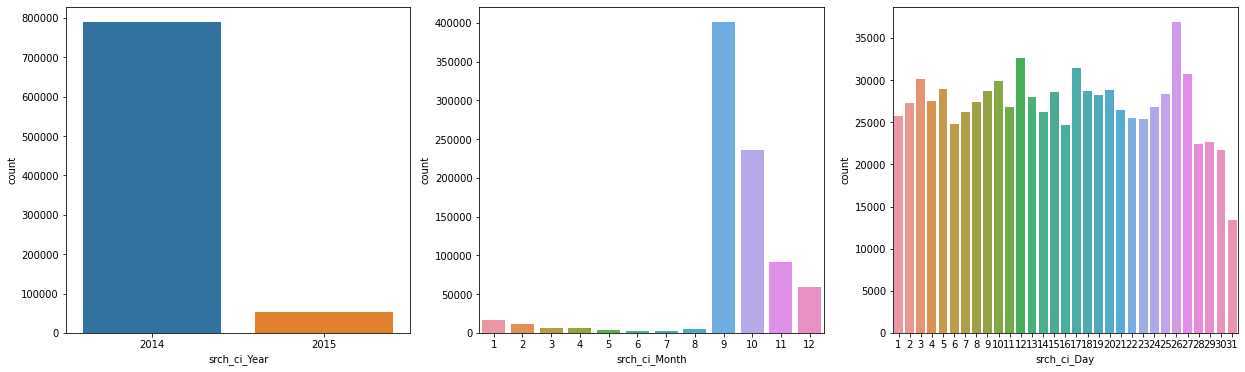

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(21,6))
sns.countplot('srch_ci_Year',data=train_clean.sort_values(by=['srch_ci_Year']),ax=ax[0])
sns.countplot('srch_ci_Month',data=train_clean.sort_values(by=['srch_ci_Month']),ax=ax[1])
sns.countplot('srch_ci_Day',data=train_clean.sort_values(by=['srch_ci_Day']),ax=ax[2])

Train dataset contains data of clients who checked in most in 2014 and some in 2015,  and according to the checkin month chart we discovered that Sep, Oct, Nov and Dec contain more samples, from which we might draw a conclusion that people are more like to go travel in these months

{0: 'FRANCE', 1: 'ITALY', 2: 'JAPAN', 3: 'MARTINIQUE', 4: 'SOUTH KOREA', 5: 'SWITZERLAND', 6: 'UNITED KINGDOM', 7: 'UNITED STATES OF AMERICA'}


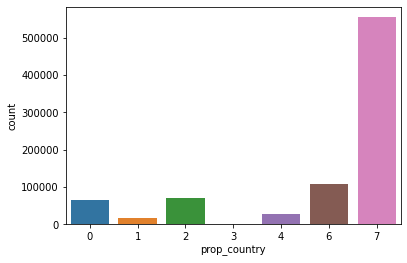

In [38]:
sns.countplot('prop_country',data=train_clean.sort_values(by=['prop_country']))
print(prop_country_cat)

According to the chart above, we discovered that USA is the most popular country for traving in the train dataset

<AxesSubplot:xlabel='prop_starrating', ylabel='count'>

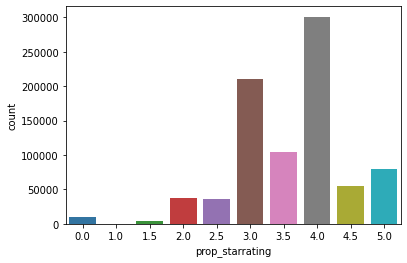

In [39]:
sns.countplot('prop_starrating',data=train_clean.sort_values(by=['prop_starrating']))

According the chart above,  4-star hotels make up the majority among the hotels in train dataset. 

<AxesSubplot:xlabel='prop_review_score', ylabel='count'>

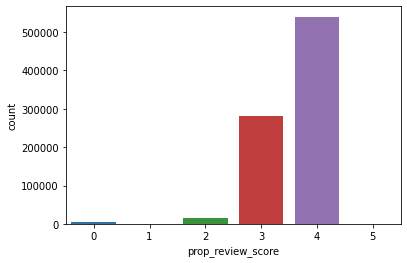

In [40]:
review = train_clean[['prop_review_score']].astype(int)
sns.countplot('prop_review_score',data=review.sort_values(by=['prop_review_score']))

According the chart above, among the hotels in all datasets, hotels with a rating of around 4 make up the majority

## Modelling
1. Get the processed train dataset and test dataset 
2. Use cross-validation to select the best hyperparameters for XGBoost model 
3. Train the XGBoost with selected hyperparameters 
4. Predict the ranking in test dataset and output

XGBoost is a widely used machine learning method, which uses gradient boosting techniques to incrementally build a better model during the training phase by combining multiple weak models. Weak models are generated by computing the gradient descent using an objective function. The model thus built is then used for prediction in a future inference phase. Learning To Rank (LETOR) is one such objective function. 

### Get the processed train dataset and test dataset

In [41]:
train_clean = features.loc[:len(train)-1,:]
train_clean['label'] = y
test_clean = features.loc[len(train):,:]
print('train data shape',train_clean.shape)
print('test data shape',test_clean.shape)

train data shape (841115, 47)
test data shape (351544, 46)


### Use cross-validation to select the best hyperparameters for XGBoost model

In [42]:
# Split train data to X_train and X_val (validation dataset)
split = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 7).split(train_clean, groups=train['srch_id']) 
X_train_inds, X_val_inds = next(split)

train_data= train_clean.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['label'])]
y_train = train_data.loc[:, 'label']
# create groups for model fit
groups_train = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


val_data= train_clean.iloc[X_val_inds]
X_val = val_data.loc[:, ~val_data.columns.isin(['label'])]
y_val = val_data.loc[:, 'label']
# create groups for model fit
groups_val= val_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [43]:
# remove the srch_id from train data
X_train.drop('srch_id',axis=1,inplace=True)
X_val.drop('srch_id',axis=1,inplace=True)

In [44]:
# Use grid search to search best hyperparameters for XGBRanker model 

n_estimators_set = [1000,1500]
max_depth_set = [6,7,8]
min_child_weight_set = [1,3,5]

best_score = 0  # store the best ndcg score 
opt_est = 0 # store the optimal estimator number 
opt_dep = 0 # store the optimal maximum depth 
min_child_weight = 0 # store the optimal minimum child weight

for n_estimators in n_estimators_set:
    for max_depth in max_depth_set:
        for min_child_weight in min_child_weight_set:
            print('n_estimators = ',n_estimators,)
            print('max_depth = ',max_depth,)
            print('min_child_weight = ', min_child_weight)
            model = xgb.XGBRanker(  
                tree_method='hist', #As exact tree method is slow in performance and not scalable, this is approximated training algorithms.
                booster='gbtree',
                objective='rank:ndcg', # Specify the learning task and the corresponding learning objective
                random_state=42, 
                learning_rate=0.05,
                colsample_bytree=0.9, # Subsample ratio of columns when constructing each tree.
                eta=0.05, 
                reg_alpha=3,
                subsample=0.75, # Subsample ratio of the training instance.
                max_depth=max_depth,  # Maximum tree depth for base learners.
                n_estimators=n_estimators, # Number of gradient boosted trees. Equivalent to number of boosting rounds.
                min_child_weight = min_child_weight #  Minimum sum of instance weight(hessian) needed in a child.
                )

            model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train), (X_val, y_val)],eval_group=[groups_train,groups_val],
                    eval_metric='ndcg@50', verbose=True)
            evals_result = model.evals_result()
            score = evals_result['validation_1']['ndcg@50'][-1]
            if score>best_score:
                best_score = score
                opt_dep = max_depth
                opt_est = n_estimators
                opt_wei = min_child_weight
                print(best_score, opt_est,opt_dep,min_child_weight)

n_estimators =  1000
max_depth =  6
min_child_weight =  1
[0]	validation_0-ndcg@50:0.59434	validation_1-ndcg@50:0.59392
[1]	validation_0-ndcg@50:0.59708	validation_1-ndcg@50:0.59479
[2]	validation_0-ndcg@50:0.59894	validation_1-ndcg@50:0.59574
[3]	validation_0-ndcg@50:0.60170	validation_1-ndcg@50:0.59598
[4]	validation_0-ndcg@50:0.60228	validation_1-ndcg@50:0.59713
[5]	validation_0-ndcg@50:0.60481	validation_1-ndcg@50:0.60078
[6]	validation_0-ndcg@50:0.60507	validation_1-ndcg@50:0.60121
[7]	validation_0-ndcg@50:0.60545	validation_1-ndcg@50:0.60144
[8]	validation_0-ndcg@50:0.60585	validation_1-ndcg@50:0.60214
[9]	validation_0-ndcg@50:0.60595	validation_1-ndcg@50:0.60213
[10]	validation_0-ndcg@50:0.60747	validation_1-ndcg@50:0.60210
[11]	validation_0-ndcg@50:0.60780	validation_1-ndcg@50:0.60258
[12]	validation_0-ndcg@50:0.60759	validation_1-ndcg@50:0.60276
[13]	validation_0-ndcg@50:0.60785	validation_1-ndcg@50:0.60302
[14]	validation_0-ndcg@50:0.60814	validation_1-ndcg@50:0.60338
[15]	va

[129]	validation_0-ndcg@50:0.63324	validation_1-ndcg@50:0.62059
[130]	validation_0-ndcg@50:0.63355	validation_1-ndcg@50:0.62088
[131]	validation_0-ndcg@50:0.63376	validation_1-ndcg@50:0.62117
[132]	validation_0-ndcg@50:0.63384	validation_1-ndcg@50:0.62067
[133]	validation_0-ndcg@50:0.63390	validation_1-ndcg@50:0.62053
[134]	validation_0-ndcg@50:0.63396	validation_1-ndcg@50:0.62070
[135]	validation_0-ndcg@50:0.63400	validation_1-ndcg@50:0.62084
[136]	validation_0-ndcg@50:0.63415	validation_1-ndcg@50:0.62096
[137]	validation_0-ndcg@50:0.63437	validation_1-ndcg@50:0.62136
[138]	validation_0-ndcg@50:0.63446	validation_1-ndcg@50:0.62138
[139]	validation_0-ndcg@50:0.63462	validation_1-ndcg@50:0.62100
[140]	validation_0-ndcg@50:0.63475	validation_1-ndcg@50:0.62130
[141]	validation_0-ndcg@50:0.63504	validation_1-ndcg@50:0.62123
[142]	validation_0-ndcg@50:0.63511	validation_1-ndcg@50:0.62132
[143]	validation_0-ndcg@50:0.63522	validation_1-ndcg@50:0.62164
[144]	validation_0-ndcg@50:0.63544	valid

[258]	validation_0-ndcg@50:0.64951	validation_1-ndcg@50:0.63125
[259]	validation_0-ndcg@50:0.64957	validation_1-ndcg@50:0.63135
[260]	validation_0-ndcg@50:0.64985	validation_1-ndcg@50:0.63128
[261]	validation_0-ndcg@50:0.65015	validation_1-ndcg@50:0.63141
[262]	validation_0-ndcg@50:0.65028	validation_1-ndcg@50:0.63159
[263]	validation_0-ndcg@50:0.65041	validation_1-ndcg@50:0.63167
[264]	validation_0-ndcg@50:0.65049	validation_1-ndcg@50:0.63201
[265]	validation_0-ndcg@50:0.65064	validation_1-ndcg@50:0.63183
[266]	validation_0-ndcg@50:0.65068	validation_1-ndcg@50:0.63159
[267]	validation_0-ndcg@50:0.65095	validation_1-ndcg@50:0.63164
[268]	validation_0-ndcg@50:0.65117	validation_1-ndcg@50:0.63170
[269]	validation_0-ndcg@50:0.65131	validation_1-ndcg@50:0.63184
[270]	validation_0-ndcg@50:0.65142	validation_1-ndcg@50:0.63195
[271]	validation_0-ndcg@50:0.65156	validation_1-ndcg@50:0.63192
[272]	validation_0-ndcg@50:0.65180	validation_1-ndcg@50:0.63214
[273]	validation_0-ndcg@50:0.65184	valid

[387]	validation_0-ndcg@50:0.66390	validation_1-ndcg@50:0.63799
[388]	validation_0-ndcg@50:0.66412	validation_1-ndcg@50:0.63825
[389]	validation_0-ndcg@50:0.66421	validation_1-ndcg@50:0.63820
[390]	validation_0-ndcg@50:0.66434	validation_1-ndcg@50:0.63850
[391]	validation_0-ndcg@50:0.66438	validation_1-ndcg@50:0.63864
[392]	validation_0-ndcg@50:0.66449	validation_1-ndcg@50:0.63870
[393]	validation_0-ndcg@50:0.66462	validation_1-ndcg@50:0.63882
[394]	validation_0-ndcg@50:0.66470	validation_1-ndcg@50:0.63878
[395]	validation_0-ndcg@50:0.66468	validation_1-ndcg@50:0.63879
[396]	validation_0-ndcg@50:0.66487	validation_1-ndcg@50:0.63880
[397]	validation_0-ndcg@50:0.66493	validation_1-ndcg@50:0.63894
[398]	validation_0-ndcg@50:0.66510	validation_1-ndcg@50:0.63906
[399]	validation_0-ndcg@50:0.66519	validation_1-ndcg@50:0.63924
[400]	validation_0-ndcg@50:0.66526	validation_1-ndcg@50:0.63919
[401]	validation_0-ndcg@50:0.66537	validation_1-ndcg@50:0.63935
[402]	validation_0-ndcg@50:0.66545	valid

[516]	validation_0-ndcg@50:0.67532	validation_1-ndcg@50:0.64221
[517]	validation_0-ndcg@50:0.67535	validation_1-ndcg@50:0.64209
[518]	validation_0-ndcg@50:0.67549	validation_1-ndcg@50:0.64225
[519]	validation_0-ndcg@50:0.67557	validation_1-ndcg@50:0.64229
[520]	validation_0-ndcg@50:0.67560	validation_1-ndcg@50:0.64227
[521]	validation_0-ndcg@50:0.67570	validation_1-ndcg@50:0.64253
[522]	validation_0-ndcg@50:0.67576	validation_1-ndcg@50:0.64244
[523]	validation_0-ndcg@50:0.67587	validation_1-ndcg@50:0.64255
[524]	validation_0-ndcg@50:0.67590	validation_1-ndcg@50:0.64244
[525]	validation_0-ndcg@50:0.67602	validation_1-ndcg@50:0.64241
[526]	validation_0-ndcg@50:0.67608	validation_1-ndcg@50:0.64241
[527]	validation_0-ndcg@50:0.67613	validation_1-ndcg@50:0.64235
[528]	validation_0-ndcg@50:0.67612	validation_1-ndcg@50:0.64243
[529]	validation_0-ndcg@50:0.67624	validation_1-ndcg@50:0.64235
[530]	validation_0-ndcg@50:0.67623	validation_1-ndcg@50:0.64242
[531]	validation_0-ndcg@50:0.67636	valid

[645]	validation_0-ndcg@50:0.68445	validation_1-ndcg@50:0.64504
[646]	validation_0-ndcg@50:0.68449	validation_1-ndcg@50:0.64495
[647]	validation_0-ndcg@50:0.68458	validation_1-ndcg@50:0.64496
[648]	validation_0-ndcg@50:0.68460	validation_1-ndcg@50:0.64504
[649]	validation_0-ndcg@50:0.68466	validation_1-ndcg@50:0.64487
[650]	validation_0-ndcg@50:0.68475	validation_1-ndcg@50:0.64481
[651]	validation_0-ndcg@50:0.68489	validation_1-ndcg@50:0.64505
[652]	validation_0-ndcg@50:0.68495	validation_1-ndcg@50:0.64506
[653]	validation_0-ndcg@50:0.68496	validation_1-ndcg@50:0.64507
[654]	validation_0-ndcg@50:0.68507	validation_1-ndcg@50:0.64503
[655]	validation_0-ndcg@50:0.68503	validation_1-ndcg@50:0.64507
[656]	validation_0-ndcg@50:0.68506	validation_1-ndcg@50:0.64518
[657]	validation_0-ndcg@50:0.68522	validation_1-ndcg@50:0.64501
[658]	validation_0-ndcg@50:0.68522	validation_1-ndcg@50:0.64522
[659]	validation_0-ndcg@50:0.68542	validation_1-ndcg@50:0.64506
[660]	validation_0-ndcg@50:0.68546	valid

[774]	validation_0-ndcg@50:0.69237	validation_1-ndcg@50:0.64606
[775]	validation_0-ndcg@50:0.69244	validation_1-ndcg@50:0.64606
[776]	validation_0-ndcg@50:0.69243	validation_1-ndcg@50:0.64592
[777]	validation_0-ndcg@50:0.69249	validation_1-ndcg@50:0.64589
[778]	validation_0-ndcg@50:0.69261	validation_1-ndcg@50:0.64607
[779]	validation_0-ndcg@50:0.69265	validation_1-ndcg@50:0.64626
[780]	validation_0-ndcg@50:0.69275	validation_1-ndcg@50:0.64622
[781]	validation_0-ndcg@50:0.69282	validation_1-ndcg@50:0.64621
[782]	validation_0-ndcg@50:0.69292	validation_1-ndcg@50:0.64620
[783]	validation_0-ndcg@50:0.69299	validation_1-ndcg@50:0.64615
[784]	validation_0-ndcg@50:0.69304	validation_1-ndcg@50:0.64606
[785]	validation_0-ndcg@50:0.69313	validation_1-ndcg@50:0.64606
[786]	validation_0-ndcg@50:0.69318	validation_1-ndcg@50:0.64606
[787]	validation_0-ndcg@50:0.69327	validation_1-ndcg@50:0.64599
[788]	validation_0-ndcg@50:0.69330	validation_1-ndcg@50:0.64625
[789]	validation_0-ndcg@50:0.69334	valid

[903]	validation_0-ndcg@50:0.69999	validation_1-ndcg@50:0.64751
[904]	validation_0-ndcg@50:0.70005	validation_1-ndcg@50:0.64740
[905]	validation_0-ndcg@50:0.70011	validation_1-ndcg@50:0.64739
[906]	validation_0-ndcg@50:0.70015	validation_1-ndcg@50:0.64724
[907]	validation_0-ndcg@50:0.70021	validation_1-ndcg@50:0.64722
[908]	validation_0-ndcg@50:0.70023	validation_1-ndcg@50:0.64731
[909]	validation_0-ndcg@50:0.70027	validation_1-ndcg@50:0.64746
[910]	validation_0-ndcg@50:0.70034	validation_1-ndcg@50:0.64752
[911]	validation_0-ndcg@50:0.70038	validation_1-ndcg@50:0.64735
[912]	validation_0-ndcg@50:0.70046	validation_1-ndcg@50:0.64738
[913]	validation_0-ndcg@50:0.70050	validation_1-ndcg@50:0.64730
[914]	validation_0-ndcg@50:0.70056	validation_1-ndcg@50:0.64731
[915]	validation_0-ndcg@50:0.70057	validation_1-ndcg@50:0.64728
[916]	validation_0-ndcg@50:0.70063	validation_1-ndcg@50:0.64737
[917]	validation_0-ndcg@50:0.70068	validation_1-ndcg@50:0.64743
[918]	validation_0-ndcg@50:0.70070	valid

[31]	validation_0-ndcg@50:0.61387	validation_1-ndcg@50:0.60672
[32]	validation_0-ndcg@50:0.61407	validation_1-ndcg@50:0.60681
[33]	validation_0-ndcg@50:0.61442	validation_1-ndcg@50:0.60691
[34]	validation_0-ndcg@50:0.61445	validation_1-ndcg@50:0.60753
[35]	validation_0-ndcg@50:0.61487	validation_1-ndcg@50:0.60780
[36]	validation_0-ndcg@50:0.61554	validation_1-ndcg@50:0.60834
[37]	validation_0-ndcg@50:0.61572	validation_1-ndcg@50:0.60846
[38]	validation_0-ndcg@50:0.61579	validation_1-ndcg@50:0.60895
[39]	validation_0-ndcg@50:0.61618	validation_1-ndcg@50:0.60906
[40]	validation_0-ndcg@50:0.61635	validation_1-ndcg@50:0.60909
[41]	validation_0-ndcg@50:0.61648	validation_1-ndcg@50:0.60890
[42]	validation_0-ndcg@50:0.61714	validation_1-ndcg@50:0.60925
[43]	validation_0-ndcg@50:0.61748	validation_1-ndcg@50:0.60953
[44]	validation_0-ndcg@50:0.61799	validation_1-ndcg@50:0.60963
[45]	validation_0-ndcg@50:0.61836	validation_1-ndcg@50:0.60968
[46]	validation_0-ndcg@50:0.61855	validation_1-ndcg@50:

[161]	validation_0-ndcg@50:0.63708	validation_1-ndcg@50:0.62289
[162]	validation_0-ndcg@50:0.63717	validation_1-ndcg@50:0.62289
[163]	validation_0-ndcg@50:0.63718	validation_1-ndcg@50:0.62286
[164]	validation_0-ndcg@50:0.63723	validation_1-ndcg@50:0.62310
[165]	validation_0-ndcg@50:0.63724	validation_1-ndcg@50:0.62312
[166]	validation_0-ndcg@50:0.63755	validation_1-ndcg@50:0.62319
[167]	validation_0-ndcg@50:0.63758	validation_1-ndcg@50:0.62325
[168]	validation_0-ndcg@50:0.63783	validation_1-ndcg@50:0.62332
[169]	validation_0-ndcg@50:0.63801	validation_1-ndcg@50:0.62377
[170]	validation_0-ndcg@50:0.63819	validation_1-ndcg@50:0.62393
[171]	validation_0-ndcg@50:0.63836	validation_1-ndcg@50:0.62403
[172]	validation_0-ndcg@50:0.63852	validation_1-ndcg@50:0.62400
[173]	validation_0-ndcg@50:0.63850	validation_1-ndcg@50:0.62410
[174]	validation_0-ndcg@50:0.63872	validation_1-ndcg@50:0.62398
[175]	validation_0-ndcg@50:0.63882	validation_1-ndcg@50:0.62403
[176]	validation_0-ndcg@50:0.63902	valid

[290]	validation_0-ndcg@50:0.65289	validation_1-ndcg@50:0.63214
[291]	validation_0-ndcg@50:0.65318	validation_1-ndcg@50:0.63222
[292]	validation_0-ndcg@50:0.65330	validation_1-ndcg@50:0.63217
[293]	validation_0-ndcg@50:0.65335	validation_1-ndcg@50:0.63250
[294]	validation_0-ndcg@50:0.65338	validation_1-ndcg@50:0.63262
[295]	validation_0-ndcg@50:0.65348	validation_1-ndcg@50:0.63257
[296]	validation_0-ndcg@50:0.65359	validation_1-ndcg@50:0.63255
[297]	validation_0-ndcg@50:0.65367	validation_1-ndcg@50:0.63255
[298]	validation_0-ndcg@50:0.65387	validation_1-ndcg@50:0.63260
[299]	validation_0-ndcg@50:0.65394	validation_1-ndcg@50:0.63254
[300]	validation_0-ndcg@50:0.65399	validation_1-ndcg@50:0.63275
[301]	validation_0-ndcg@50:0.65404	validation_1-ndcg@50:0.63276
[302]	validation_0-ndcg@50:0.65418	validation_1-ndcg@50:0.63259
[303]	validation_0-ndcg@50:0.65431	validation_1-ndcg@50:0.63271
[304]	validation_0-ndcg@50:0.65436	validation_1-ndcg@50:0.63299
[305]	validation_0-ndcg@50:0.65449	valid

[419]	validation_0-ndcg@50:0.66667	validation_1-ndcg@50:0.63941
[420]	validation_0-ndcg@50:0.66674	validation_1-ndcg@50:0.63930
[421]	validation_0-ndcg@50:0.66679	validation_1-ndcg@50:0.63940
[422]	validation_0-ndcg@50:0.66685	validation_1-ndcg@50:0.63931
[423]	validation_0-ndcg@50:0.66708	validation_1-ndcg@50:0.63936
[424]	validation_0-ndcg@50:0.66729	validation_1-ndcg@50:0.63951
[425]	validation_0-ndcg@50:0.66731	validation_1-ndcg@50:0.63956
[426]	validation_0-ndcg@50:0.66740	validation_1-ndcg@50:0.63948
[427]	validation_0-ndcg@50:0.66744	validation_1-ndcg@50:0.63975
[428]	validation_0-ndcg@50:0.66753	validation_1-ndcg@50:0.63959
[429]	validation_0-ndcg@50:0.66756	validation_1-ndcg@50:0.63989
[430]	validation_0-ndcg@50:0.66771	validation_1-ndcg@50:0.63989
[431]	validation_0-ndcg@50:0.66785	validation_1-ndcg@50:0.63986
[432]	validation_0-ndcg@50:0.66790	validation_1-ndcg@50:0.64001
[433]	validation_0-ndcg@50:0.66804	validation_1-ndcg@50:0.64011
[434]	validation_0-ndcg@50:0.66805	valid

[548]	validation_0-ndcg@50:0.67759	validation_1-ndcg@50:0.64426
[549]	validation_0-ndcg@50:0.67773	validation_1-ndcg@50:0.64421
[550]	validation_0-ndcg@50:0.67771	validation_1-ndcg@50:0.64431
[551]	validation_0-ndcg@50:0.67781	validation_1-ndcg@50:0.64436
[552]	validation_0-ndcg@50:0.67795	validation_1-ndcg@50:0.64469
[553]	validation_0-ndcg@50:0.67802	validation_1-ndcg@50:0.64470
[554]	validation_0-ndcg@50:0.67813	validation_1-ndcg@50:0.64473
[555]	validation_0-ndcg@50:0.67803	validation_1-ndcg@50:0.64461
[556]	validation_0-ndcg@50:0.67811	validation_1-ndcg@50:0.64445
[557]	validation_0-ndcg@50:0.67815	validation_1-ndcg@50:0.64443
[558]	validation_0-ndcg@50:0.67825	validation_1-ndcg@50:0.64444
[559]	validation_0-ndcg@50:0.67829	validation_1-ndcg@50:0.64449
[560]	validation_0-ndcg@50:0.67840	validation_1-ndcg@50:0.64468
[561]	validation_0-ndcg@50:0.67844	validation_1-ndcg@50:0.64465
[562]	validation_0-ndcg@50:0.67851	validation_1-ndcg@50:0.64483
[563]	validation_0-ndcg@50:0.67865	valid

[677]	validation_0-ndcg@50:0.68617	validation_1-ndcg@50:0.64637
[678]	validation_0-ndcg@50:0.68626	validation_1-ndcg@50:0.64648
[679]	validation_0-ndcg@50:0.68634	validation_1-ndcg@50:0.64657
[680]	validation_0-ndcg@50:0.68634	validation_1-ndcg@50:0.64653
[681]	validation_0-ndcg@50:0.68648	validation_1-ndcg@50:0.64655
[682]	validation_0-ndcg@50:0.68651	validation_1-ndcg@50:0.64657
[683]	validation_0-ndcg@50:0.68655	validation_1-ndcg@50:0.64677
[684]	validation_0-ndcg@50:0.68659	validation_1-ndcg@50:0.64689
[685]	validation_0-ndcg@50:0.68668	validation_1-ndcg@50:0.64690
[686]	validation_0-ndcg@50:0.68667	validation_1-ndcg@50:0.64692
[687]	validation_0-ndcg@50:0.68675	validation_1-ndcg@50:0.64676
[688]	validation_0-ndcg@50:0.68683	validation_1-ndcg@50:0.64657
[689]	validation_0-ndcg@50:0.68685	validation_1-ndcg@50:0.64672
[690]	validation_0-ndcg@50:0.68691	validation_1-ndcg@50:0.64692
[691]	validation_0-ndcg@50:0.68700	validation_1-ndcg@50:0.64699
[692]	validation_0-ndcg@50:0.68699	valid

[806]	validation_0-ndcg@50:0.69375	validation_1-ndcg@50:0.64861
[807]	validation_0-ndcg@50:0.69383	validation_1-ndcg@50:0.64852
[808]	validation_0-ndcg@50:0.69394	validation_1-ndcg@50:0.64858
[809]	validation_0-ndcg@50:0.69400	validation_1-ndcg@50:0.64858
[810]	validation_0-ndcg@50:0.69404	validation_1-ndcg@50:0.64862
[811]	validation_0-ndcg@50:0.69413	validation_1-ndcg@50:0.64863
[812]	validation_0-ndcg@50:0.69414	validation_1-ndcg@50:0.64856
[813]	validation_0-ndcg@50:0.69418	validation_1-ndcg@50:0.64868
[814]	validation_0-ndcg@50:0.69430	validation_1-ndcg@50:0.64842
[815]	validation_0-ndcg@50:0.69433	validation_1-ndcg@50:0.64852
[816]	validation_0-ndcg@50:0.69445	validation_1-ndcg@50:0.64854
[817]	validation_0-ndcg@50:0.69452	validation_1-ndcg@50:0.64852
[818]	validation_0-ndcg@50:0.69451	validation_1-ndcg@50:0.64860
[819]	validation_0-ndcg@50:0.69458	validation_1-ndcg@50:0.64852
[820]	validation_0-ndcg@50:0.69458	validation_1-ndcg@50:0.64869
[821]	validation_0-ndcg@50:0.69466	valid

[935]	validation_0-ndcg@50:0.70105	validation_1-ndcg@50:0.64957
[936]	validation_0-ndcg@50:0.70116	validation_1-ndcg@50:0.64957
[937]	validation_0-ndcg@50:0.70121	validation_1-ndcg@50:0.64965
[938]	validation_0-ndcg@50:0.70126	validation_1-ndcg@50:0.64972
[939]	validation_0-ndcg@50:0.70131	validation_1-ndcg@50:0.64979
[940]	validation_0-ndcg@50:0.70140	validation_1-ndcg@50:0.64991
[941]	validation_0-ndcg@50:0.70147	validation_1-ndcg@50:0.64981
[942]	validation_0-ndcg@50:0.70157	validation_1-ndcg@50:0.64977
[943]	validation_0-ndcg@50:0.70161	validation_1-ndcg@50:0.64989
[944]	validation_0-ndcg@50:0.70164	validation_1-ndcg@50:0.64967
[945]	validation_0-ndcg@50:0.70173	validation_1-ndcg@50:0.64969
[946]	validation_0-ndcg@50:0.70176	validation_1-ndcg@50:0.64973
[947]	validation_0-ndcg@50:0.70190	validation_1-ndcg@50:0.64972
[948]	validation_0-ndcg@50:0.70207	validation_1-ndcg@50:0.64990
[949]	validation_0-ndcg@50:0.70213	validation_1-ndcg@50:0.64992
[950]	validation_0-ndcg@50:0.70220	valid

[63]	validation_0-ndcg@50:0.62262	validation_1-ndcg@50:0.61204
[64]	validation_0-ndcg@50:0.62282	validation_1-ndcg@50:0.61257
[65]	validation_0-ndcg@50:0.62286	validation_1-ndcg@50:0.61261
[66]	validation_0-ndcg@50:0.62314	validation_1-ndcg@50:0.61269
[67]	validation_0-ndcg@50:0.62355	validation_1-ndcg@50:0.61327
[68]	validation_0-ndcg@50:0.62361	validation_1-ndcg@50:0.61326
[69]	validation_0-ndcg@50:0.62383	validation_1-ndcg@50:0.61336
[70]	validation_0-ndcg@50:0.62403	validation_1-ndcg@50:0.61314
[71]	validation_0-ndcg@50:0.62416	validation_1-ndcg@50:0.61350
[72]	validation_0-ndcg@50:0.62426	validation_1-ndcg@50:0.61362
[73]	validation_0-ndcg@50:0.62453	validation_1-ndcg@50:0.61343
[74]	validation_0-ndcg@50:0.62469	validation_1-ndcg@50:0.61424
[75]	validation_0-ndcg@50:0.62484	validation_1-ndcg@50:0.61421
[76]	validation_0-ndcg@50:0.62495	validation_1-ndcg@50:0.61414
[77]	validation_0-ndcg@50:0.62500	validation_1-ndcg@50:0.61429
[78]	validation_0-ndcg@50:0.62502	validation_1-ndcg@50:

[192]	validation_0-ndcg@50:0.64128	validation_1-ndcg@50:0.62640
[193]	validation_0-ndcg@50:0.64158	validation_1-ndcg@50:0.62635
[194]	validation_0-ndcg@50:0.64160	validation_1-ndcg@50:0.62668
[195]	validation_0-ndcg@50:0.64167	validation_1-ndcg@50:0.62663
[196]	validation_0-ndcg@50:0.64174	validation_1-ndcg@50:0.62691
[197]	validation_0-ndcg@50:0.64192	validation_1-ndcg@50:0.62666
[198]	validation_0-ndcg@50:0.64210	validation_1-ndcg@50:0.62682
[199]	validation_0-ndcg@50:0.64214	validation_1-ndcg@50:0.62699
[200]	validation_0-ndcg@50:0.64233	validation_1-ndcg@50:0.62705
[201]	validation_0-ndcg@50:0.64264	validation_1-ndcg@50:0.62715
[202]	validation_0-ndcg@50:0.64280	validation_1-ndcg@50:0.62728
[203]	validation_0-ndcg@50:0.64289	validation_1-ndcg@50:0.62736
[204]	validation_0-ndcg@50:0.64304	validation_1-ndcg@50:0.62738
[205]	validation_0-ndcg@50:0.64321	validation_1-ndcg@50:0.62741
[206]	validation_0-ndcg@50:0.64332	validation_1-ndcg@50:0.62764
[207]	validation_0-ndcg@50:0.64346	valid

[321]	validation_0-ndcg@50:0.65609	validation_1-ndcg@50:0.63476
[322]	validation_0-ndcg@50:0.65613	validation_1-ndcg@50:0.63477
[323]	validation_0-ndcg@50:0.65622	validation_1-ndcg@50:0.63487
[324]	validation_0-ndcg@50:0.65634	validation_1-ndcg@50:0.63479
[325]	validation_0-ndcg@50:0.65645	validation_1-ndcg@50:0.63490
[326]	validation_0-ndcg@50:0.65652	validation_1-ndcg@50:0.63481
[327]	validation_0-ndcg@50:0.65658	validation_1-ndcg@50:0.63489
[328]	validation_0-ndcg@50:0.65668	validation_1-ndcg@50:0.63505
[329]	validation_0-ndcg@50:0.65674	validation_1-ndcg@50:0.63526
[330]	validation_0-ndcg@50:0.65699	validation_1-ndcg@50:0.63519
[331]	validation_0-ndcg@50:0.65711	validation_1-ndcg@50:0.63529
[332]	validation_0-ndcg@50:0.65720	validation_1-ndcg@50:0.63536
[333]	validation_0-ndcg@50:0.65750	validation_1-ndcg@50:0.63553
[334]	validation_0-ndcg@50:0.65768	validation_1-ndcg@50:0.63547
[335]	validation_0-ndcg@50:0.65782	validation_1-ndcg@50:0.63555
[336]	validation_0-ndcg@50:0.65805	valid

[450]	validation_0-ndcg@50:0.66883	validation_1-ndcg@50:0.64110
[451]	validation_0-ndcg@50:0.66877	validation_1-ndcg@50:0.64111
[452]	validation_0-ndcg@50:0.66895	validation_1-ndcg@50:0.64105
[453]	validation_0-ndcg@50:0.66901	validation_1-ndcg@50:0.64106
[454]	validation_0-ndcg@50:0.66916	validation_1-ndcg@50:0.64115
[455]	validation_0-ndcg@50:0.66921	validation_1-ndcg@50:0.64135
[456]	validation_0-ndcg@50:0.66933	validation_1-ndcg@50:0.64156
[457]	validation_0-ndcg@50:0.66941	validation_1-ndcg@50:0.64161
[458]	validation_0-ndcg@50:0.66944	validation_1-ndcg@50:0.64183
[459]	validation_0-ndcg@50:0.66961	validation_1-ndcg@50:0.64179
[460]	validation_0-ndcg@50:0.66960	validation_1-ndcg@50:0.64196
[461]	validation_0-ndcg@50:0.66975	validation_1-ndcg@50:0.64198
[462]	validation_0-ndcg@50:0.66967	validation_1-ndcg@50:0.64183
[463]	validation_0-ndcg@50:0.66976	validation_1-ndcg@50:0.64177
[464]	validation_0-ndcg@50:0.66991	validation_1-ndcg@50:0.64195
[465]	validation_0-ndcg@50:0.66995	valid

[579]	validation_0-ndcg@50:0.67906	validation_1-ndcg@50:0.64509
[580]	validation_0-ndcg@50:0.67909	validation_1-ndcg@50:0.64502
[581]	validation_0-ndcg@50:0.67915	validation_1-ndcg@50:0.64521
[582]	validation_0-ndcg@50:0.67927	validation_1-ndcg@50:0.64526
[583]	validation_0-ndcg@50:0.67927	validation_1-ndcg@50:0.64522
[584]	validation_0-ndcg@50:0.67929	validation_1-ndcg@50:0.64529
[585]	validation_0-ndcg@50:0.67934	validation_1-ndcg@50:0.64521
[586]	validation_0-ndcg@50:0.67944	validation_1-ndcg@50:0.64517
[587]	validation_0-ndcg@50:0.67945	validation_1-ndcg@50:0.64527
[588]	validation_0-ndcg@50:0.67953	validation_1-ndcg@50:0.64524
[589]	validation_0-ndcg@50:0.67967	validation_1-ndcg@50:0.64519
[590]	validation_0-ndcg@50:0.67968	validation_1-ndcg@50:0.64517
[591]	validation_0-ndcg@50:0.67963	validation_1-ndcg@50:0.64528
[592]	validation_0-ndcg@50:0.67963	validation_1-ndcg@50:0.64528
[593]	validation_0-ndcg@50:0.67976	validation_1-ndcg@50:0.64533
[594]	validation_0-ndcg@50:0.67983	valid

[708]	validation_0-ndcg@50:0.68692	validation_1-ndcg@50:0.64712
[709]	validation_0-ndcg@50:0.68698	validation_1-ndcg@50:0.64690
[710]	validation_0-ndcg@50:0.68700	validation_1-ndcg@50:0.64693
[711]	validation_0-ndcg@50:0.68708	validation_1-ndcg@50:0.64689
[712]	validation_0-ndcg@50:0.68715	validation_1-ndcg@50:0.64682
[713]	validation_0-ndcg@50:0.68719	validation_1-ndcg@50:0.64680
[714]	validation_0-ndcg@50:0.68717	validation_1-ndcg@50:0.64685
[715]	validation_0-ndcg@50:0.68734	validation_1-ndcg@50:0.64693
[716]	validation_0-ndcg@50:0.68744	validation_1-ndcg@50:0.64698
[717]	validation_0-ndcg@50:0.68757	validation_1-ndcg@50:0.64716
[718]	validation_0-ndcg@50:0.68772	validation_1-ndcg@50:0.64716
[719]	validation_0-ndcg@50:0.68767	validation_1-ndcg@50:0.64733
[720]	validation_0-ndcg@50:0.68769	validation_1-ndcg@50:0.64719
[721]	validation_0-ndcg@50:0.68778	validation_1-ndcg@50:0.64715
[722]	validation_0-ndcg@50:0.68783	validation_1-ndcg@50:0.64715
[723]	validation_0-ndcg@50:0.68791	valid

[837]	validation_0-ndcg@50:0.69564	validation_1-ndcg@50:0.64868
[838]	validation_0-ndcg@50:0.69569	validation_1-ndcg@50:0.64863
[839]	validation_0-ndcg@50:0.69576	validation_1-ndcg@50:0.64867
[840]	validation_0-ndcg@50:0.69582	validation_1-ndcg@50:0.64861
[841]	validation_0-ndcg@50:0.69578	validation_1-ndcg@50:0.64862
[842]	validation_0-ndcg@50:0.69595	validation_1-ndcg@50:0.64871
[843]	validation_0-ndcg@50:0.69598	validation_1-ndcg@50:0.64863
[844]	validation_0-ndcg@50:0.69607	validation_1-ndcg@50:0.64869
[845]	validation_0-ndcg@50:0.69611	validation_1-ndcg@50:0.64848
[846]	validation_0-ndcg@50:0.69613	validation_1-ndcg@50:0.64831
[847]	validation_0-ndcg@50:0.69625	validation_1-ndcg@50:0.64825
[848]	validation_0-ndcg@50:0.69623	validation_1-ndcg@50:0.64825
[849]	validation_0-ndcg@50:0.69625	validation_1-ndcg@50:0.64820
[850]	validation_0-ndcg@50:0.69634	validation_1-ndcg@50:0.64819
[851]	validation_0-ndcg@50:0.69638	validation_1-ndcg@50:0.64827
[852]	validation_0-ndcg@50:0.69643	valid

[966]	validation_0-ndcg@50:0.70285	validation_1-ndcg@50:0.64947
[967]	validation_0-ndcg@50:0.70293	validation_1-ndcg@50:0.64938
[968]	validation_0-ndcg@50:0.70298	validation_1-ndcg@50:0.64945
[969]	validation_0-ndcg@50:0.70298	validation_1-ndcg@50:0.64937
[970]	validation_0-ndcg@50:0.70297	validation_1-ndcg@50:0.64936
[971]	validation_0-ndcg@50:0.70301	validation_1-ndcg@50:0.64944
[972]	validation_0-ndcg@50:0.70309	validation_1-ndcg@50:0.64946
[973]	validation_0-ndcg@50:0.70317	validation_1-ndcg@50:0.64947
[974]	validation_0-ndcg@50:0.70320	validation_1-ndcg@50:0.64951
[975]	validation_0-ndcg@50:0.70326	validation_1-ndcg@50:0.64950
[976]	validation_0-ndcg@50:0.70340	validation_1-ndcg@50:0.64954
[977]	validation_0-ndcg@50:0.70349	validation_1-ndcg@50:0.64998
[978]	validation_0-ndcg@50:0.70351	validation_1-ndcg@50:0.65006
[979]	validation_0-ndcg@50:0.70354	validation_1-ndcg@50:0.65004
[980]	validation_0-ndcg@50:0.70357	validation_1-ndcg@50:0.65000
[981]	validation_0-ndcg@50:0.70359	valid

[95]	validation_0-ndcg@50:0.63965	validation_1-ndcg@50:0.62362
[96]	validation_0-ndcg@50:0.63987	validation_1-ndcg@50:0.62379
[97]	validation_0-ndcg@50:0.64008	validation_1-ndcg@50:0.62359
[98]	validation_0-ndcg@50:0.64015	validation_1-ndcg@50:0.62355
[99]	validation_0-ndcg@50:0.64046	validation_1-ndcg@50:0.62362
[100]	validation_0-ndcg@50:0.64062	validation_1-ndcg@50:0.62386
[101]	validation_0-ndcg@50:0.64085	validation_1-ndcg@50:0.62391
[102]	validation_0-ndcg@50:0.64099	validation_1-ndcg@50:0.62393
[103]	validation_0-ndcg@50:0.64115	validation_1-ndcg@50:0.62427
[104]	validation_0-ndcg@50:0.64148	validation_1-ndcg@50:0.62435
[105]	validation_0-ndcg@50:0.64154	validation_1-ndcg@50:0.62416
[106]	validation_0-ndcg@50:0.64184	validation_1-ndcg@50:0.62428
[107]	validation_0-ndcg@50:0.64195	validation_1-ndcg@50:0.62438
[108]	validation_0-ndcg@50:0.64232	validation_1-ndcg@50:0.62457
[109]	validation_0-ndcg@50:0.64247	validation_1-ndcg@50:0.62452
[110]	validation_0-ndcg@50:0.64272	validation

[224]	validation_0-ndcg@50:0.66119	validation_1-ndcg@50:0.63415
[225]	validation_0-ndcg@50:0.66139	validation_1-ndcg@50:0.63410
[226]	validation_0-ndcg@50:0.66146	validation_1-ndcg@50:0.63435
[227]	validation_0-ndcg@50:0.66164	validation_1-ndcg@50:0.63408
[228]	validation_0-ndcg@50:0.66179	validation_1-ndcg@50:0.63424
[229]	validation_0-ndcg@50:0.66200	validation_1-ndcg@50:0.63428
[230]	validation_0-ndcg@50:0.66211	validation_1-ndcg@50:0.63431
[231]	validation_0-ndcg@50:0.66234	validation_1-ndcg@50:0.63435
[232]	validation_0-ndcg@50:0.66246	validation_1-ndcg@50:0.63482
[233]	validation_0-ndcg@50:0.66258	validation_1-ndcg@50:0.63480
[234]	validation_0-ndcg@50:0.66261	validation_1-ndcg@50:0.63461
[235]	validation_0-ndcg@50:0.66283	validation_1-ndcg@50:0.63464
[236]	validation_0-ndcg@50:0.66304	validation_1-ndcg@50:0.63466
[237]	validation_0-ndcg@50:0.66321	validation_1-ndcg@50:0.63476
[238]	validation_0-ndcg@50:0.66336	validation_1-ndcg@50:0.63480
[239]	validation_0-ndcg@50:0.66351	valid

[353]	validation_0-ndcg@50:0.67889	validation_1-ndcg@50:0.64078
[354]	validation_0-ndcg@50:0.67905	validation_1-ndcg@50:0.64096
[355]	validation_0-ndcg@50:0.67911	validation_1-ndcg@50:0.64094
[356]	validation_0-ndcg@50:0.67927	validation_1-ndcg@50:0.64097
[357]	validation_0-ndcg@50:0.67932	validation_1-ndcg@50:0.64095
[358]	validation_0-ndcg@50:0.67933	validation_1-ndcg@50:0.64096
[359]	validation_0-ndcg@50:0.67959	validation_1-ndcg@50:0.64088
[360]	validation_0-ndcg@50:0.67980	validation_1-ndcg@50:0.64105
[361]	validation_0-ndcg@50:0.67985	validation_1-ndcg@50:0.64136
[362]	validation_0-ndcg@50:0.68000	validation_1-ndcg@50:0.64131
[363]	validation_0-ndcg@50:0.68017	validation_1-ndcg@50:0.64149
[364]	validation_0-ndcg@50:0.68019	validation_1-ndcg@50:0.64172
[365]	validation_0-ndcg@50:0.68032	validation_1-ndcg@50:0.64163
[366]	validation_0-ndcg@50:0.68040	validation_1-ndcg@50:0.64167
[367]	validation_0-ndcg@50:0.68047	validation_1-ndcg@50:0.64168
[368]	validation_0-ndcg@50:0.68059	valid

[482]	validation_0-ndcg@50:0.69408	validation_1-ndcg@50:0.64543
[483]	validation_0-ndcg@50:0.69413	validation_1-ndcg@50:0.64533
[484]	validation_0-ndcg@50:0.69434	validation_1-ndcg@50:0.64530
[485]	validation_0-ndcg@50:0.69437	validation_1-ndcg@50:0.64541
[486]	validation_0-ndcg@50:0.69451	validation_1-ndcg@50:0.64542
[487]	validation_0-ndcg@50:0.69453	validation_1-ndcg@50:0.64533
[488]	validation_0-ndcg@50:0.69459	validation_1-ndcg@50:0.64541
[489]	validation_0-ndcg@50:0.69462	validation_1-ndcg@50:0.64557
[490]	validation_0-ndcg@50:0.69483	validation_1-ndcg@50:0.64548
[491]	validation_0-ndcg@50:0.69496	validation_1-ndcg@50:0.64545
[492]	validation_0-ndcg@50:0.69509	validation_1-ndcg@50:0.64549
[493]	validation_0-ndcg@50:0.69520	validation_1-ndcg@50:0.64544
[494]	validation_0-ndcg@50:0.69532	validation_1-ndcg@50:0.64561
[495]	validation_0-ndcg@50:0.69536	validation_1-ndcg@50:0.64572
[496]	validation_0-ndcg@50:0.69546	validation_1-ndcg@50:0.64572
[497]	validation_0-ndcg@50:0.69552	valid

[611]	validation_0-ndcg@50:0.70705	validation_1-ndcg@50:0.64815
[612]	validation_0-ndcg@50:0.70714	validation_1-ndcg@50:0.64838
[613]	validation_0-ndcg@50:0.70735	validation_1-ndcg@50:0.64837
[614]	validation_0-ndcg@50:0.70740	validation_1-ndcg@50:0.64826
[615]	validation_0-ndcg@50:0.70756	validation_1-ndcg@50:0.64830
[616]	validation_0-ndcg@50:0.70780	validation_1-ndcg@50:0.64814
[617]	validation_0-ndcg@50:0.70783	validation_1-ndcg@50:0.64796
[618]	validation_0-ndcg@50:0.70787	validation_1-ndcg@50:0.64802
[619]	validation_0-ndcg@50:0.70791	validation_1-ndcg@50:0.64816
[620]	validation_0-ndcg@50:0.70801	validation_1-ndcg@50:0.64820
[621]	validation_0-ndcg@50:0.70805	validation_1-ndcg@50:0.64838
[622]	validation_0-ndcg@50:0.70823	validation_1-ndcg@50:0.64846
[623]	validation_0-ndcg@50:0.70829	validation_1-ndcg@50:0.64824
[624]	validation_0-ndcg@50:0.70838	validation_1-ndcg@50:0.64853
[625]	validation_0-ndcg@50:0.70841	validation_1-ndcg@50:0.64835
[626]	validation_0-ndcg@50:0.70856	valid

[740]	validation_0-ndcg@50:0.71959	validation_1-ndcg@50:0.65046
[741]	validation_0-ndcg@50:0.71972	validation_1-ndcg@50:0.65051
[742]	validation_0-ndcg@50:0.71983	validation_1-ndcg@50:0.65042
[743]	validation_0-ndcg@50:0.71994	validation_1-ndcg@50:0.65049
[744]	validation_0-ndcg@50:0.72006	validation_1-ndcg@50:0.65048
[745]	validation_0-ndcg@50:0.72029	validation_1-ndcg@50:0.65050
[746]	validation_0-ndcg@50:0.72038	validation_1-ndcg@50:0.65034
[747]	validation_0-ndcg@50:0.72051	validation_1-ndcg@50:0.65024
[748]	validation_0-ndcg@50:0.72057	validation_1-ndcg@50:0.65040
[749]	validation_0-ndcg@50:0.72069	validation_1-ndcg@50:0.65027
[750]	validation_0-ndcg@50:0.72082	validation_1-ndcg@50:0.65023
[751]	validation_0-ndcg@50:0.72085	validation_1-ndcg@50:0.65006
[752]	validation_0-ndcg@50:0.72090	validation_1-ndcg@50:0.65001
[753]	validation_0-ndcg@50:0.72108	validation_1-ndcg@50:0.65019
[754]	validation_0-ndcg@50:0.72116	validation_1-ndcg@50:0.65004
[755]	validation_0-ndcg@50:0.72118	valid

[869]	validation_0-ndcg@50:0.73190	validation_1-ndcg@50:0.65194
[870]	validation_0-ndcg@50:0.73200	validation_1-ndcg@50:0.65208
[871]	validation_0-ndcg@50:0.73199	validation_1-ndcg@50:0.65205
[872]	validation_0-ndcg@50:0.73203	validation_1-ndcg@50:0.65209
[873]	validation_0-ndcg@50:0.73211	validation_1-ndcg@50:0.65212
[874]	validation_0-ndcg@50:0.73219	validation_1-ndcg@50:0.65204
[875]	validation_0-ndcg@50:0.73237	validation_1-ndcg@50:0.65175
[876]	validation_0-ndcg@50:0.73250	validation_1-ndcg@50:0.65210
[877]	validation_0-ndcg@50:0.73260	validation_1-ndcg@50:0.65231
[878]	validation_0-ndcg@50:0.73274	validation_1-ndcg@50:0.65232
[879]	validation_0-ndcg@50:0.73279	validation_1-ndcg@50:0.65226
[880]	validation_0-ndcg@50:0.73284	validation_1-ndcg@50:0.65229
[881]	validation_0-ndcg@50:0.73293	validation_1-ndcg@50:0.65216
[882]	validation_0-ndcg@50:0.73293	validation_1-ndcg@50:0.65210
[883]	validation_0-ndcg@50:0.73303	validation_1-ndcg@50:0.65217
[884]	validation_0-ndcg@50:0.73316	valid

[998]	validation_0-ndcg@50:0.74139	validation_1-ndcg@50:0.65259
[999]	validation_0-ndcg@50:0.74138	validation_1-ndcg@50:0.65263
0.652633 1000 7 1
n_estimators =  1000
max_depth =  7
min_child_weight =  3
[0]	validation_0-ndcg@50:0.59906	validation_1-ndcg@50:0.59608
[1]	validation_0-ndcg@50:0.60608	validation_1-ndcg@50:0.59971
[2]	validation_0-ndcg@50:0.60664	validation_1-ndcg@50:0.59966
[3]	validation_0-ndcg@50:0.60989	validation_1-ndcg@50:0.60149
[4]	validation_0-ndcg@50:0.61067	validation_1-ndcg@50:0.60248
[5]	validation_0-ndcg@50:0.61429	validation_1-ndcg@50:0.60553
[6]	validation_0-ndcg@50:0.61501	validation_1-ndcg@50:0.60472
[7]	validation_0-ndcg@50:0.61504	validation_1-ndcg@50:0.60464
[8]	validation_0-ndcg@50:0.61501	validation_1-ndcg@50:0.60511
[9]	validation_0-ndcg@50:0.61551	validation_1-ndcg@50:0.60569
[10]	validation_0-ndcg@50:0.61539	validation_1-ndcg@50:0.60586
[11]	validation_0-ndcg@50:0.61571	validation_1-ndcg@50:0.60662
[12]	validation_0-ndcg@50:0.61655	validation_1-ndc

[127]	validation_0-ndcg@50:0.64469	validation_1-ndcg@50:0.62706
[128]	validation_0-ndcg@50:0.64493	validation_1-ndcg@50:0.62719
[129]	validation_0-ndcg@50:0.64500	validation_1-ndcg@50:0.62710
[130]	validation_0-ndcg@50:0.64520	validation_1-ndcg@50:0.62699
[131]	validation_0-ndcg@50:0.64544	validation_1-ndcg@50:0.62739
[132]	validation_0-ndcg@50:0.64563	validation_1-ndcg@50:0.62752
[133]	validation_0-ndcg@50:0.64572	validation_1-ndcg@50:0.62757
[134]	validation_0-ndcg@50:0.64586	validation_1-ndcg@50:0.62743
[135]	validation_0-ndcg@50:0.64602	validation_1-ndcg@50:0.62752
[136]	validation_0-ndcg@50:0.64619	validation_1-ndcg@50:0.62741
[137]	validation_0-ndcg@50:0.64628	validation_1-ndcg@50:0.62736
[138]	validation_0-ndcg@50:0.64642	validation_1-ndcg@50:0.62799
[139]	validation_0-ndcg@50:0.64656	validation_1-ndcg@50:0.62805
[140]	validation_0-ndcg@50:0.64662	validation_1-ndcg@50:0.62836
[141]	validation_0-ndcg@50:0.64679	validation_1-ndcg@50:0.62820
[142]	validation_0-ndcg@50:0.64698	valid

[256]	validation_0-ndcg@50:0.66526	validation_1-ndcg@50:0.63749
[257]	validation_0-ndcg@50:0.66546	validation_1-ndcg@50:0.63749
[258]	validation_0-ndcg@50:0.66554	validation_1-ndcg@50:0.63754
[259]	validation_0-ndcg@50:0.66571	validation_1-ndcg@50:0.63733
[260]	validation_0-ndcg@50:0.66583	validation_1-ndcg@50:0.63733
[261]	validation_0-ndcg@50:0.66591	validation_1-ndcg@50:0.63757
[262]	validation_0-ndcg@50:0.66620	validation_1-ndcg@50:0.63790
[263]	validation_0-ndcg@50:0.66642	validation_1-ndcg@50:0.63764
[264]	validation_0-ndcg@50:0.66654	validation_1-ndcg@50:0.63764
[265]	validation_0-ndcg@50:0.66666	validation_1-ndcg@50:0.63752
[266]	validation_0-ndcg@50:0.66672	validation_1-ndcg@50:0.63744
[267]	validation_0-ndcg@50:0.66681	validation_1-ndcg@50:0.63757
[268]	validation_0-ndcg@50:0.66693	validation_1-ndcg@50:0.63746
[269]	validation_0-ndcg@50:0.66705	validation_1-ndcg@50:0.63758
[270]	validation_0-ndcg@50:0.66734	validation_1-ndcg@50:0.63779
[271]	validation_0-ndcg@50:0.66747	valid

[385]	validation_0-ndcg@50:0.68322	validation_1-ndcg@50:0.64298
[386]	validation_0-ndcg@50:0.68333	validation_1-ndcg@50:0.64321
[387]	validation_0-ndcg@50:0.68341	validation_1-ndcg@50:0.64327
[388]	validation_0-ndcg@50:0.68352	validation_1-ndcg@50:0.64316
[389]	validation_0-ndcg@50:0.68358	validation_1-ndcg@50:0.64344
[390]	validation_0-ndcg@50:0.68374	validation_1-ndcg@50:0.64334
[391]	validation_0-ndcg@50:0.68389	validation_1-ndcg@50:0.64341
[392]	validation_0-ndcg@50:0.68403	validation_1-ndcg@50:0.64344
[393]	validation_0-ndcg@50:0.68417	validation_1-ndcg@50:0.64347
[394]	validation_0-ndcg@50:0.68430	validation_1-ndcg@50:0.64341
[395]	validation_0-ndcg@50:0.68457	validation_1-ndcg@50:0.64328
[396]	validation_0-ndcg@50:0.68464	validation_1-ndcg@50:0.64361
[397]	validation_0-ndcg@50:0.68487	validation_1-ndcg@50:0.64360
[398]	validation_0-ndcg@50:0.68494	validation_1-ndcg@50:0.64338
[399]	validation_0-ndcg@50:0.68514	validation_1-ndcg@50:0.64368
[400]	validation_0-ndcg@50:0.68519	valid

[514]	validation_0-ndcg@50:0.69753	validation_1-ndcg@50:0.64712
[515]	validation_0-ndcg@50:0.69759	validation_1-ndcg@50:0.64716
[516]	validation_0-ndcg@50:0.69768	validation_1-ndcg@50:0.64707
[517]	validation_0-ndcg@50:0.69782	validation_1-ndcg@50:0.64720
[518]	validation_0-ndcg@50:0.69787	validation_1-ndcg@50:0.64719
[519]	validation_0-ndcg@50:0.69793	validation_1-ndcg@50:0.64714
[520]	validation_0-ndcg@50:0.69812	validation_1-ndcg@50:0.64711
[521]	validation_0-ndcg@50:0.69818	validation_1-ndcg@50:0.64713
[522]	validation_0-ndcg@50:0.69832	validation_1-ndcg@50:0.64721
[523]	validation_0-ndcg@50:0.69840	validation_1-ndcg@50:0.64725
[524]	validation_0-ndcg@50:0.69853	validation_1-ndcg@50:0.64738
[525]	validation_0-ndcg@50:0.69871	validation_1-ndcg@50:0.64742
[526]	validation_0-ndcg@50:0.69872	validation_1-ndcg@50:0.64731
[527]	validation_0-ndcg@50:0.69885	validation_1-ndcg@50:0.64732
[528]	validation_0-ndcg@50:0.69896	validation_1-ndcg@50:0.64710
[529]	validation_0-ndcg@50:0.69905	valid

[643]	validation_0-ndcg@50:0.71059	validation_1-ndcg@50:0.64924
[644]	validation_0-ndcg@50:0.71060	validation_1-ndcg@50:0.64922
[645]	validation_0-ndcg@50:0.71072	validation_1-ndcg@50:0.64900
[646]	validation_0-ndcg@50:0.71079	validation_1-ndcg@50:0.64893
[647]	validation_0-ndcg@50:0.71094	validation_1-ndcg@50:0.64888
[648]	validation_0-ndcg@50:0.71100	validation_1-ndcg@50:0.64899
[649]	validation_0-ndcg@50:0.71107	validation_1-ndcg@50:0.64916
[650]	validation_0-ndcg@50:0.71117	validation_1-ndcg@50:0.64951
[651]	validation_0-ndcg@50:0.71122	validation_1-ndcg@50:0.64939
[652]	validation_0-ndcg@50:0.71127	validation_1-ndcg@50:0.64941
[653]	validation_0-ndcg@50:0.71133	validation_1-ndcg@50:0.64945
[654]	validation_0-ndcg@50:0.71138	validation_1-ndcg@50:0.64937
[655]	validation_0-ndcg@50:0.71149	validation_1-ndcg@50:0.64953
[656]	validation_0-ndcg@50:0.71158	validation_1-ndcg@50:0.64941
[657]	validation_0-ndcg@50:0.71169	validation_1-ndcg@50:0.64931
[658]	validation_0-ndcg@50:0.71172	valid

[772]	validation_0-ndcg@50:0.72223	validation_1-ndcg@50:0.65047
[773]	validation_0-ndcg@50:0.72225	validation_1-ndcg@50:0.65057
[774]	validation_0-ndcg@50:0.72226	validation_1-ndcg@50:0.65061
[775]	validation_0-ndcg@50:0.72238	validation_1-ndcg@50:0.65038
[776]	validation_0-ndcg@50:0.72250	validation_1-ndcg@50:0.65042
[777]	validation_0-ndcg@50:0.72267	validation_1-ndcg@50:0.65058
[778]	validation_0-ndcg@50:0.72277	validation_1-ndcg@50:0.65055
[779]	validation_0-ndcg@50:0.72287	validation_1-ndcg@50:0.65070
[780]	validation_0-ndcg@50:0.72287	validation_1-ndcg@50:0.65068
[781]	validation_0-ndcg@50:0.72286	validation_1-ndcg@50:0.65067
[782]	validation_0-ndcg@50:0.72299	validation_1-ndcg@50:0.65079
[783]	validation_0-ndcg@50:0.72313	validation_1-ndcg@50:0.65063
[784]	validation_0-ndcg@50:0.72314	validation_1-ndcg@50:0.65089
[785]	validation_0-ndcg@50:0.72321	validation_1-ndcg@50:0.65098
[786]	validation_0-ndcg@50:0.72344	validation_1-ndcg@50:0.65086
[787]	validation_0-ndcg@50:0.72349	valid

[901]	validation_0-ndcg@50:0.73364	validation_1-ndcg@50:0.65162
[902]	validation_0-ndcg@50:0.73380	validation_1-ndcg@50:0.65156
[903]	validation_0-ndcg@50:0.73381	validation_1-ndcg@50:0.65151
[904]	validation_0-ndcg@50:0.73395	validation_1-ndcg@50:0.65170
[905]	validation_0-ndcg@50:0.73400	validation_1-ndcg@50:0.65174
[906]	validation_0-ndcg@50:0.73404	validation_1-ndcg@50:0.65170
[907]	validation_0-ndcg@50:0.73408	validation_1-ndcg@50:0.65169
[908]	validation_0-ndcg@50:0.73416	validation_1-ndcg@50:0.65179
[909]	validation_0-ndcg@50:0.73423	validation_1-ndcg@50:0.65173
[910]	validation_0-ndcg@50:0.73425	validation_1-ndcg@50:0.65181
[911]	validation_0-ndcg@50:0.73438	validation_1-ndcg@50:0.65167
[912]	validation_0-ndcg@50:0.73453	validation_1-ndcg@50:0.65164
[913]	validation_0-ndcg@50:0.73450	validation_1-ndcg@50:0.65174
[914]	validation_0-ndcg@50:0.73459	validation_1-ndcg@50:0.65160
[915]	validation_0-ndcg@50:0.73477	validation_1-ndcg@50:0.65151
[916]	validation_0-ndcg@50:0.73480	valid

[29]	validation_0-ndcg@50:0.62366	validation_1-ndcg@50:0.61008
[30]	validation_0-ndcg@50:0.62383	validation_1-ndcg@50:0.61035
[31]	validation_0-ndcg@50:0.62412	validation_1-ndcg@50:0.61100
[32]	validation_0-ndcg@50:0.62442	validation_1-ndcg@50:0.61123
[33]	validation_0-ndcg@50:0.62465	validation_1-ndcg@50:0.61174
[34]	validation_0-ndcg@50:0.62528	validation_1-ndcg@50:0.61208
[35]	validation_0-ndcg@50:0.62517	validation_1-ndcg@50:0.61196
[36]	validation_0-ndcg@50:0.62569	validation_1-ndcg@50:0.61243
[37]	validation_0-ndcg@50:0.62603	validation_1-ndcg@50:0.61320
[38]	validation_0-ndcg@50:0.62644	validation_1-ndcg@50:0.61357
[39]	validation_0-ndcg@50:0.62688	validation_1-ndcg@50:0.61333
[40]	validation_0-ndcg@50:0.62714	validation_1-ndcg@50:0.61337
[41]	validation_0-ndcg@50:0.62730	validation_1-ndcg@50:0.61360
[42]	validation_0-ndcg@50:0.62797	validation_1-ndcg@50:0.61382
[43]	validation_0-ndcg@50:0.62829	validation_1-ndcg@50:0.61383
[44]	validation_0-ndcg@50:0.62855	validation_1-ndcg@50:

[159]	validation_0-ndcg@50:0.65025	validation_1-ndcg@50:0.62822
[160]	validation_0-ndcg@50:0.65056	validation_1-ndcg@50:0.62873
[161]	validation_0-ndcg@50:0.65071	validation_1-ndcg@50:0.62892
[162]	validation_0-ndcg@50:0.65086	validation_1-ndcg@50:0.62883
[163]	validation_0-ndcg@50:0.65108	validation_1-ndcg@50:0.62875
[164]	validation_0-ndcg@50:0.65116	validation_1-ndcg@50:0.62907
[165]	validation_0-ndcg@50:0.65161	validation_1-ndcg@50:0.62913
[166]	validation_0-ndcg@50:0.65180	validation_1-ndcg@50:0.62909
[167]	validation_0-ndcg@50:0.65200	validation_1-ndcg@50:0.62940
[168]	validation_0-ndcg@50:0.65219	validation_1-ndcg@50:0.62940
[169]	validation_0-ndcg@50:0.65242	validation_1-ndcg@50:0.62942
[170]	validation_0-ndcg@50:0.65252	validation_1-ndcg@50:0.62965
[171]	validation_0-ndcg@50:0.65260	validation_1-ndcg@50:0.62990
[172]	validation_0-ndcg@50:0.65282	validation_1-ndcg@50:0.62994
[173]	validation_0-ndcg@50:0.65299	validation_1-ndcg@50:0.62987
[174]	validation_0-ndcg@50:0.65318	valid

[288]	validation_0-ndcg@50:0.66956	validation_1-ndcg@50:0.63806
[289]	validation_0-ndcg@50:0.66972	validation_1-ndcg@50:0.63807
[290]	validation_0-ndcg@50:0.66971	validation_1-ndcg@50:0.63801
[291]	validation_0-ndcg@50:0.66977	validation_1-ndcg@50:0.63807
[292]	validation_0-ndcg@50:0.66985	validation_1-ndcg@50:0.63811
[293]	validation_0-ndcg@50:0.66995	validation_1-ndcg@50:0.63812
[294]	validation_0-ndcg@50:0.67009	validation_1-ndcg@50:0.63822
[295]	validation_0-ndcg@50:0.67026	validation_1-ndcg@50:0.63823
[296]	validation_0-ndcg@50:0.67039	validation_1-ndcg@50:0.63844
[297]	validation_0-ndcg@50:0.67046	validation_1-ndcg@50:0.63847
[298]	validation_0-ndcg@50:0.67063	validation_1-ndcg@50:0.63837
[299]	validation_0-ndcg@50:0.67082	validation_1-ndcg@50:0.63870
[300]	validation_0-ndcg@50:0.67097	validation_1-ndcg@50:0.63857
[301]	validation_0-ndcg@50:0.67107	validation_1-ndcg@50:0.63857
[302]	validation_0-ndcg@50:0.67128	validation_1-ndcg@50:0.63860
[303]	validation_0-ndcg@50:0.67134	valid

[417]	validation_0-ndcg@50:0.68690	validation_1-ndcg@50:0.64352
[418]	validation_0-ndcg@50:0.68696	validation_1-ndcg@50:0.64348
[419]	validation_0-ndcg@50:0.68720	validation_1-ndcg@50:0.64336
[420]	validation_0-ndcg@50:0.68730	validation_1-ndcg@50:0.64323
[421]	validation_0-ndcg@50:0.68734	validation_1-ndcg@50:0.64332
[422]	validation_0-ndcg@50:0.68751	validation_1-ndcg@50:0.64349
[423]	validation_0-ndcg@50:0.68770	validation_1-ndcg@50:0.64364
[424]	validation_0-ndcg@50:0.68783	validation_1-ndcg@50:0.64399
[425]	validation_0-ndcg@50:0.68792	validation_1-ndcg@50:0.64393
[426]	validation_0-ndcg@50:0.68809	validation_1-ndcg@50:0.64390
[427]	validation_0-ndcg@50:0.68811	validation_1-ndcg@50:0.64391
[428]	validation_0-ndcg@50:0.68823	validation_1-ndcg@50:0.64409
[429]	validation_0-ndcg@50:0.68828	validation_1-ndcg@50:0.64410
[430]	validation_0-ndcg@50:0.68829	validation_1-ndcg@50:0.64413
[431]	validation_0-ndcg@50:0.68836	validation_1-ndcg@50:0.64412
[432]	validation_0-ndcg@50:0.68858	valid

[546]	validation_0-ndcg@50:0.70085	validation_1-ndcg@50:0.64742
[547]	validation_0-ndcg@50:0.70100	validation_1-ndcg@50:0.64742
[548]	validation_0-ndcg@50:0.70115	validation_1-ndcg@50:0.64760
[549]	validation_0-ndcg@50:0.70129	validation_1-ndcg@50:0.64744
[550]	validation_0-ndcg@50:0.70143	validation_1-ndcg@50:0.64741
[551]	validation_0-ndcg@50:0.70148	validation_1-ndcg@50:0.64758
[552]	validation_0-ndcg@50:0.70155	validation_1-ndcg@50:0.64750
[553]	validation_0-ndcg@50:0.70160	validation_1-ndcg@50:0.64743
[554]	validation_0-ndcg@50:0.70162	validation_1-ndcg@50:0.64743
[555]	validation_0-ndcg@50:0.70172	validation_1-ndcg@50:0.64733
[556]	validation_0-ndcg@50:0.70181	validation_1-ndcg@50:0.64741
[557]	validation_0-ndcg@50:0.70197	validation_1-ndcg@50:0.64742
[558]	validation_0-ndcg@50:0.70213	validation_1-ndcg@50:0.64726
[559]	validation_0-ndcg@50:0.70221	validation_1-ndcg@50:0.64755
[560]	validation_0-ndcg@50:0.70233	validation_1-ndcg@50:0.64765
[561]	validation_0-ndcg@50:0.70242	valid

[675]	validation_0-ndcg@50:0.71326	validation_1-ndcg@50:0.64829
[676]	validation_0-ndcg@50:0.71337	validation_1-ndcg@50:0.64816
[677]	validation_0-ndcg@50:0.71345	validation_1-ndcg@50:0.64818
[678]	validation_0-ndcg@50:0.71344	validation_1-ndcg@50:0.64812
[679]	validation_0-ndcg@50:0.71349	validation_1-ndcg@50:0.64790
[680]	validation_0-ndcg@50:0.71345	validation_1-ndcg@50:0.64793
[681]	validation_0-ndcg@50:0.71354	validation_1-ndcg@50:0.64797
[682]	validation_0-ndcg@50:0.71364	validation_1-ndcg@50:0.64805
[683]	validation_0-ndcg@50:0.71384	validation_1-ndcg@50:0.64816
[684]	validation_0-ndcg@50:0.71393	validation_1-ndcg@50:0.64818
[685]	validation_0-ndcg@50:0.71398	validation_1-ndcg@50:0.64813
[686]	validation_0-ndcg@50:0.71399	validation_1-ndcg@50:0.64801
[687]	validation_0-ndcg@50:0.71416	validation_1-ndcg@50:0.64802
[688]	validation_0-ndcg@50:0.71418	validation_1-ndcg@50:0.64815
[689]	validation_0-ndcg@50:0.71421	validation_1-ndcg@50:0.64808
[690]	validation_0-ndcg@50:0.71439	valid

[804]	validation_0-ndcg@50:0.72409	validation_1-ndcg@50:0.65005
[805]	validation_0-ndcg@50:0.72428	validation_1-ndcg@50:0.65012
[806]	validation_0-ndcg@50:0.72437	validation_1-ndcg@50:0.65020
[807]	validation_0-ndcg@50:0.72442	validation_1-ndcg@50:0.65032
[808]	validation_0-ndcg@50:0.72454	validation_1-ndcg@50:0.65031
[809]	validation_0-ndcg@50:0.72466	validation_1-ndcg@50:0.65074
[810]	validation_0-ndcg@50:0.72478	validation_1-ndcg@50:0.65076
[811]	validation_0-ndcg@50:0.72477	validation_1-ndcg@50:0.65077
[812]	validation_0-ndcg@50:0.72492	validation_1-ndcg@50:0.65072
[813]	validation_0-ndcg@50:0.72500	validation_1-ndcg@50:0.65080
[814]	validation_0-ndcg@50:0.72522	validation_1-ndcg@50:0.65085
[815]	validation_0-ndcg@50:0.72519	validation_1-ndcg@50:0.65080
[816]	validation_0-ndcg@50:0.72525	validation_1-ndcg@50:0.65067
[817]	validation_0-ndcg@50:0.72536	validation_1-ndcg@50:0.65068
[818]	validation_0-ndcg@50:0.72544	validation_1-ndcg@50:0.65085
[819]	validation_0-ndcg@50:0.72551	valid

[933]	validation_0-ndcg@50:0.73439	validation_1-ndcg@50:0.65126
[934]	validation_0-ndcg@50:0.73444	validation_1-ndcg@50:0.65123
[935]	validation_0-ndcg@50:0.73452	validation_1-ndcg@50:0.65116
[936]	validation_0-ndcg@50:0.73460	validation_1-ndcg@50:0.65131
[937]	validation_0-ndcg@50:0.73469	validation_1-ndcg@50:0.65120
[938]	validation_0-ndcg@50:0.73485	validation_1-ndcg@50:0.65108
[939]	validation_0-ndcg@50:0.73488	validation_1-ndcg@50:0.65107
[940]	validation_0-ndcg@50:0.73498	validation_1-ndcg@50:0.65112
[941]	validation_0-ndcg@50:0.73503	validation_1-ndcg@50:0.65119
[942]	validation_0-ndcg@50:0.73514	validation_1-ndcg@50:0.65119
[943]	validation_0-ndcg@50:0.73520	validation_1-ndcg@50:0.65100
[944]	validation_0-ndcg@50:0.73532	validation_1-ndcg@50:0.65102
[945]	validation_0-ndcg@50:0.73541	validation_1-ndcg@50:0.65100
[946]	validation_0-ndcg@50:0.73536	validation_1-ndcg@50:0.65093
[947]	validation_0-ndcg@50:0.73545	validation_1-ndcg@50:0.65094
[948]	validation_0-ndcg@50:0.73545	valid

[62]	validation_0-ndcg@50:0.64646	validation_1-ndcg@50:0.62402
[63]	validation_0-ndcg@50:0.64657	validation_1-ndcg@50:0.62355
[64]	validation_0-ndcg@50:0.64647	validation_1-ndcg@50:0.62413
[65]	validation_0-ndcg@50:0.64689	validation_1-ndcg@50:0.62396
[66]	validation_0-ndcg@50:0.64728	validation_1-ndcg@50:0.62447
[67]	validation_0-ndcg@50:0.64747	validation_1-ndcg@50:0.62460
[68]	validation_0-ndcg@50:0.64745	validation_1-ndcg@50:0.62475
[69]	validation_0-ndcg@50:0.64758	validation_1-ndcg@50:0.62479
[70]	validation_0-ndcg@50:0.64806	validation_1-ndcg@50:0.62533
[71]	validation_0-ndcg@50:0.64810	validation_1-ndcg@50:0.62535
[72]	validation_0-ndcg@50:0.64822	validation_1-ndcg@50:0.62516
[73]	validation_0-ndcg@50:0.64850	validation_1-ndcg@50:0.62519
[74]	validation_0-ndcg@50:0.64884	validation_1-ndcg@50:0.62545
[75]	validation_0-ndcg@50:0.64915	validation_1-ndcg@50:0.62598
[76]	validation_0-ndcg@50:0.64932	validation_1-ndcg@50:0.62568
[77]	validation_0-ndcg@50:0.64927	validation_1-ndcg@50:

[191]	validation_0-ndcg@50:0.67245	validation_1-ndcg@50:0.63642
[192]	validation_0-ndcg@50:0.67264	validation_1-ndcg@50:0.63665
[193]	validation_0-ndcg@50:0.67277	validation_1-ndcg@50:0.63684
[194]	validation_0-ndcg@50:0.67292	validation_1-ndcg@50:0.63671
[195]	validation_0-ndcg@50:0.67310	validation_1-ndcg@50:0.63678
[196]	validation_0-ndcg@50:0.67329	validation_1-ndcg@50:0.63676
[197]	validation_0-ndcg@50:0.67357	validation_1-ndcg@50:0.63693
[198]	validation_0-ndcg@50:0.67368	validation_1-ndcg@50:0.63675
[199]	validation_0-ndcg@50:0.67388	validation_1-ndcg@50:0.63701
[200]	validation_0-ndcg@50:0.67404	validation_1-ndcg@50:0.63694
[201]	validation_0-ndcg@50:0.67417	validation_1-ndcg@50:0.63695
[202]	validation_0-ndcg@50:0.67428	validation_1-ndcg@50:0.63706
[203]	validation_0-ndcg@50:0.67436	validation_1-ndcg@50:0.63719
[204]	validation_0-ndcg@50:0.67449	validation_1-ndcg@50:0.63692
[205]	validation_0-ndcg@50:0.67469	validation_1-ndcg@50:0.63710
[206]	validation_0-ndcg@50:0.67478	valid

[320]	validation_0-ndcg@50:0.69719	validation_1-ndcg@50:0.64442
[321]	validation_0-ndcg@50:0.69729	validation_1-ndcg@50:0.64436
[322]	validation_0-ndcg@50:0.69734	validation_1-ndcg@50:0.64450
[323]	validation_0-ndcg@50:0.69753	validation_1-ndcg@50:0.64459
[324]	validation_0-ndcg@50:0.69768	validation_1-ndcg@50:0.64479
[325]	validation_0-ndcg@50:0.69803	validation_1-ndcg@50:0.64468
[326]	validation_0-ndcg@50:0.69802	validation_1-ndcg@50:0.64471
[327]	validation_0-ndcg@50:0.69825	validation_1-ndcg@50:0.64468
[328]	validation_0-ndcg@50:0.69856	validation_1-ndcg@50:0.64456
[329]	validation_0-ndcg@50:0.69865	validation_1-ndcg@50:0.64470
[330]	validation_0-ndcg@50:0.69880	validation_1-ndcg@50:0.64452
[331]	validation_0-ndcg@50:0.69890	validation_1-ndcg@50:0.64463
[332]	validation_0-ndcg@50:0.69908	validation_1-ndcg@50:0.64464
[333]	validation_0-ndcg@50:0.69935	validation_1-ndcg@50:0.64494
[334]	validation_0-ndcg@50:0.69947	validation_1-ndcg@50:0.64520
[335]	validation_0-ndcg@50:0.69959	valid

[449]	validation_0-ndcg@50:0.71886	validation_1-ndcg@50:0.64915
[450]	validation_0-ndcg@50:0.71902	validation_1-ndcg@50:0.64927
[451]	validation_0-ndcg@50:0.71907	validation_1-ndcg@50:0.64929
[452]	validation_0-ndcg@50:0.71927	validation_1-ndcg@50:0.64936
[453]	validation_0-ndcg@50:0.71954	validation_1-ndcg@50:0.64946
[454]	validation_0-ndcg@50:0.71958	validation_1-ndcg@50:0.64960
[455]	validation_0-ndcg@50:0.71970	validation_1-ndcg@50:0.64958
[456]	validation_0-ndcg@50:0.71983	validation_1-ndcg@50:0.64950
[457]	validation_0-ndcg@50:0.71990	validation_1-ndcg@50:0.64936
[458]	validation_0-ndcg@50:0.72012	validation_1-ndcg@50:0.64930
[459]	validation_0-ndcg@50:0.72030	validation_1-ndcg@50:0.64935
[460]	validation_0-ndcg@50:0.72048	validation_1-ndcg@50:0.64966
[461]	validation_0-ndcg@50:0.72061	validation_1-ndcg@50:0.64965
[462]	validation_0-ndcg@50:0.72081	validation_1-ndcg@50:0.64965
[463]	validation_0-ndcg@50:0.72100	validation_1-ndcg@50:0.64977
[464]	validation_0-ndcg@50:0.72118	valid

[578]	validation_0-ndcg@50:0.73769	validation_1-ndcg@50:0.65179
[579]	validation_0-ndcg@50:0.73773	validation_1-ndcg@50:0.65185
[580]	validation_0-ndcg@50:0.73771	validation_1-ndcg@50:0.65188
[581]	validation_0-ndcg@50:0.73809	validation_1-ndcg@50:0.65219
[582]	validation_0-ndcg@50:0.73832	validation_1-ndcg@50:0.65208
[583]	validation_0-ndcg@50:0.73852	validation_1-ndcg@50:0.65203
[584]	validation_0-ndcg@50:0.73871	validation_1-ndcg@50:0.65200
[585]	validation_0-ndcg@50:0.73876	validation_1-ndcg@50:0.65224
[586]	validation_0-ndcg@50:0.73890	validation_1-ndcg@50:0.65233
[587]	validation_0-ndcg@50:0.73909	validation_1-ndcg@50:0.65229
[588]	validation_0-ndcg@50:0.73923	validation_1-ndcg@50:0.65223
[589]	validation_0-ndcg@50:0.73929	validation_1-ndcg@50:0.65223
[590]	validation_0-ndcg@50:0.73943	validation_1-ndcg@50:0.65212
[591]	validation_0-ndcg@50:0.73951	validation_1-ndcg@50:0.65207
[592]	validation_0-ndcg@50:0.73974	validation_1-ndcg@50:0.65199
[593]	validation_0-ndcg@50:0.73987	valid

[707]	validation_0-ndcg@50:0.75477	validation_1-ndcg@50:0.65315
[708]	validation_0-ndcg@50:0.75486	validation_1-ndcg@50:0.65315
[709]	validation_0-ndcg@50:0.75498	validation_1-ndcg@50:0.65321
[710]	validation_0-ndcg@50:0.75509	validation_1-ndcg@50:0.65310
[711]	validation_0-ndcg@50:0.75509	validation_1-ndcg@50:0.65307
[712]	validation_0-ndcg@50:0.75517	validation_1-ndcg@50:0.65323
[713]	validation_0-ndcg@50:0.75524	validation_1-ndcg@50:0.65309
[714]	validation_0-ndcg@50:0.75528	validation_1-ndcg@50:0.65317
[715]	validation_0-ndcg@50:0.75540	validation_1-ndcg@50:0.65326
[716]	validation_0-ndcg@50:0.75557	validation_1-ndcg@50:0.65338
[717]	validation_0-ndcg@50:0.75564	validation_1-ndcg@50:0.65334
[718]	validation_0-ndcg@50:0.75579	validation_1-ndcg@50:0.65329
[719]	validation_0-ndcg@50:0.75585	validation_1-ndcg@50:0.65319
[720]	validation_0-ndcg@50:0.75588	validation_1-ndcg@50:0.65302
[721]	validation_0-ndcg@50:0.75613	validation_1-ndcg@50:0.65296
[722]	validation_0-ndcg@50:0.75618	valid

[836]	validation_0-ndcg@50:0.76982	validation_1-ndcg@50:0.65371
[837]	validation_0-ndcg@50:0.76980	validation_1-ndcg@50:0.65355
[838]	validation_0-ndcg@50:0.77002	validation_1-ndcg@50:0.65363
[839]	validation_0-ndcg@50:0.77016	validation_1-ndcg@50:0.65360
[840]	validation_0-ndcg@50:0.77032	validation_1-ndcg@50:0.65367
[841]	validation_0-ndcg@50:0.77033	validation_1-ndcg@50:0.65369
[842]	validation_0-ndcg@50:0.77052	validation_1-ndcg@50:0.65365
[843]	validation_0-ndcg@50:0.77068	validation_1-ndcg@50:0.65373
[844]	validation_0-ndcg@50:0.77080	validation_1-ndcg@50:0.65356
[845]	validation_0-ndcg@50:0.77091	validation_1-ndcg@50:0.65333
[846]	validation_0-ndcg@50:0.77099	validation_1-ndcg@50:0.65340
[847]	validation_0-ndcg@50:0.77102	validation_1-ndcg@50:0.65338
[848]	validation_0-ndcg@50:0.77117	validation_1-ndcg@50:0.65352
[849]	validation_0-ndcg@50:0.77131	validation_1-ndcg@50:0.65322
[850]	validation_0-ndcg@50:0.77138	validation_1-ndcg@50:0.65332
[851]	validation_0-ndcg@50:0.77145	valid

[965]	validation_0-ndcg@50:0.78443	validation_1-ndcg@50:0.65396
[966]	validation_0-ndcg@50:0.78460	validation_1-ndcg@50:0.65390
[967]	validation_0-ndcg@50:0.78465	validation_1-ndcg@50:0.65386
[968]	validation_0-ndcg@50:0.78477	validation_1-ndcg@50:0.65386
[969]	validation_0-ndcg@50:0.78484	validation_1-ndcg@50:0.65388
[970]	validation_0-ndcg@50:0.78497	validation_1-ndcg@50:0.65394
[971]	validation_0-ndcg@50:0.78516	validation_1-ndcg@50:0.65377
[972]	validation_0-ndcg@50:0.78525	validation_1-ndcg@50:0.65371
[973]	validation_0-ndcg@50:0.78539	validation_1-ndcg@50:0.65370
[974]	validation_0-ndcg@50:0.78557	validation_1-ndcg@50:0.65362
[975]	validation_0-ndcg@50:0.78567	validation_1-ndcg@50:0.65375
[976]	validation_0-ndcg@50:0.78572	validation_1-ndcg@50:0.65391
[977]	validation_0-ndcg@50:0.78583	validation_1-ndcg@50:0.65381
[978]	validation_0-ndcg@50:0.78592	validation_1-ndcg@50:0.65397
[979]	validation_0-ndcg@50:0.78610	validation_1-ndcg@50:0.65391
[980]	validation_0-ndcg@50:0.78624	valid

[94]	validation_0-ndcg@50:0.65260	validation_1-ndcg@50:0.62868
[95]	validation_0-ndcg@50:0.65296	validation_1-ndcg@50:0.62897
[96]	validation_0-ndcg@50:0.65312	validation_1-ndcg@50:0.62918
[97]	validation_0-ndcg@50:0.65322	validation_1-ndcg@50:0.62921
[98]	validation_0-ndcg@50:0.65323	validation_1-ndcg@50:0.62910
[99]	validation_0-ndcg@50:0.65344	validation_1-ndcg@50:0.62910
[100]	validation_0-ndcg@50:0.65381	validation_1-ndcg@50:0.62910
[101]	validation_0-ndcg@50:0.65409	validation_1-ndcg@50:0.62916
[102]	validation_0-ndcg@50:0.65424	validation_1-ndcg@50:0.62901
[103]	validation_0-ndcg@50:0.65438	validation_1-ndcg@50:0.62913
[104]	validation_0-ndcg@50:0.65450	validation_1-ndcg@50:0.62940
[105]	validation_0-ndcg@50:0.65466	validation_1-ndcg@50:0.62966
[106]	validation_0-ndcg@50:0.65478	validation_1-ndcg@50:0.62969
[107]	validation_0-ndcg@50:0.65494	validation_1-ndcg@50:0.63003
[108]	validation_0-ndcg@50:0.65509	validation_1-ndcg@50:0.62999
[109]	validation_0-ndcg@50:0.65523	validation_

[223]	validation_0-ndcg@50:0.67666	validation_1-ndcg@50:0.63834
[224]	validation_0-ndcg@50:0.67678	validation_1-ndcg@50:0.63851
[225]	validation_0-ndcg@50:0.67691	validation_1-ndcg@50:0.63858
[226]	validation_0-ndcg@50:0.67700	validation_1-ndcg@50:0.63847
[227]	validation_0-ndcg@50:0.67728	validation_1-ndcg@50:0.63849
[228]	validation_0-ndcg@50:0.67749	validation_1-ndcg@50:0.63869
[229]	validation_0-ndcg@50:0.67762	validation_1-ndcg@50:0.63885
[230]	validation_0-ndcg@50:0.67793	validation_1-ndcg@50:0.63863
[231]	validation_0-ndcg@50:0.67799	validation_1-ndcg@50:0.63861
[232]	validation_0-ndcg@50:0.67832	validation_1-ndcg@50:0.63868
[233]	validation_0-ndcg@50:0.67851	validation_1-ndcg@50:0.63872
[234]	validation_0-ndcg@50:0.67875	validation_1-ndcg@50:0.63878
[235]	validation_0-ndcg@50:0.67897	validation_1-ndcg@50:0.63930
[236]	validation_0-ndcg@50:0.67893	validation_1-ndcg@50:0.63913
[237]	validation_0-ndcg@50:0.67929	validation_1-ndcg@50:0.63918
[238]	validation_0-ndcg@50:0.67978	valid

[352]	validation_0-ndcg@50:0.70142	validation_1-ndcg@50:0.64599
[353]	validation_0-ndcg@50:0.70171	validation_1-ndcg@50:0.64587
[354]	validation_0-ndcg@50:0.70191	validation_1-ndcg@50:0.64581
[355]	validation_0-ndcg@50:0.70208	validation_1-ndcg@50:0.64554
[356]	validation_0-ndcg@50:0.70227	validation_1-ndcg@50:0.64546
[357]	validation_0-ndcg@50:0.70246	validation_1-ndcg@50:0.64560
[358]	validation_0-ndcg@50:0.70257	validation_1-ndcg@50:0.64609
[359]	validation_0-ndcg@50:0.70273	validation_1-ndcg@50:0.64594
[360]	validation_0-ndcg@50:0.70283	validation_1-ndcg@50:0.64585
[361]	validation_0-ndcg@50:0.70298	validation_1-ndcg@50:0.64586
[362]	validation_0-ndcg@50:0.70315	validation_1-ndcg@50:0.64569
[363]	validation_0-ndcg@50:0.70338	validation_1-ndcg@50:0.64592
[364]	validation_0-ndcg@50:0.70364	validation_1-ndcg@50:0.64588
[365]	validation_0-ndcg@50:0.70369	validation_1-ndcg@50:0.64589
[366]	validation_0-ndcg@50:0.70394	validation_1-ndcg@50:0.64599
[367]	validation_0-ndcg@50:0.70407	valid

[481]	validation_0-ndcg@50:0.72319	validation_1-ndcg@50:0.64879
[482]	validation_0-ndcg@50:0.72319	validation_1-ndcg@50:0.64899
[483]	validation_0-ndcg@50:0.72343	validation_1-ndcg@50:0.64891
[484]	validation_0-ndcg@50:0.72350	validation_1-ndcg@50:0.64906
[485]	validation_0-ndcg@50:0.72356	validation_1-ndcg@50:0.64914
[486]	validation_0-ndcg@50:0.72361	validation_1-ndcg@50:0.64894
[487]	validation_0-ndcg@50:0.72394	validation_1-ndcg@50:0.64888
[488]	validation_0-ndcg@50:0.72413	validation_1-ndcg@50:0.64905
[489]	validation_0-ndcg@50:0.72424	validation_1-ndcg@50:0.64905
[490]	validation_0-ndcg@50:0.72440	validation_1-ndcg@50:0.64916
[491]	validation_0-ndcg@50:0.72453	validation_1-ndcg@50:0.64942
[492]	validation_0-ndcg@50:0.72462	validation_1-ndcg@50:0.64948
[493]	validation_0-ndcg@50:0.72479	validation_1-ndcg@50:0.64925
[494]	validation_0-ndcg@50:0.72492	validation_1-ndcg@50:0.64945
[495]	validation_0-ndcg@50:0.72499	validation_1-ndcg@50:0.64945
[496]	validation_0-ndcg@50:0.72507	valid

[610]	validation_0-ndcg@50:0.74124	validation_1-ndcg@50:0.65050
[611]	validation_0-ndcg@50:0.74134	validation_1-ndcg@50:0.65021
[612]	validation_0-ndcg@50:0.74144	validation_1-ndcg@50:0.65019
[613]	validation_0-ndcg@50:0.74155	validation_1-ndcg@50:0.65012
[614]	validation_0-ndcg@50:0.74167	validation_1-ndcg@50:0.65011
[615]	validation_0-ndcg@50:0.74195	validation_1-ndcg@50:0.65004
[616]	validation_0-ndcg@50:0.74208	validation_1-ndcg@50:0.65014
[617]	validation_0-ndcg@50:0.74213	validation_1-ndcg@50:0.65014
[618]	validation_0-ndcg@50:0.74224	validation_1-ndcg@50:0.65026
[619]	validation_0-ndcg@50:0.74230	validation_1-ndcg@50:0.65010
[620]	validation_0-ndcg@50:0.74240	validation_1-ndcg@50:0.65019
[621]	validation_0-ndcg@50:0.74258	validation_1-ndcg@50:0.65031
[622]	validation_0-ndcg@50:0.74274	validation_1-ndcg@50:0.65036
[623]	validation_0-ndcg@50:0.74279	validation_1-ndcg@50:0.65042
[624]	validation_0-ndcg@50:0.74281	validation_1-ndcg@50:0.65040
[625]	validation_0-ndcg@50:0.74291	valid

[739]	validation_0-ndcg@50:0.75718	validation_1-ndcg@50:0.65073
[740]	validation_0-ndcg@50:0.75730	validation_1-ndcg@50:0.65069
[741]	validation_0-ndcg@50:0.75751	validation_1-ndcg@50:0.65090
[742]	validation_0-ndcg@50:0.75759	validation_1-ndcg@50:0.65088
[743]	validation_0-ndcg@50:0.75766	validation_1-ndcg@50:0.65082
[744]	validation_0-ndcg@50:0.75783	validation_1-ndcg@50:0.65099
[745]	validation_0-ndcg@50:0.75806	validation_1-ndcg@50:0.65105
[746]	validation_0-ndcg@50:0.75822	validation_1-ndcg@50:0.65114
[747]	validation_0-ndcg@50:0.75831	validation_1-ndcg@50:0.65112
[748]	validation_0-ndcg@50:0.75838	validation_1-ndcg@50:0.65099
[749]	validation_0-ndcg@50:0.75847	validation_1-ndcg@50:0.65122
[750]	validation_0-ndcg@50:0.75854	validation_1-ndcg@50:0.65102
[751]	validation_0-ndcg@50:0.75859	validation_1-ndcg@50:0.65123
[752]	validation_0-ndcg@50:0.75876	validation_1-ndcg@50:0.65092
[753]	validation_0-ndcg@50:0.75897	validation_1-ndcg@50:0.65087
[754]	validation_0-ndcg@50:0.75917	valid

[868]	validation_0-ndcg@50:0.77282	validation_1-ndcg@50:0.65290
[869]	validation_0-ndcg@50:0.77286	validation_1-ndcg@50:0.65302
[870]	validation_0-ndcg@50:0.77290	validation_1-ndcg@50:0.65296
[871]	validation_0-ndcg@50:0.77302	validation_1-ndcg@50:0.65300
[872]	validation_0-ndcg@50:0.77318	validation_1-ndcg@50:0.65314
[873]	validation_0-ndcg@50:0.77341	validation_1-ndcg@50:0.65319
[874]	validation_0-ndcg@50:0.77352	validation_1-ndcg@50:0.65322
[875]	validation_0-ndcg@50:0.77370	validation_1-ndcg@50:0.65314
[876]	validation_0-ndcg@50:0.77388	validation_1-ndcg@50:0.65305
[877]	validation_0-ndcg@50:0.77394	validation_1-ndcg@50:0.65298
[878]	validation_0-ndcg@50:0.77402	validation_1-ndcg@50:0.65301
[879]	validation_0-ndcg@50:0.77415	validation_1-ndcg@50:0.65291
[880]	validation_0-ndcg@50:0.77409	validation_1-ndcg@50:0.65281
[881]	validation_0-ndcg@50:0.77414	validation_1-ndcg@50:0.65285
[882]	validation_0-ndcg@50:0.77427	validation_1-ndcg@50:0.65290
[883]	validation_0-ndcg@50:0.77430	valid

[997]	validation_0-ndcg@50:0.78611	validation_1-ndcg@50:0.65368
[998]	validation_0-ndcg@50:0.78628	validation_1-ndcg@50:0.65365
[999]	validation_0-ndcg@50:0.78642	validation_1-ndcg@50:0.65379
0.653788 1000 8 3
n_estimators =  1000
max_depth =  8
min_child_weight =  5
[0]	validation_0-ndcg@50:0.60401	validation_1-ndcg@50:0.59741
[1]	validation_0-ndcg@50:0.61325	validation_1-ndcg@50:0.60503
[2]	validation_0-ndcg@50:0.61680	validation_1-ndcg@50:0.60568
[3]	validation_0-ndcg@50:0.62050	validation_1-ndcg@50:0.60647
[4]	validation_0-ndcg@50:0.62204	validation_1-ndcg@50:0.60711
[5]	validation_0-ndcg@50:0.62498	validation_1-ndcg@50:0.60936
[6]	validation_0-ndcg@50:0.62540	validation_1-ndcg@50:0.60948
[7]	validation_0-ndcg@50:0.62546	validation_1-ndcg@50:0.60911
[8]	validation_0-ndcg@50:0.62580	validation_1-ndcg@50:0.60969
[9]	validation_0-ndcg@50:0.62648	validation_1-ndcg@50:0.60992
[10]	validation_0-ndcg@50:0.62718	validation_1-ndcg@50:0.61040
[11]	validation_0-ndcg@50:0.62722	validation_1-nd

[126]	validation_0-ndcg@50:0.65923	validation_1-ndcg@50:0.63265
[127]	validation_0-ndcg@50:0.65958	validation_1-ndcg@50:0.63284
[128]	validation_0-ndcg@50:0.65973	validation_1-ndcg@50:0.63280
[129]	validation_0-ndcg@50:0.65984	validation_1-ndcg@50:0.63266
[130]	validation_0-ndcg@50:0.66029	validation_1-ndcg@50:0.63243
[131]	validation_0-ndcg@50:0.66039	validation_1-ndcg@50:0.63248
[132]	validation_0-ndcg@50:0.66054	validation_1-ndcg@50:0.63282
[133]	validation_0-ndcg@50:0.66061	validation_1-ndcg@50:0.63267
[134]	validation_0-ndcg@50:0.66075	validation_1-ndcg@50:0.63280
[135]	validation_0-ndcg@50:0.66106	validation_1-ndcg@50:0.63276
[136]	validation_0-ndcg@50:0.66114	validation_1-ndcg@50:0.63293
[137]	validation_0-ndcg@50:0.66145	validation_1-ndcg@50:0.63286
[138]	validation_0-ndcg@50:0.66154	validation_1-ndcg@50:0.63301
[139]	validation_0-ndcg@50:0.66155	validation_1-ndcg@50:0.63303
[140]	validation_0-ndcg@50:0.66185	validation_1-ndcg@50:0.63322
[141]	validation_0-ndcg@50:0.66218	valid

[255]	validation_0-ndcg@50:0.68258	validation_1-ndcg@50:0.64060
[256]	validation_0-ndcg@50:0.68276	validation_1-ndcg@50:0.64055
[257]	validation_0-ndcg@50:0.68284	validation_1-ndcg@50:0.64057
[258]	validation_0-ndcg@50:0.68299	validation_1-ndcg@50:0.64043
[259]	validation_0-ndcg@50:0.68330	validation_1-ndcg@50:0.64028
[260]	validation_0-ndcg@50:0.68375	validation_1-ndcg@50:0.64024
[261]	validation_0-ndcg@50:0.68400	validation_1-ndcg@50:0.64035
[262]	validation_0-ndcg@50:0.68398	validation_1-ndcg@50:0.64037
[263]	validation_0-ndcg@50:0.68418	validation_1-ndcg@50:0.64056
[264]	validation_0-ndcg@50:0.68438	validation_1-ndcg@50:0.64058
[265]	validation_0-ndcg@50:0.68466	validation_1-ndcg@50:0.64075
[266]	validation_0-ndcg@50:0.68495	validation_1-ndcg@50:0.64083
[267]	validation_0-ndcg@50:0.68507	validation_1-ndcg@50:0.64069
[268]	validation_0-ndcg@50:0.68511	validation_1-ndcg@50:0.64044
[269]	validation_0-ndcg@50:0.68536	validation_1-ndcg@50:0.64049
[270]	validation_0-ndcg@50:0.68555	valid

[384]	validation_0-ndcg@50:0.70495	validation_1-ndcg@50:0.64607
[385]	validation_0-ndcg@50:0.70515	validation_1-ndcg@50:0.64626
[386]	validation_0-ndcg@50:0.70514	validation_1-ndcg@50:0.64624
[387]	validation_0-ndcg@50:0.70521	validation_1-ndcg@50:0.64598
[388]	validation_0-ndcg@50:0.70538	validation_1-ndcg@50:0.64594
[389]	validation_0-ndcg@50:0.70567	validation_1-ndcg@50:0.64612
[390]	validation_0-ndcg@50:0.70585	validation_1-ndcg@50:0.64597
[391]	validation_0-ndcg@50:0.70593	validation_1-ndcg@50:0.64624
[392]	validation_0-ndcg@50:0.70618	validation_1-ndcg@50:0.64625
[393]	validation_0-ndcg@50:0.70634	validation_1-ndcg@50:0.64621
[394]	validation_0-ndcg@50:0.70643	validation_1-ndcg@50:0.64640
[395]	validation_0-ndcg@50:0.70655	validation_1-ndcg@50:0.64636
[396]	validation_0-ndcg@50:0.70689	validation_1-ndcg@50:0.64636
[397]	validation_0-ndcg@50:0.70691	validation_1-ndcg@50:0.64641
[398]	validation_0-ndcg@50:0.70706	validation_1-ndcg@50:0.64633
[399]	validation_0-ndcg@50:0.70711	valid

[513]	validation_0-ndcg@50:0.72513	validation_1-ndcg@50:0.64870
[514]	validation_0-ndcg@50:0.72516	validation_1-ndcg@50:0.64887
[515]	validation_0-ndcg@50:0.72531	validation_1-ndcg@50:0.64918
[516]	validation_0-ndcg@50:0.72548	validation_1-ndcg@50:0.64906
[517]	validation_0-ndcg@50:0.72558	validation_1-ndcg@50:0.64894
[518]	validation_0-ndcg@50:0.72573	validation_1-ndcg@50:0.64885
[519]	validation_0-ndcg@50:0.72598	validation_1-ndcg@50:0.64899
[520]	validation_0-ndcg@50:0.72614	validation_1-ndcg@50:0.64914
[521]	validation_0-ndcg@50:0.72623	validation_1-ndcg@50:0.64918
[522]	validation_0-ndcg@50:0.72651	validation_1-ndcg@50:0.64934
[523]	validation_0-ndcg@50:0.72678	validation_1-ndcg@50:0.64947
[524]	validation_0-ndcg@50:0.72694	validation_1-ndcg@50:0.64953
[525]	validation_0-ndcg@50:0.72704	validation_1-ndcg@50:0.64953
[526]	validation_0-ndcg@50:0.72723	validation_1-ndcg@50:0.64950
[527]	validation_0-ndcg@50:0.72719	validation_1-ndcg@50:0.64948
[528]	validation_0-ndcg@50:0.72733	valid

[642]	validation_0-ndcg@50:0.74240	validation_1-ndcg@50:0.65144
[643]	validation_0-ndcg@50:0.74250	validation_1-ndcg@50:0.65154
[644]	validation_0-ndcg@50:0.74269	validation_1-ndcg@50:0.65162
[645]	validation_0-ndcg@50:0.74282	validation_1-ndcg@50:0.65171
[646]	validation_0-ndcg@50:0.74296	validation_1-ndcg@50:0.65170
[647]	validation_0-ndcg@50:0.74313	validation_1-ndcg@50:0.65156
[648]	validation_0-ndcg@50:0.74321	validation_1-ndcg@50:0.65180
[649]	validation_0-ndcg@50:0.74337	validation_1-ndcg@50:0.65170
[650]	validation_0-ndcg@50:0.74348	validation_1-ndcg@50:0.65172
[651]	validation_0-ndcg@50:0.74366	validation_1-ndcg@50:0.65171
[652]	validation_0-ndcg@50:0.74376	validation_1-ndcg@50:0.65160
[653]	validation_0-ndcg@50:0.74388	validation_1-ndcg@50:0.65161
[654]	validation_0-ndcg@50:0.74394	validation_1-ndcg@50:0.65150
[655]	validation_0-ndcg@50:0.74402	validation_1-ndcg@50:0.65153
[656]	validation_0-ndcg@50:0.74419	validation_1-ndcg@50:0.65161
[657]	validation_0-ndcg@50:0.74426	valid

[771]	validation_0-ndcg@50:0.75771	validation_1-ndcg@50:0.65230
[772]	validation_0-ndcg@50:0.75777	validation_1-ndcg@50:0.65240
[773]	validation_0-ndcg@50:0.75805	validation_1-ndcg@50:0.65226
[774]	validation_0-ndcg@50:0.75804	validation_1-ndcg@50:0.65228
[775]	validation_0-ndcg@50:0.75808	validation_1-ndcg@50:0.65221
[776]	validation_0-ndcg@50:0.75843	validation_1-ndcg@50:0.65235
[777]	validation_0-ndcg@50:0.75862	validation_1-ndcg@50:0.65229
[778]	validation_0-ndcg@50:0.75880	validation_1-ndcg@50:0.65248
[779]	validation_0-ndcg@50:0.75885	validation_1-ndcg@50:0.65255
[780]	validation_0-ndcg@50:0.75899	validation_1-ndcg@50:0.65247
[781]	validation_0-ndcg@50:0.75898	validation_1-ndcg@50:0.65248
[782]	validation_0-ndcg@50:0.75900	validation_1-ndcg@50:0.65253
[783]	validation_0-ndcg@50:0.75912	validation_1-ndcg@50:0.65245
[784]	validation_0-ndcg@50:0.75917	validation_1-ndcg@50:0.65257
[785]	validation_0-ndcg@50:0.75930	validation_1-ndcg@50:0.65235
[786]	validation_0-ndcg@50:0.75944	valid

[900]	validation_0-ndcg@50:0.77225	validation_1-ndcg@50:0.65202
[901]	validation_0-ndcg@50:0.77234	validation_1-ndcg@50:0.65197
[902]	validation_0-ndcg@50:0.77239	validation_1-ndcg@50:0.65194
[903]	validation_0-ndcg@50:0.77254	validation_1-ndcg@50:0.65176
[904]	validation_0-ndcg@50:0.77272	validation_1-ndcg@50:0.65199
[905]	validation_0-ndcg@50:0.77292	validation_1-ndcg@50:0.65188
[906]	validation_0-ndcg@50:0.77300	validation_1-ndcg@50:0.65214
[907]	validation_0-ndcg@50:0.77322	validation_1-ndcg@50:0.65205
[908]	validation_0-ndcg@50:0.77341	validation_1-ndcg@50:0.65201
[909]	validation_0-ndcg@50:0.77343	validation_1-ndcg@50:0.65203
[910]	validation_0-ndcg@50:0.77352	validation_1-ndcg@50:0.65211
[911]	validation_0-ndcg@50:0.77359	validation_1-ndcg@50:0.65220
[912]	validation_0-ndcg@50:0.77365	validation_1-ndcg@50:0.65233
[913]	validation_0-ndcg@50:0.77368	validation_1-ndcg@50:0.65222
[914]	validation_0-ndcg@50:0.77384	validation_1-ndcg@50:0.65240
[915]	validation_0-ndcg@50:0.77389	valid

[28]	validation_0-ndcg@50:0.61299	validation_1-ndcg@50:0.60436
[29]	validation_0-ndcg@50:0.61318	validation_1-ndcg@50:0.60443
[30]	validation_0-ndcg@50:0.61340	validation_1-ndcg@50:0.60478
[31]	validation_0-ndcg@50:0.61402	validation_1-ndcg@50:0.60529
[32]	validation_0-ndcg@50:0.61411	validation_1-ndcg@50:0.60522
[33]	validation_0-ndcg@50:0.61458	validation_1-ndcg@50:0.60601
[34]	validation_0-ndcg@50:0.61489	validation_1-ndcg@50:0.60704
[35]	validation_0-ndcg@50:0.61549	validation_1-ndcg@50:0.60725
[36]	validation_0-ndcg@50:0.61613	validation_1-ndcg@50:0.60783
[37]	validation_0-ndcg@50:0.61649	validation_1-ndcg@50:0.60813
[38]	validation_0-ndcg@50:0.61691	validation_1-ndcg@50:0.60828
[39]	validation_0-ndcg@50:0.61728	validation_1-ndcg@50:0.60846
[40]	validation_0-ndcg@50:0.61769	validation_1-ndcg@50:0.60908
[41]	validation_0-ndcg@50:0.61799	validation_1-ndcg@50:0.60952
[42]	validation_0-ndcg@50:0.61816	validation_1-ndcg@50:0.60966
[43]	validation_0-ndcg@50:0.61851	validation_1-ndcg@50:

[158]	validation_0-ndcg@50:0.63775	validation_1-ndcg@50:0.62299
[159]	validation_0-ndcg@50:0.63775	validation_1-ndcg@50:0.62307
[160]	validation_0-ndcg@50:0.63787	validation_1-ndcg@50:0.62319
[161]	validation_0-ndcg@50:0.63801	validation_1-ndcg@50:0.62320
[162]	validation_0-ndcg@50:0.63813	validation_1-ndcg@50:0.62314
[163]	validation_0-ndcg@50:0.63825	validation_1-ndcg@50:0.62303
[164]	validation_0-ndcg@50:0.63835	validation_1-ndcg@50:0.62321
[165]	validation_0-ndcg@50:0.63851	validation_1-ndcg@50:0.62339
[166]	validation_0-ndcg@50:0.63857	validation_1-ndcg@50:0.62340
[167]	validation_0-ndcg@50:0.63867	validation_1-ndcg@50:0.62340
[168]	validation_0-ndcg@50:0.63877	validation_1-ndcg@50:0.62350
[169]	validation_0-ndcg@50:0.63893	validation_1-ndcg@50:0.62389
[170]	validation_0-ndcg@50:0.63897	validation_1-ndcg@50:0.62376
[171]	validation_0-ndcg@50:0.63915	validation_1-ndcg@50:0.62399
[172]	validation_0-ndcg@50:0.63928	validation_1-ndcg@50:0.62421
[173]	validation_0-ndcg@50:0.63957	valid

[287]	validation_0-ndcg@50:0.65327	validation_1-ndcg@50:0.63258
[288]	validation_0-ndcg@50:0.65349	validation_1-ndcg@50:0.63296
[289]	validation_0-ndcg@50:0.65346	validation_1-ndcg@50:0.63305
[290]	validation_0-ndcg@50:0.65355	validation_1-ndcg@50:0.63307
[291]	validation_0-ndcg@50:0.65385	validation_1-ndcg@50:0.63334
[292]	validation_0-ndcg@50:0.65379	validation_1-ndcg@50:0.63325
[293]	validation_0-ndcg@50:0.65388	validation_1-ndcg@50:0.63324
[294]	validation_0-ndcg@50:0.65398	validation_1-ndcg@50:0.63310
[295]	validation_0-ndcg@50:0.65422	validation_1-ndcg@50:0.63305
[296]	validation_0-ndcg@50:0.65436	validation_1-ndcg@50:0.63329
[297]	validation_0-ndcg@50:0.65451	validation_1-ndcg@50:0.63323
[298]	validation_0-ndcg@50:0.65453	validation_1-ndcg@50:0.63320
[299]	validation_0-ndcg@50:0.65468	validation_1-ndcg@50:0.63326
[300]	validation_0-ndcg@50:0.65471	validation_1-ndcg@50:0.63348
[301]	validation_0-ndcg@50:0.65478	validation_1-ndcg@50:0.63379
[302]	validation_0-ndcg@50:0.65491	valid

[416]	validation_0-ndcg@50:0.66685	validation_1-ndcg@50:0.63965
[417]	validation_0-ndcg@50:0.66693	validation_1-ndcg@50:0.63970
[418]	validation_0-ndcg@50:0.66697	validation_1-ndcg@50:0.63975
[419]	validation_0-ndcg@50:0.66700	validation_1-ndcg@50:0.63958
[420]	validation_0-ndcg@50:0.66716	validation_1-ndcg@50:0.63980
[421]	validation_0-ndcg@50:0.66728	validation_1-ndcg@50:0.64005
[422]	validation_0-ndcg@50:0.66733	validation_1-ndcg@50:0.64012
[423]	validation_0-ndcg@50:0.66734	validation_1-ndcg@50:0.64003
[424]	validation_0-ndcg@50:0.66732	validation_1-ndcg@50:0.64007
[425]	validation_0-ndcg@50:0.66748	validation_1-ndcg@50:0.63980
[426]	validation_0-ndcg@50:0.66754	validation_1-ndcg@50:0.63982
[427]	validation_0-ndcg@50:0.66777	validation_1-ndcg@50:0.63981
[428]	validation_0-ndcg@50:0.66781	validation_1-ndcg@50:0.63979
[429]	validation_0-ndcg@50:0.66797	validation_1-ndcg@50:0.63972
[430]	validation_0-ndcg@50:0.66804	validation_1-ndcg@50:0.63958
[431]	validation_0-ndcg@50:0.66817	valid

[545]	validation_0-ndcg@50:0.67750	validation_1-ndcg@50:0.64294
[546]	validation_0-ndcg@50:0.67761	validation_1-ndcg@50:0.64318
[547]	validation_0-ndcg@50:0.67767	validation_1-ndcg@50:0.64302
[548]	validation_0-ndcg@50:0.67774	validation_1-ndcg@50:0.64310
[549]	validation_0-ndcg@50:0.67780	validation_1-ndcg@50:0.64305
[550]	validation_0-ndcg@50:0.67787	validation_1-ndcg@50:0.64318
[551]	validation_0-ndcg@50:0.67796	validation_1-ndcg@50:0.64319
[552]	validation_0-ndcg@50:0.67804	validation_1-ndcg@50:0.64323
[553]	validation_0-ndcg@50:0.67808	validation_1-ndcg@50:0.64323
[554]	validation_0-ndcg@50:0.67806	validation_1-ndcg@50:0.64326
[555]	validation_0-ndcg@50:0.67819	validation_1-ndcg@50:0.64326
[556]	validation_0-ndcg@50:0.67826	validation_1-ndcg@50:0.64327
[557]	validation_0-ndcg@50:0.67828	validation_1-ndcg@50:0.64321
[558]	validation_0-ndcg@50:0.67826	validation_1-ndcg@50:0.64335
[559]	validation_0-ndcg@50:0.67838	validation_1-ndcg@50:0.64329
[560]	validation_0-ndcg@50:0.67847	valid

[674]	validation_0-ndcg@50:0.68622	validation_1-ndcg@50:0.64499
[675]	validation_0-ndcg@50:0.68623	validation_1-ndcg@50:0.64491
[676]	validation_0-ndcg@50:0.68635	validation_1-ndcg@50:0.64497
[677]	validation_0-ndcg@50:0.68649	validation_1-ndcg@50:0.64502
[678]	validation_0-ndcg@50:0.68654	validation_1-ndcg@50:0.64500
[679]	validation_0-ndcg@50:0.68669	validation_1-ndcg@50:0.64511
[680]	validation_0-ndcg@50:0.68680	validation_1-ndcg@50:0.64511
[681]	validation_0-ndcg@50:0.68682	validation_1-ndcg@50:0.64503
[682]	validation_0-ndcg@50:0.68692	validation_1-ndcg@50:0.64495
[683]	validation_0-ndcg@50:0.68698	validation_1-ndcg@50:0.64501
[684]	validation_0-ndcg@50:0.68702	validation_1-ndcg@50:0.64483
[685]	validation_0-ndcg@50:0.68704	validation_1-ndcg@50:0.64481
[686]	validation_0-ndcg@50:0.68710	validation_1-ndcg@50:0.64495
[687]	validation_0-ndcg@50:0.68715	validation_1-ndcg@50:0.64508
[688]	validation_0-ndcg@50:0.68729	validation_1-ndcg@50:0.64510
[689]	validation_0-ndcg@50:0.68734	valid

[803]	validation_0-ndcg@50:0.69427	validation_1-ndcg@50:0.64683
[804]	validation_0-ndcg@50:0.69442	validation_1-ndcg@50:0.64660
[805]	validation_0-ndcg@50:0.69451	validation_1-ndcg@50:0.64663
[806]	validation_0-ndcg@50:0.69456	validation_1-ndcg@50:0.64651
[807]	validation_0-ndcg@50:0.69454	validation_1-ndcg@50:0.64652
[808]	validation_0-ndcg@50:0.69460	validation_1-ndcg@50:0.64646
[809]	validation_0-ndcg@50:0.69463	validation_1-ndcg@50:0.64659
[810]	validation_0-ndcg@50:0.69476	validation_1-ndcg@50:0.64656
[811]	validation_0-ndcg@50:0.69481	validation_1-ndcg@50:0.64650
[812]	validation_0-ndcg@50:0.69479	validation_1-ndcg@50:0.64649
[813]	validation_0-ndcg@50:0.69489	validation_1-ndcg@50:0.64646
[814]	validation_0-ndcg@50:0.69495	validation_1-ndcg@50:0.64641
[815]	validation_0-ndcg@50:0.69502	validation_1-ndcg@50:0.64643
[816]	validation_0-ndcg@50:0.69514	validation_1-ndcg@50:0.64637
[817]	validation_0-ndcg@50:0.69513	validation_1-ndcg@50:0.64639
[818]	validation_0-ndcg@50:0.69519	valid

[932]	validation_0-ndcg@50:0.70145	validation_1-ndcg@50:0.64753
[933]	validation_0-ndcg@50:0.70149	validation_1-ndcg@50:0.64755
[934]	validation_0-ndcg@50:0.70154	validation_1-ndcg@50:0.64766
[935]	validation_0-ndcg@50:0.70161	validation_1-ndcg@50:0.64758
[936]	validation_0-ndcg@50:0.70162	validation_1-ndcg@50:0.64771
[937]	validation_0-ndcg@50:0.70166	validation_1-ndcg@50:0.64769
[938]	validation_0-ndcg@50:0.70168	validation_1-ndcg@50:0.64775
[939]	validation_0-ndcg@50:0.70175	validation_1-ndcg@50:0.64773
[940]	validation_0-ndcg@50:0.70190	validation_1-ndcg@50:0.64765
[941]	validation_0-ndcg@50:0.70202	validation_1-ndcg@50:0.64781
[942]	validation_0-ndcg@50:0.70206	validation_1-ndcg@50:0.64780
[943]	validation_0-ndcg@50:0.70207	validation_1-ndcg@50:0.64772
[944]	validation_0-ndcg@50:0.70208	validation_1-ndcg@50:0.64776
[945]	validation_0-ndcg@50:0.70210	validation_1-ndcg@50:0.64792
[946]	validation_0-ndcg@50:0.70215	validation_1-ndcg@50:0.64791
[947]	validation_0-ndcg@50:0.70230	valid

[1060]	validation_0-ndcg@50:0.70837	validation_1-ndcg@50:0.64866
[1061]	validation_0-ndcg@50:0.70844	validation_1-ndcg@50:0.64867
[1062]	validation_0-ndcg@50:0.70854	validation_1-ndcg@50:0.64877
[1063]	validation_0-ndcg@50:0.70861	validation_1-ndcg@50:0.64868
[1064]	validation_0-ndcg@50:0.70865	validation_1-ndcg@50:0.64882
[1065]	validation_0-ndcg@50:0.70878	validation_1-ndcg@50:0.64872
[1066]	validation_0-ndcg@50:0.70877	validation_1-ndcg@50:0.64867
[1067]	validation_0-ndcg@50:0.70883	validation_1-ndcg@50:0.64870
[1068]	validation_0-ndcg@50:0.70887	validation_1-ndcg@50:0.64873
[1069]	validation_0-ndcg@50:0.70901	validation_1-ndcg@50:0.64880
[1070]	validation_0-ndcg@50:0.70909	validation_1-ndcg@50:0.64875
[1071]	validation_0-ndcg@50:0.70906	validation_1-ndcg@50:0.64872
[1072]	validation_0-ndcg@50:0.70917	validation_1-ndcg@50:0.64865
[1073]	validation_0-ndcg@50:0.70919	validation_1-ndcg@50:0.64869
[1074]	validation_0-ndcg@50:0.70920	validation_1-ndcg@50:0.64869
[1075]	validation_0-ndcg@

[1187]	validation_0-ndcg@50:0.71529	validation_1-ndcg@50:0.64941
[1188]	validation_0-ndcg@50:0.71530	validation_1-ndcg@50:0.64933
[1189]	validation_0-ndcg@50:0.71549	validation_1-ndcg@50:0.64941
[1190]	validation_0-ndcg@50:0.71558	validation_1-ndcg@50:0.64960
[1191]	validation_0-ndcg@50:0.71562	validation_1-ndcg@50:0.64960
[1192]	validation_0-ndcg@50:0.71564	validation_1-ndcg@50:0.64953
[1193]	validation_0-ndcg@50:0.71562	validation_1-ndcg@50:0.64945
[1194]	validation_0-ndcg@50:0.71570	validation_1-ndcg@50:0.64953
[1195]	validation_0-ndcg@50:0.71575	validation_1-ndcg@50:0.64957
[1196]	validation_0-ndcg@50:0.71581	validation_1-ndcg@50:0.64940
[1197]	validation_0-ndcg@50:0.71587	validation_1-ndcg@50:0.64929
[1198]	validation_0-ndcg@50:0.71592	validation_1-ndcg@50:0.64958
[1199]	validation_0-ndcg@50:0.71595	validation_1-ndcg@50:0.64962
[1200]	validation_0-ndcg@50:0.71602	validation_1-ndcg@50:0.64959
[1201]	validation_0-ndcg@50:0.71600	validation_1-ndcg@50:0.64977
[1202]	validation_0-ndcg@

[1314]	validation_0-ndcg@50:0.72135	validation_1-ndcg@50:0.64991
[1315]	validation_0-ndcg@50:0.72138	validation_1-ndcg@50:0.64975
[1316]	validation_0-ndcg@50:0.72137	validation_1-ndcg@50:0.64973
[1317]	validation_0-ndcg@50:0.72140	validation_1-ndcg@50:0.64985
[1318]	validation_0-ndcg@50:0.72155	validation_1-ndcg@50:0.64976
[1319]	validation_0-ndcg@50:0.72156	validation_1-ndcg@50:0.64975
[1320]	validation_0-ndcg@50:0.72164	validation_1-ndcg@50:0.64966
[1321]	validation_0-ndcg@50:0.72164	validation_1-ndcg@50:0.64963
[1322]	validation_0-ndcg@50:0.72163	validation_1-ndcg@50:0.64963
[1323]	validation_0-ndcg@50:0.72174	validation_1-ndcg@50:0.64963
[1324]	validation_0-ndcg@50:0.72184	validation_1-ndcg@50:0.64979
[1325]	validation_0-ndcg@50:0.72194	validation_1-ndcg@50:0.64979
[1326]	validation_0-ndcg@50:0.72196	validation_1-ndcg@50:0.64993
[1327]	validation_0-ndcg@50:0.72196	validation_1-ndcg@50:0.64996
[1328]	validation_0-ndcg@50:0.72208	validation_1-ndcg@50:0.64997
[1329]	validation_0-ndcg@

[1441]	validation_0-ndcg@50:0.72731	validation_1-ndcg@50:0.65002
[1442]	validation_0-ndcg@50:0.72734	validation_1-ndcg@50:0.65003
[1443]	validation_0-ndcg@50:0.72738	validation_1-ndcg@50:0.65015
[1444]	validation_0-ndcg@50:0.72742	validation_1-ndcg@50:0.65028
[1445]	validation_0-ndcg@50:0.72747	validation_1-ndcg@50:0.65033
[1446]	validation_0-ndcg@50:0.72750	validation_1-ndcg@50:0.65034
[1447]	validation_0-ndcg@50:0.72750	validation_1-ndcg@50:0.65036
[1448]	validation_0-ndcg@50:0.72755	validation_1-ndcg@50:0.65017
[1449]	validation_0-ndcg@50:0.72764	validation_1-ndcg@50:0.65024
[1450]	validation_0-ndcg@50:0.72777	validation_1-ndcg@50:0.65031
[1451]	validation_0-ndcg@50:0.72780	validation_1-ndcg@50:0.65035
[1452]	validation_0-ndcg@50:0.72781	validation_1-ndcg@50:0.65038
[1453]	validation_0-ndcg@50:0.72787	validation_1-ndcg@50:0.65028
[1454]	validation_0-ndcg@50:0.72786	validation_1-ndcg@50:0.65026
[1455]	validation_0-ndcg@50:0.72791	validation_1-ndcg@50:0.65017
[1456]	validation_0-ndcg@

[69]	validation_0-ndcg@50:0.62407	validation_1-ndcg@50:0.61434
[70]	validation_0-ndcg@50:0.62438	validation_1-ndcg@50:0.61468
[71]	validation_0-ndcg@50:0.62455	validation_1-ndcg@50:0.61448
[72]	validation_0-ndcg@50:0.62464	validation_1-ndcg@50:0.61485
[73]	validation_0-ndcg@50:0.62490	validation_1-ndcg@50:0.61507
[74]	validation_0-ndcg@50:0.62514	validation_1-ndcg@50:0.61509
[75]	validation_0-ndcg@50:0.62553	validation_1-ndcg@50:0.61563
[76]	validation_0-ndcg@50:0.62553	validation_1-ndcg@50:0.61610
[77]	validation_0-ndcg@50:0.62559	validation_1-ndcg@50:0.61614
[78]	validation_0-ndcg@50:0.62561	validation_1-ndcg@50:0.61609
[79]	validation_0-ndcg@50:0.62583	validation_1-ndcg@50:0.61590
[80]	validation_0-ndcg@50:0.62604	validation_1-ndcg@50:0.61565
[81]	validation_0-ndcg@50:0.62610	validation_1-ndcg@50:0.61580
[82]	validation_0-ndcg@50:0.62624	validation_1-ndcg@50:0.61598
[83]	validation_0-ndcg@50:0.62645	validation_1-ndcg@50:0.61574
[84]	validation_0-ndcg@50:0.62657	validation_1-ndcg@50:

[198]	validation_0-ndcg@50:0.64169	validation_1-ndcg@50:0.62600
[199]	validation_0-ndcg@50:0.64179	validation_1-ndcg@50:0.62622
[200]	validation_0-ndcg@50:0.64191	validation_1-ndcg@50:0.62652
[201]	validation_0-ndcg@50:0.64207	validation_1-ndcg@50:0.62648
[202]	validation_0-ndcg@50:0.64216	validation_1-ndcg@50:0.62656
[203]	validation_0-ndcg@50:0.64222	validation_1-ndcg@50:0.62644
[204]	validation_0-ndcg@50:0.64241	validation_1-ndcg@50:0.62647
[205]	validation_0-ndcg@50:0.64254	validation_1-ndcg@50:0.62667
[206]	validation_0-ndcg@50:0.64264	validation_1-ndcg@50:0.62674
[207]	validation_0-ndcg@50:0.64280	validation_1-ndcg@50:0.62681
[208]	validation_0-ndcg@50:0.64283	validation_1-ndcg@50:0.62674
[209]	validation_0-ndcg@50:0.64308	validation_1-ndcg@50:0.62696
[210]	validation_0-ndcg@50:0.64320	validation_1-ndcg@50:0.62717
[211]	validation_0-ndcg@50:0.64326	validation_1-ndcg@50:0.62728
[212]	validation_0-ndcg@50:0.64340	validation_1-ndcg@50:0.62750
[213]	validation_0-ndcg@50:0.64351	valid

[327]	validation_0-ndcg@50:0.65706	validation_1-ndcg@50:0.63443
[328]	validation_0-ndcg@50:0.65721	validation_1-ndcg@50:0.63436
[329]	validation_0-ndcg@50:0.65726	validation_1-ndcg@50:0.63453
[330]	validation_0-ndcg@50:0.65743	validation_1-ndcg@50:0.63448
[331]	validation_0-ndcg@50:0.65761	validation_1-ndcg@50:0.63477
[332]	validation_0-ndcg@50:0.65777	validation_1-ndcg@50:0.63487
[333]	validation_0-ndcg@50:0.65792	validation_1-ndcg@50:0.63506
[334]	validation_0-ndcg@50:0.65806	validation_1-ndcg@50:0.63496
[335]	validation_0-ndcg@50:0.65814	validation_1-ndcg@50:0.63489
[336]	validation_0-ndcg@50:0.65838	validation_1-ndcg@50:0.63511
[337]	validation_0-ndcg@50:0.65854	validation_1-ndcg@50:0.63521
[338]	validation_0-ndcg@50:0.65874	validation_1-ndcg@50:0.63556
[339]	validation_0-ndcg@50:0.65881	validation_1-ndcg@50:0.63546
[340]	validation_0-ndcg@50:0.65892	validation_1-ndcg@50:0.63540
[341]	validation_0-ndcg@50:0.65896	validation_1-ndcg@50:0.63540
[342]	validation_0-ndcg@50:0.65923	valid

[456]	validation_0-ndcg@50:0.67024	validation_1-ndcg@50:0.64090
[457]	validation_0-ndcg@50:0.67041	validation_1-ndcg@50:0.64074
[458]	validation_0-ndcg@50:0.67053	validation_1-ndcg@50:0.64075
[459]	validation_0-ndcg@50:0.67054	validation_1-ndcg@50:0.64096
[460]	validation_0-ndcg@50:0.67061	validation_1-ndcg@50:0.64105
[461]	validation_0-ndcg@50:0.67074	validation_1-ndcg@50:0.64093
[462]	validation_0-ndcg@50:0.67084	validation_1-ndcg@50:0.64094
[463]	validation_0-ndcg@50:0.67100	validation_1-ndcg@50:0.64099
[464]	validation_0-ndcg@50:0.67109	validation_1-ndcg@50:0.64112
[465]	validation_0-ndcg@50:0.67113	validation_1-ndcg@50:0.64110
[466]	validation_0-ndcg@50:0.67117	validation_1-ndcg@50:0.64119
[467]	validation_0-ndcg@50:0.67122	validation_1-ndcg@50:0.64118
[468]	validation_0-ndcg@50:0.67135	validation_1-ndcg@50:0.64115
[469]	validation_0-ndcg@50:0.67143	validation_1-ndcg@50:0.64115
[470]	validation_0-ndcg@50:0.67143	validation_1-ndcg@50:0.64117
[471]	validation_0-ndcg@50:0.67152	valid

[585]	validation_0-ndcg@50:0.67996	validation_1-ndcg@50:0.64472
[586]	validation_0-ndcg@50:0.68003	validation_1-ndcg@50:0.64470
[587]	validation_0-ndcg@50:0.68010	validation_1-ndcg@50:0.64476
[588]	validation_0-ndcg@50:0.68020	validation_1-ndcg@50:0.64478
[589]	validation_0-ndcg@50:0.68038	validation_1-ndcg@50:0.64484
[590]	validation_0-ndcg@50:0.68042	validation_1-ndcg@50:0.64499
[591]	validation_0-ndcg@50:0.68048	validation_1-ndcg@50:0.64520
[592]	validation_0-ndcg@50:0.68060	validation_1-ndcg@50:0.64540
[593]	validation_0-ndcg@50:0.68068	validation_1-ndcg@50:0.64551
[594]	validation_0-ndcg@50:0.68070	validation_1-ndcg@50:0.64546
[595]	validation_0-ndcg@50:0.68078	validation_1-ndcg@50:0.64533
[596]	validation_0-ndcg@50:0.68083	validation_1-ndcg@50:0.64527
[597]	validation_0-ndcg@50:0.68092	validation_1-ndcg@50:0.64526
[598]	validation_0-ndcg@50:0.68094	validation_1-ndcg@50:0.64518
[599]	validation_0-ndcg@50:0.68102	validation_1-ndcg@50:0.64503
[600]	validation_0-ndcg@50:0.68109	valid

[714]	validation_0-ndcg@50:0.68820	validation_1-ndcg@50:0.64698
[715]	validation_0-ndcg@50:0.68815	validation_1-ndcg@50:0.64709
[716]	validation_0-ndcg@50:0.68832	validation_1-ndcg@50:0.64699
[717]	validation_0-ndcg@50:0.68836	validation_1-ndcg@50:0.64691
[718]	validation_0-ndcg@50:0.68841	validation_1-ndcg@50:0.64684
[719]	validation_0-ndcg@50:0.68851	validation_1-ndcg@50:0.64654
[720]	validation_0-ndcg@50:0.68853	validation_1-ndcg@50:0.64648
[721]	validation_0-ndcg@50:0.68862	validation_1-ndcg@50:0.64650
[722]	validation_0-ndcg@50:0.68863	validation_1-ndcg@50:0.64651
[723]	validation_0-ndcg@50:0.68872	validation_1-ndcg@50:0.64643
[724]	validation_0-ndcg@50:0.68877	validation_1-ndcg@50:0.64647
[725]	validation_0-ndcg@50:0.68880	validation_1-ndcg@50:0.64639
[726]	validation_0-ndcg@50:0.68882	validation_1-ndcg@50:0.64657
[727]	validation_0-ndcg@50:0.68883	validation_1-ndcg@50:0.64655
[728]	validation_0-ndcg@50:0.68889	validation_1-ndcg@50:0.64672
[729]	validation_0-ndcg@50:0.68892	valid

[843]	validation_0-ndcg@50:0.69603	validation_1-ndcg@50:0.64890
[844]	validation_0-ndcg@50:0.69605	validation_1-ndcg@50:0.64883
[845]	validation_0-ndcg@50:0.69606	validation_1-ndcg@50:0.64884
[846]	validation_0-ndcg@50:0.69611	validation_1-ndcg@50:0.64895
[847]	validation_0-ndcg@50:0.69616	validation_1-ndcg@50:0.64882
[848]	validation_0-ndcg@50:0.69625	validation_1-ndcg@50:0.64889
[849]	validation_0-ndcg@50:0.69626	validation_1-ndcg@50:0.64882
[850]	validation_0-ndcg@50:0.69622	validation_1-ndcg@50:0.64895
[851]	validation_0-ndcg@50:0.69634	validation_1-ndcg@50:0.64898
[852]	validation_0-ndcg@50:0.69645	validation_1-ndcg@50:0.64886
[853]	validation_0-ndcg@50:0.69644	validation_1-ndcg@50:0.64923
[854]	validation_0-ndcg@50:0.69659	validation_1-ndcg@50:0.64924
[855]	validation_0-ndcg@50:0.69668	validation_1-ndcg@50:0.64921
[856]	validation_0-ndcg@50:0.69671	validation_1-ndcg@50:0.64934
[857]	validation_0-ndcg@50:0.69674	validation_1-ndcg@50:0.64928
[858]	validation_0-ndcg@50:0.69691	valid

[972]	validation_0-ndcg@50:0.70314	validation_1-ndcg@50:0.65019
[973]	validation_0-ndcg@50:0.70327	validation_1-ndcg@50:0.65009
[974]	validation_0-ndcg@50:0.70326	validation_1-ndcg@50:0.65002
[975]	validation_0-ndcg@50:0.70334	validation_1-ndcg@50:0.64998
[976]	validation_0-ndcg@50:0.70337	validation_1-ndcg@50:0.65004
[977]	validation_0-ndcg@50:0.70345	validation_1-ndcg@50:0.64996
[978]	validation_0-ndcg@50:0.70350	validation_1-ndcg@50:0.64999
[979]	validation_0-ndcg@50:0.70356	validation_1-ndcg@50:0.65003
[980]	validation_0-ndcg@50:0.70362	validation_1-ndcg@50:0.64996
[981]	validation_0-ndcg@50:0.70367	validation_1-ndcg@50:0.64991
[982]	validation_0-ndcg@50:0.70374	validation_1-ndcg@50:0.64976
[983]	validation_0-ndcg@50:0.70378	validation_1-ndcg@50:0.64994
[984]	validation_0-ndcg@50:0.70381	validation_1-ndcg@50:0.65000
[985]	validation_0-ndcg@50:0.70389	validation_1-ndcg@50:0.65002
[986]	validation_0-ndcg@50:0.70395	validation_1-ndcg@50:0.65009
[987]	validation_0-ndcg@50:0.70396	valid

[1099]	validation_0-ndcg@50:0.71042	validation_1-ndcg@50:0.65061
[1100]	validation_0-ndcg@50:0.71049	validation_1-ndcg@50:0.65055
[1101]	validation_0-ndcg@50:0.71049	validation_1-ndcg@50:0.65045
[1102]	validation_0-ndcg@50:0.71051	validation_1-ndcg@50:0.65050
[1103]	validation_0-ndcg@50:0.71056	validation_1-ndcg@50:0.65051
[1104]	validation_0-ndcg@50:0.71053	validation_1-ndcg@50:0.65057
[1105]	validation_0-ndcg@50:0.71060	validation_1-ndcg@50:0.65050
[1106]	validation_0-ndcg@50:0.71059	validation_1-ndcg@50:0.65059
[1107]	validation_0-ndcg@50:0.71078	validation_1-ndcg@50:0.65052
[1108]	validation_0-ndcg@50:0.71081	validation_1-ndcg@50:0.65051
[1109]	validation_0-ndcg@50:0.71098	validation_1-ndcg@50:0.65047
[1110]	validation_0-ndcg@50:0.71106	validation_1-ndcg@50:0.65054
[1111]	validation_0-ndcg@50:0.71107	validation_1-ndcg@50:0.65060
[1112]	validation_0-ndcg@50:0.71110	validation_1-ndcg@50:0.65059
[1113]	validation_0-ndcg@50:0.71134	validation_1-ndcg@50:0.65066
[1114]	validation_0-ndcg@

[1226]	validation_0-ndcg@50:0.71687	validation_1-ndcg@50:0.65187
[1227]	validation_0-ndcg@50:0.71692	validation_1-ndcg@50:0.65194
[1228]	validation_0-ndcg@50:0.71693	validation_1-ndcg@50:0.65182
[1229]	validation_0-ndcg@50:0.71691	validation_1-ndcg@50:0.65178
[1230]	validation_0-ndcg@50:0.71696	validation_1-ndcg@50:0.65172
[1231]	validation_0-ndcg@50:0.71706	validation_1-ndcg@50:0.65178
[1232]	validation_0-ndcg@50:0.71711	validation_1-ndcg@50:0.65178
[1233]	validation_0-ndcg@50:0.71715	validation_1-ndcg@50:0.65170
[1234]	validation_0-ndcg@50:0.71721	validation_1-ndcg@50:0.65158
[1235]	validation_0-ndcg@50:0.71725	validation_1-ndcg@50:0.65162
[1236]	validation_0-ndcg@50:0.71730	validation_1-ndcg@50:0.65158
[1237]	validation_0-ndcg@50:0.71728	validation_1-ndcg@50:0.65161
[1238]	validation_0-ndcg@50:0.71735	validation_1-ndcg@50:0.65159
[1239]	validation_0-ndcg@50:0.71740	validation_1-ndcg@50:0.65153
[1240]	validation_0-ndcg@50:0.71748	validation_1-ndcg@50:0.65161
[1241]	validation_0-ndcg@

[1353]	validation_0-ndcg@50:0.72296	validation_1-ndcg@50:0.65222
[1354]	validation_0-ndcg@50:0.72298	validation_1-ndcg@50:0.65219
[1355]	validation_0-ndcg@50:0.72300	validation_1-ndcg@50:0.65221
[1356]	validation_0-ndcg@50:0.72301	validation_1-ndcg@50:0.65227
[1357]	validation_0-ndcg@50:0.72303	validation_1-ndcg@50:0.65228
[1358]	validation_0-ndcg@50:0.72308	validation_1-ndcg@50:0.65228
[1359]	validation_0-ndcg@50:0.72313	validation_1-ndcg@50:0.65231
[1360]	validation_0-ndcg@50:0.72310	validation_1-ndcg@50:0.65243
[1361]	validation_0-ndcg@50:0.72317	validation_1-ndcg@50:0.65242
[1362]	validation_0-ndcg@50:0.72322	validation_1-ndcg@50:0.65225
[1363]	validation_0-ndcg@50:0.72321	validation_1-ndcg@50:0.65225
[1364]	validation_0-ndcg@50:0.72325	validation_1-ndcg@50:0.65208
[1365]	validation_0-ndcg@50:0.72337	validation_1-ndcg@50:0.65229
[1366]	validation_0-ndcg@50:0.72344	validation_1-ndcg@50:0.65230
[1367]	validation_0-ndcg@50:0.72347	validation_1-ndcg@50:0.65220
[1368]	validation_0-ndcg@

[1480]	validation_0-ndcg@50:0.72904	validation_1-ndcg@50:0.65243
[1481]	validation_0-ndcg@50:0.72903	validation_1-ndcg@50:0.65243
[1482]	validation_0-ndcg@50:0.72908	validation_1-ndcg@50:0.65245
[1483]	validation_0-ndcg@50:0.72916	validation_1-ndcg@50:0.65240
[1484]	validation_0-ndcg@50:0.72919	validation_1-ndcg@50:0.65243
[1485]	validation_0-ndcg@50:0.72922	validation_1-ndcg@50:0.65241
[1486]	validation_0-ndcg@50:0.72919	validation_1-ndcg@50:0.65231
[1487]	validation_0-ndcg@50:0.72926	validation_1-ndcg@50:0.65247
[1488]	validation_0-ndcg@50:0.72925	validation_1-ndcg@50:0.65251
[1489]	validation_0-ndcg@50:0.72927	validation_1-ndcg@50:0.65223
[1490]	validation_0-ndcg@50:0.72940	validation_1-ndcg@50:0.65222
[1491]	validation_0-ndcg@50:0.72951	validation_1-ndcg@50:0.65219
[1492]	validation_0-ndcg@50:0.72952	validation_1-ndcg@50:0.65208
[1493]	validation_0-ndcg@50:0.72961	validation_1-ndcg@50:0.65229
[1494]	validation_0-ndcg@50:0.72969	validation_1-ndcg@50:0.65221
[1495]	validation_0-ndcg@

[109]	validation_0-ndcg@50:0.62987	validation_1-ndcg@50:0.61895
[110]	validation_0-ndcg@50:0.62991	validation_1-ndcg@50:0.61916
[111]	validation_0-ndcg@50:0.63003	validation_1-ndcg@50:0.61923
[112]	validation_0-ndcg@50:0.63020	validation_1-ndcg@50:0.61944
[113]	validation_0-ndcg@50:0.63043	validation_1-ndcg@50:0.61938
[114]	validation_0-ndcg@50:0.63039	validation_1-ndcg@50:0.61954
[115]	validation_0-ndcg@50:0.63064	validation_1-ndcg@50:0.61966
[116]	validation_0-ndcg@50:0.63068	validation_1-ndcg@50:0.62005
[117]	validation_0-ndcg@50:0.63082	validation_1-ndcg@50:0.62011
[118]	validation_0-ndcg@50:0.63096	validation_1-ndcg@50:0.62008
[119]	validation_0-ndcg@50:0.63126	validation_1-ndcg@50:0.62006
[120]	validation_0-ndcg@50:0.63138	validation_1-ndcg@50:0.62021
[121]	validation_0-ndcg@50:0.63162	validation_1-ndcg@50:0.61996
[122]	validation_0-ndcg@50:0.63170	validation_1-ndcg@50:0.62058
[123]	validation_0-ndcg@50:0.63203	validation_1-ndcg@50:0.62063
[124]	validation_0-ndcg@50:0.63212	valid

[238]	validation_0-ndcg@50:0.64682	validation_1-ndcg@50:0.63028
[239]	validation_0-ndcg@50:0.64703	validation_1-ndcg@50:0.63044
[240]	validation_0-ndcg@50:0.64701	validation_1-ndcg@50:0.63047
[241]	validation_0-ndcg@50:0.64717	validation_1-ndcg@50:0.63062
[242]	validation_0-ndcg@50:0.64736	validation_1-ndcg@50:0.63069
[243]	validation_0-ndcg@50:0.64769	validation_1-ndcg@50:0.63047
[244]	validation_0-ndcg@50:0.64772	validation_1-ndcg@50:0.63048
[245]	validation_0-ndcg@50:0.64794	validation_1-ndcg@50:0.63070
[246]	validation_0-ndcg@50:0.64798	validation_1-ndcg@50:0.63076
[247]	validation_0-ndcg@50:0.64806	validation_1-ndcg@50:0.63057
[248]	validation_0-ndcg@50:0.64826	validation_1-ndcg@50:0.63060
[249]	validation_0-ndcg@50:0.64836	validation_1-ndcg@50:0.63101
[250]	validation_0-ndcg@50:0.64849	validation_1-ndcg@50:0.63096
[251]	validation_0-ndcg@50:0.64860	validation_1-ndcg@50:0.63133
[252]	validation_0-ndcg@50:0.64872	validation_1-ndcg@50:0.63132
[253]	validation_0-ndcg@50:0.64893	valid

[367]	validation_0-ndcg@50:0.66109	validation_1-ndcg@50:0.63730
[368]	validation_0-ndcg@50:0.66124	validation_1-ndcg@50:0.63734
[369]	validation_0-ndcg@50:0.66135	validation_1-ndcg@50:0.63736
[370]	validation_0-ndcg@50:0.66148	validation_1-ndcg@50:0.63742
[371]	validation_0-ndcg@50:0.66155	validation_1-ndcg@50:0.63764
[372]	validation_0-ndcg@50:0.66169	validation_1-ndcg@50:0.63763
[373]	validation_0-ndcg@50:0.66183	validation_1-ndcg@50:0.63755
[374]	validation_0-ndcg@50:0.66175	validation_1-ndcg@50:0.63757
[375]	validation_0-ndcg@50:0.66183	validation_1-ndcg@50:0.63747
[376]	validation_0-ndcg@50:0.66196	validation_1-ndcg@50:0.63752
[377]	validation_0-ndcg@50:0.66198	validation_1-ndcg@50:0.63740
[378]	validation_0-ndcg@50:0.66198	validation_1-ndcg@50:0.63766
[379]	validation_0-ndcg@50:0.66211	validation_1-ndcg@50:0.63751
[380]	validation_0-ndcg@50:0.66228	validation_1-ndcg@50:0.63760
[381]	validation_0-ndcg@50:0.66240	validation_1-ndcg@50:0.63750
[382]	validation_0-ndcg@50:0.66253	valid

[496]	validation_0-ndcg@50:0.67267	validation_1-ndcg@50:0.64286
[497]	validation_0-ndcg@50:0.67279	validation_1-ndcg@50:0.64283
[498]	validation_0-ndcg@50:0.67285	validation_1-ndcg@50:0.64297
[499]	validation_0-ndcg@50:0.67295	validation_1-ndcg@50:0.64302
[500]	validation_0-ndcg@50:0.67303	validation_1-ndcg@50:0.64315
[501]	validation_0-ndcg@50:0.67313	validation_1-ndcg@50:0.64331
[502]	validation_0-ndcg@50:0.67327	validation_1-ndcg@50:0.64331
[503]	validation_0-ndcg@50:0.67328	validation_1-ndcg@50:0.64304
[504]	validation_0-ndcg@50:0.67330	validation_1-ndcg@50:0.64292
[505]	validation_0-ndcg@50:0.67344	validation_1-ndcg@50:0.64311
[506]	validation_0-ndcg@50:0.67350	validation_1-ndcg@50:0.64326
[507]	validation_0-ndcg@50:0.67360	validation_1-ndcg@50:0.64316
[508]	validation_0-ndcg@50:0.67369	validation_1-ndcg@50:0.64316
[509]	validation_0-ndcg@50:0.67393	validation_1-ndcg@50:0.64314
[510]	validation_0-ndcg@50:0.67406	validation_1-ndcg@50:0.64318
[511]	validation_0-ndcg@50:0.67408	valid

[625]	validation_0-ndcg@50:0.68159	validation_1-ndcg@50:0.64593
[626]	validation_0-ndcg@50:0.68173	validation_1-ndcg@50:0.64619
[627]	validation_0-ndcg@50:0.68175	validation_1-ndcg@50:0.64619
[628]	validation_0-ndcg@50:0.68172	validation_1-ndcg@50:0.64647
[629]	validation_0-ndcg@50:0.68174	validation_1-ndcg@50:0.64648
[630]	validation_0-ndcg@50:0.68195	validation_1-ndcg@50:0.64640
[631]	validation_0-ndcg@50:0.68190	validation_1-ndcg@50:0.64641
[632]	validation_0-ndcg@50:0.68197	validation_1-ndcg@50:0.64648
[633]	validation_0-ndcg@50:0.68204	validation_1-ndcg@50:0.64641
[634]	validation_0-ndcg@50:0.68201	validation_1-ndcg@50:0.64627
[635]	validation_0-ndcg@50:0.68216	validation_1-ndcg@50:0.64636
[636]	validation_0-ndcg@50:0.68217	validation_1-ndcg@50:0.64632
[637]	validation_0-ndcg@50:0.68230	validation_1-ndcg@50:0.64624
[638]	validation_0-ndcg@50:0.68236	validation_1-ndcg@50:0.64632
[639]	validation_0-ndcg@50:0.68236	validation_1-ndcg@50:0.64632
[640]	validation_0-ndcg@50:0.68250	valid

[754]	validation_0-ndcg@50:0.69000	validation_1-ndcg@50:0.64720
[755]	validation_0-ndcg@50:0.69007	validation_1-ndcg@50:0.64734
[756]	validation_0-ndcg@50:0.69008	validation_1-ndcg@50:0.64730
[757]	validation_0-ndcg@50:0.69015	validation_1-ndcg@50:0.64730
[758]	validation_0-ndcg@50:0.69022	validation_1-ndcg@50:0.64745
[759]	validation_0-ndcg@50:0.69022	validation_1-ndcg@50:0.64734
[760]	validation_0-ndcg@50:0.69041	validation_1-ndcg@50:0.64742
[761]	validation_0-ndcg@50:0.69045	validation_1-ndcg@50:0.64757
[762]	validation_0-ndcg@50:0.69055	validation_1-ndcg@50:0.64745
[763]	validation_0-ndcg@50:0.69059	validation_1-ndcg@50:0.64745
[764]	validation_0-ndcg@50:0.69068	validation_1-ndcg@50:0.64760
[765]	validation_0-ndcg@50:0.69073	validation_1-ndcg@50:0.64757
[766]	validation_0-ndcg@50:0.69083	validation_1-ndcg@50:0.64779
[767]	validation_0-ndcg@50:0.69105	validation_1-ndcg@50:0.64770
[768]	validation_0-ndcg@50:0.69116	validation_1-ndcg@50:0.64766
[769]	validation_0-ndcg@50:0.69123	valid

[883]	validation_0-ndcg@50:0.69803	validation_1-ndcg@50:0.64897
[884]	validation_0-ndcg@50:0.69805	validation_1-ndcg@50:0.64886
[885]	validation_0-ndcg@50:0.69806	validation_1-ndcg@50:0.64895
[886]	validation_0-ndcg@50:0.69805	validation_1-ndcg@50:0.64895
[887]	validation_0-ndcg@50:0.69810	validation_1-ndcg@50:0.64897
[888]	validation_0-ndcg@50:0.69812	validation_1-ndcg@50:0.64899
[889]	validation_0-ndcg@50:0.69821	validation_1-ndcg@50:0.64896
[890]	validation_0-ndcg@50:0.69832	validation_1-ndcg@50:0.64901
[891]	validation_0-ndcg@50:0.69840	validation_1-ndcg@50:0.64899
[892]	validation_0-ndcg@50:0.69858	validation_1-ndcg@50:0.64891
[893]	validation_0-ndcg@50:0.69856	validation_1-ndcg@50:0.64902
[894]	validation_0-ndcg@50:0.69865	validation_1-ndcg@50:0.64906
[895]	validation_0-ndcg@50:0.69870	validation_1-ndcg@50:0.64930
[896]	validation_0-ndcg@50:0.69877	validation_1-ndcg@50:0.64923
[897]	validation_0-ndcg@50:0.69887	validation_1-ndcg@50:0.64920
[898]	validation_0-ndcg@50:0.69893	valid

[1011]	validation_0-ndcg@50:0.70505	validation_1-ndcg@50:0.64990
[1012]	validation_0-ndcg@50:0.70510	validation_1-ndcg@50:0.64991
[1013]	validation_0-ndcg@50:0.70516	validation_1-ndcg@50:0.64993
[1014]	validation_0-ndcg@50:0.70528	validation_1-ndcg@50:0.64995
[1015]	validation_0-ndcg@50:0.70532	validation_1-ndcg@50:0.64997
[1016]	validation_0-ndcg@50:0.70540	validation_1-ndcg@50:0.65012
[1017]	validation_0-ndcg@50:0.70544	validation_1-ndcg@50:0.65004
[1018]	validation_0-ndcg@50:0.70551	validation_1-ndcg@50:0.65008
[1019]	validation_0-ndcg@50:0.70552	validation_1-ndcg@50:0.65006
[1020]	validation_0-ndcg@50:0.70556	validation_1-ndcg@50:0.65008
[1021]	validation_0-ndcg@50:0.70557	validation_1-ndcg@50:0.65007
[1022]	validation_0-ndcg@50:0.70564	validation_1-ndcg@50:0.64987
[1023]	validation_0-ndcg@50:0.70561	validation_1-ndcg@50:0.64996
[1024]	validation_0-ndcg@50:0.70564	validation_1-ndcg@50:0.64993
[1025]	validation_0-ndcg@50:0.70577	validation_1-ndcg@50:0.64999
[1026]	validation_0-ndcg@

[1138]	validation_0-ndcg@50:0.71155	validation_1-ndcg@50:0.65060
[1139]	validation_0-ndcg@50:0.71163	validation_1-ndcg@50:0.65062
[1140]	validation_0-ndcg@50:0.71171	validation_1-ndcg@50:0.65054
[1141]	validation_0-ndcg@50:0.71174	validation_1-ndcg@50:0.65048
[1142]	validation_0-ndcg@50:0.71178	validation_1-ndcg@50:0.65039
[1143]	validation_0-ndcg@50:0.71185	validation_1-ndcg@50:0.65039
[1144]	validation_0-ndcg@50:0.71189	validation_1-ndcg@50:0.65055
[1145]	validation_0-ndcg@50:0.71200	validation_1-ndcg@50:0.65058
[1146]	validation_0-ndcg@50:0.71202	validation_1-ndcg@50:0.65066
[1147]	validation_0-ndcg@50:0.71210	validation_1-ndcg@50:0.65042
[1148]	validation_0-ndcg@50:0.71219	validation_1-ndcg@50:0.65060
[1149]	validation_0-ndcg@50:0.71215	validation_1-ndcg@50:0.65071
[1150]	validation_0-ndcg@50:0.71224	validation_1-ndcg@50:0.65080
[1151]	validation_0-ndcg@50:0.71233	validation_1-ndcg@50:0.65075
[1152]	validation_0-ndcg@50:0.71247	validation_1-ndcg@50:0.65077
[1153]	validation_0-ndcg@

[1265]	validation_0-ndcg@50:0.71764	validation_1-ndcg@50:0.65095
[1266]	validation_0-ndcg@50:0.71764	validation_1-ndcg@50:0.65094
[1267]	validation_0-ndcg@50:0.71773	validation_1-ndcg@50:0.65100
[1268]	validation_0-ndcg@50:0.71774	validation_1-ndcg@50:0.65084
[1269]	validation_0-ndcg@50:0.71775	validation_1-ndcg@50:0.65099
[1270]	validation_0-ndcg@50:0.71776	validation_1-ndcg@50:0.65109
[1271]	validation_0-ndcg@50:0.71781	validation_1-ndcg@50:0.65107
[1272]	validation_0-ndcg@50:0.71781	validation_1-ndcg@50:0.65113
[1273]	validation_0-ndcg@50:0.71784	validation_1-ndcg@50:0.65105
[1274]	validation_0-ndcg@50:0.71797	validation_1-ndcg@50:0.65119
[1275]	validation_0-ndcg@50:0.71807	validation_1-ndcg@50:0.65118
[1276]	validation_0-ndcg@50:0.71808	validation_1-ndcg@50:0.65106
[1277]	validation_0-ndcg@50:0.71812	validation_1-ndcg@50:0.65114
[1278]	validation_0-ndcg@50:0.71807	validation_1-ndcg@50:0.65117
[1279]	validation_0-ndcg@50:0.71814	validation_1-ndcg@50:0.65099
[1280]	validation_0-ndcg@

[1391]	validation_0-ndcg@50:0.72338	validation_1-ndcg@50:0.65150
[1392]	validation_0-ndcg@50:0.72336	validation_1-ndcg@50:0.65127
[1393]	validation_0-ndcg@50:0.72345	validation_1-ndcg@50:0.65124
[1394]	validation_0-ndcg@50:0.72352	validation_1-ndcg@50:0.65130
[1395]	validation_0-ndcg@50:0.72351	validation_1-ndcg@50:0.65126
[1396]	validation_0-ndcg@50:0.72360	validation_1-ndcg@50:0.65130
[1397]	validation_0-ndcg@50:0.72369	validation_1-ndcg@50:0.65135
[1398]	validation_0-ndcg@50:0.72367	validation_1-ndcg@50:0.65140
[1399]	validation_0-ndcg@50:0.72372	validation_1-ndcg@50:0.65127
[1400]	validation_0-ndcg@50:0.72373	validation_1-ndcg@50:0.65127
[1401]	validation_0-ndcg@50:0.72373	validation_1-ndcg@50:0.65108
[1402]	validation_0-ndcg@50:0.72385	validation_1-ndcg@50:0.65117
[1403]	validation_0-ndcg@50:0.72391	validation_1-ndcg@50:0.65124
[1404]	validation_0-ndcg@50:0.72395	validation_1-ndcg@50:0.65136
[1405]	validation_0-ndcg@50:0.72398	validation_1-ndcg@50:0.65166
[1406]	validation_0-ndcg@

[17]	validation_0-ndcg@50:0.61814	validation_1-ndcg@50:0.60777
[18]	validation_0-ndcg@50:0.61888	validation_1-ndcg@50:0.60790
[19]	validation_0-ndcg@50:0.61970	validation_1-ndcg@50:0.60874
[20]	validation_0-ndcg@50:0.62038	validation_1-ndcg@50:0.60875
[21]	validation_0-ndcg@50:0.62069	validation_1-ndcg@50:0.60881
[22]	validation_0-ndcg@50:0.62054	validation_1-ndcg@50:0.60865
[23]	validation_0-ndcg@50:0.62066	validation_1-ndcg@50:0.60863
[24]	validation_0-ndcg@50:0.62100	validation_1-ndcg@50:0.60855
[25]	validation_0-ndcg@50:0.62127	validation_1-ndcg@50:0.60977
[26]	validation_0-ndcg@50:0.62193	validation_1-ndcg@50:0.60992
[27]	validation_0-ndcg@50:0.62227	validation_1-ndcg@50:0.61058
[28]	validation_0-ndcg@50:0.62254	validation_1-ndcg@50:0.61026
[29]	validation_0-ndcg@50:0.62297	validation_1-ndcg@50:0.61049
[30]	validation_0-ndcg@50:0.62322	validation_1-ndcg@50:0.61085
[31]	validation_0-ndcg@50:0.62362	validation_1-ndcg@50:0.61117
[32]	validation_0-ndcg@50:0.62395	validation_1-ndcg@50:

[147]	validation_0-ndcg@50:0.64967	validation_1-ndcg@50:0.62784
[148]	validation_0-ndcg@50:0.64970	validation_1-ndcg@50:0.62777
[149]	validation_0-ndcg@50:0.64983	validation_1-ndcg@50:0.62779
[150]	validation_0-ndcg@50:0.65007	validation_1-ndcg@50:0.62821
[151]	validation_0-ndcg@50:0.65015	validation_1-ndcg@50:0.62824
[152]	validation_0-ndcg@50:0.65044	validation_1-ndcg@50:0.62832
[153]	validation_0-ndcg@50:0.65062	validation_1-ndcg@50:0.62814
[154]	validation_0-ndcg@50:0.65078	validation_1-ndcg@50:0.62870
[155]	validation_0-ndcg@50:0.65108	validation_1-ndcg@50:0.62884
[156]	validation_0-ndcg@50:0.65122	validation_1-ndcg@50:0.62881
[157]	validation_0-ndcg@50:0.65141	validation_1-ndcg@50:0.62916
[158]	validation_0-ndcg@50:0.65151	validation_1-ndcg@50:0.62933
[159]	validation_0-ndcg@50:0.65151	validation_1-ndcg@50:0.62909
[160]	validation_0-ndcg@50:0.65161	validation_1-ndcg@50:0.62953
[161]	validation_0-ndcg@50:0.65163	validation_1-ndcg@50:0.62969
[162]	validation_0-ndcg@50:0.65190	valid

[276]	validation_0-ndcg@50:0.66875	validation_1-ndcg@50:0.63773
[277]	validation_0-ndcg@50:0.66893	validation_1-ndcg@50:0.63779
[278]	validation_0-ndcg@50:0.66903	validation_1-ndcg@50:0.63773
[279]	validation_0-ndcg@50:0.66909	validation_1-ndcg@50:0.63790
[280]	validation_0-ndcg@50:0.66920	validation_1-ndcg@50:0.63804
[281]	validation_0-ndcg@50:0.66931	validation_1-ndcg@50:0.63821
[282]	validation_0-ndcg@50:0.66931	validation_1-ndcg@50:0.63820
[283]	validation_0-ndcg@50:0.66973	validation_1-ndcg@50:0.63818
[284]	validation_0-ndcg@50:0.66980	validation_1-ndcg@50:0.63813
[285]	validation_0-ndcg@50:0.66985	validation_1-ndcg@50:0.63817
[286]	validation_0-ndcg@50:0.66992	validation_1-ndcg@50:0.63794
[287]	validation_0-ndcg@50:0.67007	validation_1-ndcg@50:0.63822
[288]	validation_0-ndcg@50:0.67024	validation_1-ndcg@50:0.63817
[289]	validation_0-ndcg@50:0.67040	validation_1-ndcg@50:0.63819
[290]	validation_0-ndcg@50:0.67049	validation_1-ndcg@50:0.63816
[291]	validation_0-ndcg@50:0.67058	valid

[405]	validation_0-ndcg@50:0.68546	validation_1-ndcg@50:0.64269
[406]	validation_0-ndcg@50:0.68564	validation_1-ndcg@50:0.64241
[407]	validation_0-ndcg@50:0.68568	validation_1-ndcg@50:0.64276
[408]	validation_0-ndcg@50:0.68586	validation_1-ndcg@50:0.64272
[409]	validation_0-ndcg@50:0.68613	validation_1-ndcg@50:0.64288
[410]	validation_0-ndcg@50:0.68622	validation_1-ndcg@50:0.64267
[411]	validation_0-ndcg@50:0.68635	validation_1-ndcg@50:0.64269
[412]	validation_0-ndcg@50:0.68658	validation_1-ndcg@50:0.64274
[413]	validation_0-ndcg@50:0.68658	validation_1-ndcg@50:0.64295
[414]	validation_0-ndcg@50:0.68672	validation_1-ndcg@50:0.64280
[415]	validation_0-ndcg@50:0.68691	validation_1-ndcg@50:0.64303
[416]	validation_0-ndcg@50:0.68690	validation_1-ndcg@50:0.64304
[417]	validation_0-ndcg@50:0.68717	validation_1-ndcg@50:0.64309
[418]	validation_0-ndcg@50:0.68749	validation_1-ndcg@50:0.64309
[419]	validation_0-ndcg@50:0.68771	validation_1-ndcg@50:0.64313
[420]	validation_0-ndcg@50:0.68782	valid

[534]	validation_0-ndcg@50:0.69962	validation_1-ndcg@50:0.64650
[535]	validation_0-ndcg@50:0.69971	validation_1-ndcg@50:0.64659
[536]	validation_0-ndcg@50:0.69989	validation_1-ndcg@50:0.64667
[537]	validation_0-ndcg@50:0.69988	validation_1-ndcg@50:0.64657
[538]	validation_0-ndcg@50:0.69984	validation_1-ndcg@50:0.64626
[539]	validation_0-ndcg@50:0.69986	validation_1-ndcg@50:0.64633
[540]	validation_0-ndcg@50:0.70006	validation_1-ndcg@50:0.64646
[541]	validation_0-ndcg@50:0.70015	validation_1-ndcg@50:0.64659
[542]	validation_0-ndcg@50:0.70025	validation_1-ndcg@50:0.64653
[543]	validation_0-ndcg@50:0.70035	validation_1-ndcg@50:0.64677
[544]	validation_0-ndcg@50:0.70042	validation_1-ndcg@50:0.64681
[545]	validation_0-ndcg@50:0.70058	validation_1-ndcg@50:0.64689
[546]	validation_0-ndcg@50:0.70067	validation_1-ndcg@50:0.64696
[547]	validation_0-ndcg@50:0.70073	validation_1-ndcg@50:0.64687
[548]	validation_0-ndcg@50:0.70096	validation_1-ndcg@50:0.64687
[549]	validation_0-ndcg@50:0.70105	valid

[663]	validation_0-ndcg@50:0.71227	validation_1-ndcg@50:0.64875
[664]	validation_0-ndcg@50:0.71232	validation_1-ndcg@50:0.64876
[665]	validation_0-ndcg@50:0.71236	validation_1-ndcg@50:0.64863
[666]	validation_0-ndcg@50:0.71245	validation_1-ndcg@50:0.64871
[667]	validation_0-ndcg@50:0.71257	validation_1-ndcg@50:0.64870
[668]	validation_0-ndcg@50:0.71266	validation_1-ndcg@50:0.64867
[669]	validation_0-ndcg@50:0.71273	validation_1-ndcg@50:0.64860
[670]	validation_0-ndcg@50:0.71290	validation_1-ndcg@50:0.64857
[671]	validation_0-ndcg@50:0.71296	validation_1-ndcg@50:0.64849
[672]	validation_0-ndcg@50:0.71306	validation_1-ndcg@50:0.64851
[673]	validation_0-ndcg@50:0.71322	validation_1-ndcg@50:0.64862
[674]	validation_0-ndcg@50:0.71343	validation_1-ndcg@50:0.64882
[675]	validation_0-ndcg@50:0.71343	validation_1-ndcg@50:0.64889
[676]	validation_0-ndcg@50:0.71358	validation_1-ndcg@50:0.64888
[677]	validation_0-ndcg@50:0.71360	validation_1-ndcg@50:0.64901
[678]	validation_0-ndcg@50:0.71366	valid

[792]	validation_0-ndcg@50:0.72491	validation_1-ndcg@50:0.65064
[793]	validation_0-ndcg@50:0.72503	validation_1-ndcg@50:0.65091
[794]	validation_0-ndcg@50:0.72504	validation_1-ndcg@50:0.65078
[795]	validation_0-ndcg@50:0.72505	validation_1-ndcg@50:0.65090
[796]	validation_0-ndcg@50:0.72527	validation_1-ndcg@50:0.65102
[797]	validation_0-ndcg@50:0.72532	validation_1-ndcg@50:0.65102
[798]	validation_0-ndcg@50:0.72541	validation_1-ndcg@50:0.65105
[799]	validation_0-ndcg@50:0.72546	validation_1-ndcg@50:0.65106
[800]	validation_0-ndcg@50:0.72555	validation_1-ndcg@50:0.65091
[801]	validation_0-ndcg@50:0.72555	validation_1-ndcg@50:0.65058
[802]	validation_0-ndcg@50:0.72569	validation_1-ndcg@50:0.65072
[803]	validation_0-ndcg@50:0.72577	validation_1-ndcg@50:0.65088
[804]	validation_0-ndcg@50:0.72586	validation_1-ndcg@50:0.65087
[805]	validation_0-ndcg@50:0.72607	validation_1-ndcg@50:0.65090
[806]	validation_0-ndcg@50:0.72623	validation_1-ndcg@50:0.65080
[807]	validation_0-ndcg@50:0.72628	valid

[921]	validation_0-ndcg@50:0.73576	validation_1-ndcg@50:0.65242
[922]	validation_0-ndcg@50:0.73586	validation_1-ndcg@50:0.65251
[923]	validation_0-ndcg@50:0.73593	validation_1-ndcg@50:0.65246
[924]	validation_0-ndcg@50:0.73598	validation_1-ndcg@50:0.65245
[925]	validation_0-ndcg@50:0.73608	validation_1-ndcg@50:0.65244
[926]	validation_0-ndcg@50:0.73620	validation_1-ndcg@50:0.65264
[927]	validation_0-ndcg@50:0.73622	validation_1-ndcg@50:0.65272
[928]	validation_0-ndcg@50:0.73633	validation_1-ndcg@50:0.65289
[929]	validation_0-ndcg@50:0.73638	validation_1-ndcg@50:0.65285
[930]	validation_0-ndcg@50:0.73642	validation_1-ndcg@50:0.65302
[931]	validation_0-ndcg@50:0.73647	validation_1-ndcg@50:0.65309
[932]	validation_0-ndcg@50:0.73654	validation_1-ndcg@50:0.65316
[933]	validation_0-ndcg@50:0.73661	validation_1-ndcg@50:0.65306
[934]	validation_0-ndcg@50:0.73673	validation_1-ndcg@50:0.65321
[935]	validation_0-ndcg@50:0.73673	validation_1-ndcg@50:0.65306
[936]	validation_0-ndcg@50:0.73682	valid

[1049]	validation_0-ndcg@50:0.74510	validation_1-ndcg@50:0.65285
[1050]	validation_0-ndcg@50:0.74525	validation_1-ndcg@50:0.65287
[1051]	validation_0-ndcg@50:0.74530	validation_1-ndcg@50:0.65283
[1052]	validation_0-ndcg@50:0.74542	validation_1-ndcg@50:0.65307
[1053]	validation_0-ndcg@50:0.74555	validation_1-ndcg@50:0.65289
[1054]	validation_0-ndcg@50:0.74565	validation_1-ndcg@50:0.65287
[1055]	validation_0-ndcg@50:0.74569	validation_1-ndcg@50:0.65285
[1056]	validation_0-ndcg@50:0.74584	validation_1-ndcg@50:0.65287
[1057]	validation_0-ndcg@50:0.74601	validation_1-ndcg@50:0.65267
[1058]	validation_0-ndcg@50:0.74606	validation_1-ndcg@50:0.65295
[1059]	validation_0-ndcg@50:0.74618	validation_1-ndcg@50:0.65292
[1060]	validation_0-ndcg@50:0.74623	validation_1-ndcg@50:0.65297
[1061]	validation_0-ndcg@50:0.74629	validation_1-ndcg@50:0.65317
[1062]	validation_0-ndcg@50:0.74631	validation_1-ndcg@50:0.65306
[1063]	validation_0-ndcg@50:0.74633	validation_1-ndcg@50:0.65307
[1064]	validation_0-ndcg@

[1176]	validation_0-ndcg@50:0.75460	validation_1-ndcg@50:0.65319
[1177]	validation_0-ndcg@50:0.75473	validation_1-ndcg@50:0.65315
[1178]	validation_0-ndcg@50:0.75480	validation_1-ndcg@50:0.65317
[1179]	validation_0-ndcg@50:0.75486	validation_1-ndcg@50:0.65314
[1180]	validation_0-ndcg@50:0.75489	validation_1-ndcg@50:0.65306
[1181]	validation_0-ndcg@50:0.75493	validation_1-ndcg@50:0.65314
[1182]	validation_0-ndcg@50:0.75504	validation_1-ndcg@50:0.65310
[1183]	validation_0-ndcg@50:0.75510	validation_1-ndcg@50:0.65315
[1184]	validation_0-ndcg@50:0.75513	validation_1-ndcg@50:0.65314
[1185]	validation_0-ndcg@50:0.75521	validation_1-ndcg@50:0.65314
[1186]	validation_0-ndcg@50:0.75523	validation_1-ndcg@50:0.65312
[1187]	validation_0-ndcg@50:0.75535	validation_1-ndcg@50:0.65297
[1188]	validation_0-ndcg@50:0.75538	validation_1-ndcg@50:0.65297
[1189]	validation_0-ndcg@50:0.75546	validation_1-ndcg@50:0.65301
[1190]	validation_0-ndcg@50:0.75553	validation_1-ndcg@50:0.65318
[1191]	validation_0-ndcg@

[1303]	validation_0-ndcg@50:0.76254	validation_1-ndcg@50:0.65316
[1304]	validation_0-ndcg@50:0.76272	validation_1-ndcg@50:0.65325
[1305]	validation_0-ndcg@50:0.76280	validation_1-ndcg@50:0.65320
[1306]	validation_0-ndcg@50:0.76280	validation_1-ndcg@50:0.65331
[1307]	validation_0-ndcg@50:0.76291	validation_1-ndcg@50:0.65327
[1308]	validation_0-ndcg@50:0.76300	validation_1-ndcg@50:0.65333
[1309]	validation_0-ndcg@50:0.76307	validation_1-ndcg@50:0.65352
[1310]	validation_0-ndcg@50:0.76316	validation_1-ndcg@50:0.65354
[1311]	validation_0-ndcg@50:0.76315	validation_1-ndcg@50:0.65351
[1312]	validation_0-ndcg@50:0.76322	validation_1-ndcg@50:0.65348
[1313]	validation_0-ndcg@50:0.76322	validation_1-ndcg@50:0.65344
[1314]	validation_0-ndcg@50:0.76329	validation_1-ndcg@50:0.65334
[1315]	validation_0-ndcg@50:0.76340	validation_1-ndcg@50:0.65326
[1316]	validation_0-ndcg@50:0.76345	validation_1-ndcg@50:0.65322
[1317]	validation_0-ndcg@50:0.76357	validation_1-ndcg@50:0.65334
[1318]	validation_0-ndcg@

[1430]	validation_0-ndcg@50:0.77115	validation_1-ndcg@50:0.65283
[1431]	validation_0-ndcg@50:0.77117	validation_1-ndcg@50:0.65287
[1432]	validation_0-ndcg@50:0.77124	validation_1-ndcg@50:0.65303
[1433]	validation_0-ndcg@50:0.77127	validation_1-ndcg@50:0.65292
[1434]	validation_0-ndcg@50:0.77129	validation_1-ndcg@50:0.65271
[1435]	validation_0-ndcg@50:0.77139	validation_1-ndcg@50:0.65294
[1436]	validation_0-ndcg@50:0.77147	validation_1-ndcg@50:0.65289
[1437]	validation_0-ndcg@50:0.77154	validation_1-ndcg@50:0.65288
[1438]	validation_0-ndcg@50:0.77159	validation_1-ndcg@50:0.65291
[1439]	validation_0-ndcg@50:0.77170	validation_1-ndcg@50:0.65287
[1440]	validation_0-ndcg@50:0.77180	validation_1-ndcg@50:0.65270
[1441]	validation_0-ndcg@50:0.77187	validation_1-ndcg@50:0.65283
[1442]	validation_0-ndcg@50:0.77195	validation_1-ndcg@50:0.65266
[1443]	validation_0-ndcg@50:0.77204	validation_1-ndcg@50:0.65297
[1444]	validation_0-ndcg@50:0.77205	validation_1-ndcg@50:0.65307
[1445]	validation_0-ndcg@

[58]	validation_0-ndcg@50:0.63307	validation_1-ndcg@50:0.61759
[59]	validation_0-ndcg@50:0.63314	validation_1-ndcg@50:0.61767
[60]	validation_0-ndcg@50:0.63335	validation_1-ndcg@50:0.61810
[61]	validation_0-ndcg@50:0.63376	validation_1-ndcg@50:0.61825
[62]	validation_0-ndcg@50:0.63408	validation_1-ndcg@50:0.61834
[63]	validation_0-ndcg@50:0.63415	validation_1-ndcg@50:0.61883
[64]	validation_0-ndcg@50:0.63432	validation_1-ndcg@50:0.61930
[65]	validation_0-ndcg@50:0.63444	validation_1-ndcg@50:0.61982
[66]	validation_0-ndcg@50:0.63453	validation_1-ndcg@50:0.61998
[67]	validation_0-ndcg@50:0.63483	validation_1-ndcg@50:0.62046
[68]	validation_0-ndcg@50:0.63509	validation_1-ndcg@50:0.62019
[69]	validation_0-ndcg@50:0.63526	validation_1-ndcg@50:0.62023
[70]	validation_0-ndcg@50:0.63566	validation_1-ndcg@50:0.62092
[71]	validation_0-ndcg@50:0.63584	validation_1-ndcg@50:0.62085
[72]	validation_0-ndcg@50:0.63592	validation_1-ndcg@50:0.62123
[73]	validation_0-ndcg@50:0.63606	validation_1-ndcg@50:

[187]	validation_0-ndcg@50:0.65456	validation_1-ndcg@50:0.63273
[188]	validation_0-ndcg@50:0.65480	validation_1-ndcg@50:0.63245
[189]	validation_0-ndcg@50:0.65505	validation_1-ndcg@50:0.63266
[190]	validation_0-ndcg@50:0.65521	validation_1-ndcg@50:0.63251
[191]	validation_0-ndcg@50:0.65529	validation_1-ndcg@50:0.63286
[192]	validation_0-ndcg@50:0.65544	validation_1-ndcg@50:0.63267
[193]	validation_0-ndcg@50:0.65563	validation_1-ndcg@50:0.63300
[194]	validation_0-ndcg@50:0.65584	validation_1-ndcg@50:0.63306
[195]	validation_0-ndcg@50:0.65600	validation_1-ndcg@50:0.63315
[196]	validation_0-ndcg@50:0.65622	validation_1-ndcg@50:0.63320
[197]	validation_0-ndcg@50:0.65638	validation_1-ndcg@50:0.63330
[198]	validation_0-ndcg@50:0.65659	validation_1-ndcg@50:0.63374
[199]	validation_0-ndcg@50:0.65667	validation_1-ndcg@50:0.63368
[200]	validation_0-ndcg@50:0.65674	validation_1-ndcg@50:0.63381
[201]	validation_0-ndcg@50:0.65686	validation_1-ndcg@50:0.63405
[202]	validation_0-ndcg@50:0.65703	valid

[316]	validation_0-ndcg@50:0.67355	validation_1-ndcg@50:0.64007
[317]	validation_0-ndcg@50:0.67376	validation_1-ndcg@50:0.63996
[318]	validation_0-ndcg@50:0.67384	validation_1-ndcg@50:0.63980
[319]	validation_0-ndcg@50:0.67391	validation_1-ndcg@50:0.63987
[320]	validation_0-ndcg@50:0.67403	validation_1-ndcg@50:0.64010
[321]	validation_0-ndcg@50:0.67424	validation_1-ndcg@50:0.64013
[322]	validation_0-ndcg@50:0.67446	validation_1-ndcg@50:0.64024
[323]	validation_0-ndcg@50:0.67473	validation_1-ndcg@50:0.64013
[324]	validation_0-ndcg@50:0.67488	validation_1-ndcg@50:0.64033
[325]	validation_0-ndcg@50:0.67492	validation_1-ndcg@50:0.64061
[326]	validation_0-ndcg@50:0.67501	validation_1-ndcg@50:0.64055
[327]	validation_0-ndcg@50:0.67515	validation_1-ndcg@50:0.64040
[328]	validation_0-ndcg@50:0.67534	validation_1-ndcg@50:0.64059
[329]	validation_0-ndcg@50:0.67541	validation_1-ndcg@50:0.64054
[330]	validation_0-ndcg@50:0.67544	validation_1-ndcg@50:0.64057
[331]	validation_0-ndcg@50:0.67564	valid

[445]	validation_0-ndcg@50:0.69022	validation_1-ndcg@50:0.64528
[446]	validation_0-ndcg@50:0.69035	validation_1-ndcg@50:0.64521
[447]	validation_0-ndcg@50:0.69053	validation_1-ndcg@50:0.64520
[448]	validation_0-ndcg@50:0.69060	validation_1-ndcg@50:0.64544
[449]	validation_0-ndcg@50:0.69075	validation_1-ndcg@50:0.64540
[450]	validation_0-ndcg@50:0.69074	validation_1-ndcg@50:0.64539
[451]	validation_0-ndcg@50:0.69093	validation_1-ndcg@50:0.64537
[452]	validation_0-ndcg@50:0.69103	validation_1-ndcg@50:0.64574
[453]	validation_0-ndcg@50:0.69115	validation_1-ndcg@50:0.64566
[454]	validation_0-ndcg@50:0.69129	validation_1-ndcg@50:0.64559
[455]	validation_0-ndcg@50:0.69145	validation_1-ndcg@50:0.64545
[456]	validation_0-ndcg@50:0.69152	validation_1-ndcg@50:0.64567
[457]	validation_0-ndcg@50:0.69166	validation_1-ndcg@50:0.64534
[458]	validation_0-ndcg@50:0.69175	validation_1-ndcg@50:0.64554
[459]	validation_0-ndcg@50:0.69186	validation_1-ndcg@50:0.64549
[460]	validation_0-ndcg@50:0.69193	valid

[574]	validation_0-ndcg@50:0.70379	validation_1-ndcg@50:0.64784
[575]	validation_0-ndcg@50:0.70390	validation_1-ndcg@50:0.64794
[576]	validation_0-ndcg@50:0.70405	validation_1-ndcg@50:0.64821
[577]	validation_0-ndcg@50:0.70411	validation_1-ndcg@50:0.64816
[578]	validation_0-ndcg@50:0.70409	validation_1-ndcg@50:0.64812
[579]	validation_0-ndcg@50:0.70413	validation_1-ndcg@50:0.64814
[580]	validation_0-ndcg@50:0.70419	validation_1-ndcg@50:0.64821
[581]	validation_0-ndcg@50:0.70434	validation_1-ndcg@50:0.64843
[582]	validation_0-ndcg@50:0.70449	validation_1-ndcg@50:0.64839
[583]	validation_0-ndcg@50:0.70466	validation_1-ndcg@50:0.64834
[584]	validation_0-ndcg@50:0.70477	validation_1-ndcg@50:0.64834
[585]	validation_0-ndcg@50:0.70483	validation_1-ndcg@50:0.64847
[586]	validation_0-ndcg@50:0.70489	validation_1-ndcg@50:0.64853
[587]	validation_0-ndcg@50:0.70493	validation_1-ndcg@50:0.64839
[588]	validation_0-ndcg@50:0.70503	validation_1-ndcg@50:0.64850
[589]	validation_0-ndcg@50:0.70515	valid

[703]	validation_0-ndcg@50:0.71580	validation_1-ndcg@50:0.64980
[704]	validation_0-ndcg@50:0.71591	validation_1-ndcg@50:0.64965
[705]	validation_0-ndcg@50:0.71605	validation_1-ndcg@50:0.64974
[706]	validation_0-ndcg@50:0.71609	validation_1-ndcg@50:0.64981
[707]	validation_0-ndcg@50:0.71622	validation_1-ndcg@50:0.64967
[708]	validation_0-ndcg@50:0.71628	validation_1-ndcg@50:0.64992
[709]	validation_0-ndcg@50:0.71642	validation_1-ndcg@50:0.64986
[710]	validation_0-ndcg@50:0.71652	validation_1-ndcg@50:0.64991
[711]	validation_0-ndcg@50:0.71667	validation_1-ndcg@50:0.64975
[712]	validation_0-ndcg@50:0.71673	validation_1-ndcg@50:0.64987
[713]	validation_0-ndcg@50:0.71681	validation_1-ndcg@50:0.64979
[714]	validation_0-ndcg@50:0.71695	validation_1-ndcg@50:0.64973
[715]	validation_0-ndcg@50:0.71706	validation_1-ndcg@50:0.64951
[716]	validation_0-ndcg@50:0.71714	validation_1-ndcg@50:0.64966
[717]	validation_0-ndcg@50:0.71718	validation_1-ndcg@50:0.64981
[718]	validation_0-ndcg@50:0.71732	valid

[832]	validation_0-ndcg@50:0.72769	validation_1-ndcg@50:0.65159
[833]	validation_0-ndcg@50:0.72774	validation_1-ndcg@50:0.65151
[834]	validation_0-ndcg@50:0.72780	validation_1-ndcg@50:0.65147
[835]	validation_0-ndcg@50:0.72787	validation_1-ndcg@50:0.65158
[836]	validation_0-ndcg@50:0.72793	validation_1-ndcg@50:0.65148
[837]	validation_0-ndcg@50:0.72797	validation_1-ndcg@50:0.65132
[838]	validation_0-ndcg@50:0.72810	validation_1-ndcg@50:0.65138
[839]	validation_0-ndcg@50:0.72825	validation_1-ndcg@50:0.65139
[840]	validation_0-ndcg@50:0.72842	validation_1-ndcg@50:0.65116
[841]	validation_0-ndcg@50:0.72851	validation_1-ndcg@50:0.65116
[842]	validation_0-ndcg@50:0.72864	validation_1-ndcg@50:0.65102
[843]	validation_0-ndcg@50:0.72878	validation_1-ndcg@50:0.65092
[844]	validation_0-ndcg@50:0.72887	validation_1-ndcg@50:0.65100
[845]	validation_0-ndcg@50:0.72896	validation_1-ndcg@50:0.65099
[846]	validation_0-ndcg@50:0.72901	validation_1-ndcg@50:0.65102
[847]	validation_0-ndcg@50:0.72912	valid

[961]	validation_0-ndcg@50:0.73824	validation_1-ndcg@50:0.65188
[962]	validation_0-ndcg@50:0.73823	validation_1-ndcg@50:0.65189
[963]	validation_0-ndcg@50:0.73835	validation_1-ndcg@50:0.65186
[964]	validation_0-ndcg@50:0.73844	validation_1-ndcg@50:0.65183
[965]	validation_0-ndcg@50:0.73841	validation_1-ndcg@50:0.65193
[966]	validation_0-ndcg@50:0.73852	validation_1-ndcg@50:0.65183
[967]	validation_0-ndcg@50:0.73865	validation_1-ndcg@50:0.65188
[968]	validation_0-ndcg@50:0.73869	validation_1-ndcg@50:0.65188
[969]	validation_0-ndcg@50:0.73878	validation_1-ndcg@50:0.65185
[970]	validation_0-ndcg@50:0.73879	validation_1-ndcg@50:0.65190
[971]	validation_0-ndcg@50:0.73887	validation_1-ndcg@50:0.65184
[972]	validation_0-ndcg@50:0.73893	validation_1-ndcg@50:0.65170
[973]	validation_0-ndcg@50:0.73899	validation_1-ndcg@50:0.65165
[974]	validation_0-ndcg@50:0.73904	validation_1-ndcg@50:0.65171
[975]	validation_0-ndcg@50:0.73920	validation_1-ndcg@50:0.65169
[976]	validation_0-ndcg@50:0.73931	valid

[1088]	validation_0-ndcg@50:0.74816	validation_1-ndcg@50:0.65250
[1089]	validation_0-ndcg@50:0.74823	validation_1-ndcg@50:0.65256
[1090]	validation_0-ndcg@50:0.74829	validation_1-ndcg@50:0.65238
[1091]	validation_0-ndcg@50:0.74834	validation_1-ndcg@50:0.65256
[1092]	validation_0-ndcg@50:0.74834	validation_1-ndcg@50:0.65249
[1093]	validation_0-ndcg@50:0.74836	validation_1-ndcg@50:0.65265
[1094]	validation_0-ndcg@50:0.74844	validation_1-ndcg@50:0.65279
[1095]	validation_0-ndcg@50:0.74850	validation_1-ndcg@50:0.65271
[1096]	validation_0-ndcg@50:0.74859	validation_1-ndcg@50:0.65266
[1097]	validation_0-ndcg@50:0.74858	validation_1-ndcg@50:0.65284
[1098]	validation_0-ndcg@50:0.74862	validation_1-ndcg@50:0.65280
[1099]	validation_0-ndcg@50:0.74865	validation_1-ndcg@50:0.65277
[1100]	validation_0-ndcg@50:0.74878	validation_1-ndcg@50:0.65284
[1101]	validation_0-ndcg@50:0.74890	validation_1-ndcg@50:0.65288
[1102]	validation_0-ndcg@50:0.74903	validation_1-ndcg@50:0.65297
[1103]	validation_0-ndcg@

[1215]	validation_0-ndcg@50:0.75640	validation_1-ndcg@50:0.65315
[1216]	validation_0-ndcg@50:0.75657	validation_1-ndcg@50:0.65318
[1217]	validation_0-ndcg@50:0.75661	validation_1-ndcg@50:0.65310
[1218]	validation_0-ndcg@50:0.75664	validation_1-ndcg@50:0.65305
[1219]	validation_0-ndcg@50:0.75665	validation_1-ndcg@50:0.65308
[1220]	validation_0-ndcg@50:0.75673	validation_1-ndcg@50:0.65308
[1221]	validation_0-ndcg@50:0.75680	validation_1-ndcg@50:0.65316
[1222]	validation_0-ndcg@50:0.75685	validation_1-ndcg@50:0.65319
[1223]	validation_0-ndcg@50:0.75695	validation_1-ndcg@50:0.65332
[1224]	validation_0-ndcg@50:0.75709	validation_1-ndcg@50:0.65335
[1225]	validation_0-ndcg@50:0.75715	validation_1-ndcg@50:0.65340
[1226]	validation_0-ndcg@50:0.75724	validation_1-ndcg@50:0.65344
[1227]	validation_0-ndcg@50:0.75729	validation_1-ndcg@50:0.65367
[1228]	validation_0-ndcg@50:0.75723	validation_1-ndcg@50:0.65334
[1229]	validation_0-ndcg@50:0.75731	validation_1-ndcg@50:0.65365
[1230]	validation_0-ndcg@

[1342]	validation_0-ndcg@50:0.76452	validation_1-ndcg@50:0.65366
[1343]	validation_0-ndcg@50:0.76457	validation_1-ndcg@50:0.65366
[1344]	validation_0-ndcg@50:0.76473	validation_1-ndcg@50:0.65366
[1345]	validation_0-ndcg@50:0.76482	validation_1-ndcg@50:0.65363
[1346]	validation_0-ndcg@50:0.76490	validation_1-ndcg@50:0.65359
[1347]	validation_0-ndcg@50:0.76493	validation_1-ndcg@50:0.65357
[1348]	validation_0-ndcg@50:0.76504	validation_1-ndcg@50:0.65355
[1349]	validation_0-ndcg@50:0.76512	validation_1-ndcg@50:0.65363
[1350]	validation_0-ndcg@50:0.76516	validation_1-ndcg@50:0.65358
[1351]	validation_0-ndcg@50:0.76527	validation_1-ndcg@50:0.65358
[1352]	validation_0-ndcg@50:0.76537	validation_1-ndcg@50:0.65361
[1353]	validation_0-ndcg@50:0.76538	validation_1-ndcg@50:0.65361
[1354]	validation_0-ndcg@50:0.76548	validation_1-ndcg@50:0.65363
[1355]	validation_0-ndcg@50:0.76548	validation_1-ndcg@50:0.65378
[1356]	validation_0-ndcg@50:0.76561	validation_1-ndcg@50:0.65379
[1357]	validation_0-ndcg@

[1469]	validation_0-ndcg@50:0.77278	validation_1-ndcg@50:0.65380
[1470]	validation_0-ndcg@50:0.77282	validation_1-ndcg@50:0.65402
[1471]	validation_0-ndcg@50:0.77293	validation_1-ndcg@50:0.65398
[1472]	validation_0-ndcg@50:0.77301	validation_1-ndcg@50:0.65402
[1473]	validation_0-ndcg@50:0.77304	validation_1-ndcg@50:0.65402
[1474]	validation_0-ndcg@50:0.77311	validation_1-ndcg@50:0.65405
[1475]	validation_0-ndcg@50:0.77318	validation_1-ndcg@50:0.65394
[1476]	validation_0-ndcg@50:0.77327	validation_1-ndcg@50:0.65379
[1477]	validation_0-ndcg@50:0.77333	validation_1-ndcg@50:0.65394
[1478]	validation_0-ndcg@50:0.77336	validation_1-ndcg@50:0.65398
[1479]	validation_0-ndcg@50:0.77338	validation_1-ndcg@50:0.65402
[1480]	validation_0-ndcg@50:0.77336	validation_1-ndcg@50:0.65408
[1481]	validation_0-ndcg@50:0.77343	validation_1-ndcg@50:0.65402
[1482]	validation_0-ndcg@50:0.77347	validation_1-ndcg@50:0.65406
[1483]	validation_0-ndcg@50:0.77350	validation_1-ndcg@50:0.65416
[1484]	validation_0-ndcg@

[98]	validation_0-ndcg@50:0.63967	validation_1-ndcg@50:0.62279
[99]	validation_0-ndcg@50:0.63990	validation_1-ndcg@50:0.62284
[100]	validation_0-ndcg@50:0.64005	validation_1-ndcg@50:0.62294
[101]	validation_0-ndcg@50:0.64021	validation_1-ndcg@50:0.62270
[102]	validation_0-ndcg@50:0.64037	validation_1-ndcg@50:0.62297
[103]	validation_0-ndcg@50:0.64071	validation_1-ndcg@50:0.62320
[104]	validation_0-ndcg@50:0.64080	validation_1-ndcg@50:0.62330
[105]	validation_0-ndcg@50:0.64083	validation_1-ndcg@50:0.62346
[106]	validation_0-ndcg@50:0.64100	validation_1-ndcg@50:0.62317
[107]	validation_0-ndcg@50:0.64099	validation_1-ndcg@50:0.62338
[108]	validation_0-ndcg@50:0.64131	validation_1-ndcg@50:0.62362
[109]	validation_0-ndcg@50:0.64142	validation_1-ndcg@50:0.62361
[110]	validation_0-ndcg@50:0.64174	validation_1-ndcg@50:0.62353
[111]	validation_0-ndcg@50:0.64196	validation_1-ndcg@50:0.62339
[112]	validation_0-ndcg@50:0.64207	validation_1-ndcg@50:0.62342
[113]	validation_0-ndcg@50:0.64219	validat

[227]	validation_0-ndcg@50:0.66116	validation_1-ndcg@50:0.63382
[228]	validation_0-ndcg@50:0.66131	validation_1-ndcg@50:0.63389
[229]	validation_0-ndcg@50:0.66143	validation_1-ndcg@50:0.63405
[230]	validation_0-ndcg@50:0.66152	validation_1-ndcg@50:0.63392
[231]	validation_0-ndcg@50:0.66162	validation_1-ndcg@50:0.63393
[232]	validation_0-ndcg@50:0.66181	validation_1-ndcg@50:0.63426
[233]	validation_0-ndcg@50:0.66189	validation_1-ndcg@50:0.63446
[234]	validation_0-ndcg@50:0.66196	validation_1-ndcg@50:0.63433
[235]	validation_0-ndcg@50:0.66214	validation_1-ndcg@50:0.63472
[236]	validation_0-ndcg@50:0.66234	validation_1-ndcg@50:0.63492
[237]	validation_0-ndcg@50:0.66252	validation_1-ndcg@50:0.63491
[238]	validation_0-ndcg@50:0.66282	validation_1-ndcg@50:0.63519
[239]	validation_0-ndcg@50:0.66296	validation_1-ndcg@50:0.63505
[240]	validation_0-ndcg@50:0.66315	validation_1-ndcg@50:0.63518
[241]	validation_0-ndcg@50:0.66339	validation_1-ndcg@50:0.63556
[242]	validation_0-ndcg@50:0.66356	valid

[356]	validation_0-ndcg@50:0.67859	validation_1-ndcg@50:0.64123
[357]	validation_0-ndcg@50:0.67881	validation_1-ndcg@50:0.64145
[358]	validation_0-ndcg@50:0.67884	validation_1-ndcg@50:0.64156
[359]	validation_0-ndcg@50:0.67892	validation_1-ndcg@50:0.64154
[360]	validation_0-ndcg@50:0.67907	validation_1-ndcg@50:0.64135
[361]	validation_0-ndcg@50:0.67912	validation_1-ndcg@50:0.64132
[362]	validation_0-ndcg@50:0.67927	validation_1-ndcg@50:0.64129
[363]	validation_0-ndcg@50:0.67935	validation_1-ndcg@50:0.64129
[364]	validation_0-ndcg@50:0.67949	validation_1-ndcg@50:0.64136
[365]	validation_0-ndcg@50:0.67975	validation_1-ndcg@50:0.64129
[366]	validation_0-ndcg@50:0.67990	validation_1-ndcg@50:0.64121
[367]	validation_0-ndcg@50:0.67998	validation_1-ndcg@50:0.64151
[368]	validation_0-ndcg@50:0.68008	validation_1-ndcg@50:0.64142
[369]	validation_0-ndcg@50:0.68028	validation_1-ndcg@50:0.64185
[370]	validation_0-ndcg@50:0.68038	validation_1-ndcg@50:0.64174
[371]	validation_0-ndcg@50:0.68066	valid

[485]	validation_0-ndcg@50:0.69472	validation_1-ndcg@50:0.64599
[486]	validation_0-ndcg@50:0.69485	validation_1-ndcg@50:0.64576
[487]	validation_0-ndcg@50:0.69497	validation_1-ndcg@50:0.64591
[488]	validation_0-ndcg@50:0.69500	validation_1-ndcg@50:0.64622
[489]	validation_0-ndcg@50:0.69499	validation_1-ndcg@50:0.64627
[490]	validation_0-ndcg@50:0.69504	validation_1-ndcg@50:0.64597
[491]	validation_0-ndcg@50:0.69516	validation_1-ndcg@50:0.64626
[492]	validation_0-ndcg@50:0.69524	validation_1-ndcg@50:0.64625
[493]	validation_0-ndcg@50:0.69537	validation_1-ndcg@50:0.64613
[494]	validation_0-ndcg@50:0.69551	validation_1-ndcg@50:0.64640
[495]	validation_0-ndcg@50:0.69550	validation_1-ndcg@50:0.64632
[496]	validation_0-ndcg@50:0.69558	validation_1-ndcg@50:0.64631
[497]	validation_0-ndcg@50:0.69573	validation_1-ndcg@50:0.64624
[498]	validation_0-ndcg@50:0.69587	validation_1-ndcg@50:0.64624
[499]	validation_0-ndcg@50:0.69592	validation_1-ndcg@50:0.64594
[500]	validation_0-ndcg@50:0.69606	valid

[614]	validation_0-ndcg@50:0.70778	validation_1-ndcg@50:0.64773
[615]	validation_0-ndcg@50:0.70779	validation_1-ndcg@50:0.64772
[616]	validation_0-ndcg@50:0.70783	validation_1-ndcg@50:0.64771
[617]	validation_0-ndcg@50:0.70797	validation_1-ndcg@50:0.64786
[618]	validation_0-ndcg@50:0.70811	validation_1-ndcg@50:0.64784
[619]	validation_0-ndcg@50:0.70820	validation_1-ndcg@50:0.64774
[620]	validation_0-ndcg@50:0.70825	validation_1-ndcg@50:0.64792
[621]	validation_0-ndcg@50:0.70838	validation_1-ndcg@50:0.64788
[622]	validation_0-ndcg@50:0.70850	validation_1-ndcg@50:0.64809
[623]	validation_0-ndcg@50:0.70859	validation_1-ndcg@50:0.64822
[624]	validation_0-ndcg@50:0.70874	validation_1-ndcg@50:0.64828
[625]	validation_0-ndcg@50:0.70873	validation_1-ndcg@50:0.64816
[626]	validation_0-ndcg@50:0.70878	validation_1-ndcg@50:0.64817
[627]	validation_0-ndcg@50:0.70888	validation_1-ndcg@50:0.64828
[628]	validation_0-ndcg@50:0.70905	validation_1-ndcg@50:0.64826
[629]	validation_0-ndcg@50:0.70922	valid

[743]	validation_0-ndcg@50:0.71903	validation_1-ndcg@50:0.64929
[744]	validation_0-ndcg@50:0.71919	validation_1-ndcg@50:0.64950
[745]	validation_0-ndcg@50:0.71929	validation_1-ndcg@50:0.64945
[746]	validation_0-ndcg@50:0.71933	validation_1-ndcg@50:0.64951
[747]	validation_0-ndcg@50:0.71937	validation_1-ndcg@50:0.64950
[748]	validation_0-ndcg@50:0.71940	validation_1-ndcg@50:0.64957
[749]	validation_0-ndcg@50:0.71955	validation_1-ndcg@50:0.64956
[750]	validation_0-ndcg@50:0.71968	validation_1-ndcg@50:0.64953
[751]	validation_0-ndcg@50:0.71980	validation_1-ndcg@50:0.64958
[752]	validation_0-ndcg@50:0.71982	validation_1-ndcg@50:0.64957
[753]	validation_0-ndcg@50:0.71989	validation_1-ndcg@50:0.64944
[754]	validation_0-ndcg@50:0.72006	validation_1-ndcg@50:0.64981
[755]	validation_0-ndcg@50:0.72015	validation_1-ndcg@50:0.64991
[756]	validation_0-ndcg@50:0.72025	validation_1-ndcg@50:0.64990
[757]	validation_0-ndcg@50:0.72035	validation_1-ndcg@50:0.64979
[758]	validation_0-ndcg@50:0.72036	valid

[872]	validation_0-ndcg@50:0.73007	validation_1-ndcg@50:0.65098
[873]	validation_0-ndcg@50:0.73015	validation_1-ndcg@50:0.65109
[874]	validation_0-ndcg@50:0.73024	validation_1-ndcg@50:0.65104
[875]	validation_0-ndcg@50:0.73033	validation_1-ndcg@50:0.65108
[876]	validation_0-ndcg@50:0.73042	validation_1-ndcg@50:0.65096
[877]	validation_0-ndcg@50:0.73043	validation_1-ndcg@50:0.65114
[878]	validation_0-ndcg@50:0.73054	validation_1-ndcg@50:0.65105
[879]	validation_0-ndcg@50:0.73070	validation_1-ndcg@50:0.65106
[880]	validation_0-ndcg@50:0.73069	validation_1-ndcg@50:0.65118
[881]	validation_0-ndcg@50:0.73072	validation_1-ndcg@50:0.65119
[882]	validation_0-ndcg@50:0.73084	validation_1-ndcg@50:0.65148
[883]	validation_0-ndcg@50:0.73079	validation_1-ndcg@50:0.65138
[884]	validation_0-ndcg@50:0.73082	validation_1-ndcg@50:0.65137
[885]	validation_0-ndcg@50:0.73090	validation_1-ndcg@50:0.65134
[886]	validation_0-ndcg@50:0.73103	validation_1-ndcg@50:0.65144
[887]	validation_0-ndcg@50:0.73111	valid

[1001]	validation_0-ndcg@50:0.73934	validation_1-ndcg@50:0.65118
[1002]	validation_0-ndcg@50:0.73949	validation_1-ndcg@50:0.65102
[1003]	validation_0-ndcg@50:0.73954	validation_1-ndcg@50:0.65102
[1004]	validation_0-ndcg@50:0.73960	validation_1-ndcg@50:0.65115
[1005]	validation_0-ndcg@50:0.73965	validation_1-ndcg@50:0.65123
[1006]	validation_0-ndcg@50:0.73967	validation_1-ndcg@50:0.65124
[1007]	validation_0-ndcg@50:0.73977	validation_1-ndcg@50:0.65116
[1008]	validation_0-ndcg@50:0.73992	validation_1-ndcg@50:0.65128
[1009]	validation_0-ndcg@50:0.74006	validation_1-ndcg@50:0.65128
[1010]	validation_0-ndcg@50:0.74005	validation_1-ndcg@50:0.65120
[1011]	validation_0-ndcg@50:0.74020	validation_1-ndcg@50:0.65118
[1012]	validation_0-ndcg@50:0.74027	validation_1-ndcg@50:0.65128
[1013]	validation_0-ndcg@50:0.74033	validation_1-ndcg@50:0.65113
[1014]	validation_0-ndcg@50:0.74037	validation_1-ndcg@50:0.65117
[1015]	validation_0-ndcg@50:0.74053	validation_1-ndcg@50:0.65132
[1016]	validation_0-ndcg@

[1128]	validation_0-ndcg@50:0.74876	validation_1-ndcg@50:0.65298
[1129]	validation_0-ndcg@50:0.74880	validation_1-ndcg@50:0.65293
[1130]	validation_0-ndcg@50:0.74901	validation_1-ndcg@50:0.65301
[1131]	validation_0-ndcg@50:0.74904	validation_1-ndcg@50:0.65292
[1132]	validation_0-ndcg@50:0.74906	validation_1-ndcg@50:0.65302
[1133]	validation_0-ndcg@50:0.74911	validation_1-ndcg@50:0.65304
[1134]	validation_0-ndcg@50:0.74916	validation_1-ndcg@50:0.65313
[1135]	validation_0-ndcg@50:0.74920	validation_1-ndcg@50:0.65310
[1136]	validation_0-ndcg@50:0.74923	validation_1-ndcg@50:0.65316
[1137]	validation_0-ndcg@50:0.74932	validation_1-ndcg@50:0.65321
[1138]	validation_0-ndcg@50:0.74943	validation_1-ndcg@50:0.65305
[1139]	validation_0-ndcg@50:0.74945	validation_1-ndcg@50:0.65300
[1140]	validation_0-ndcg@50:0.74954	validation_1-ndcg@50:0.65293
[1141]	validation_0-ndcg@50:0.74966	validation_1-ndcg@50:0.65280
[1142]	validation_0-ndcg@50:0.74981	validation_1-ndcg@50:0.65258
[1143]	validation_0-ndcg@

[1255]	validation_0-ndcg@50:0.75716	validation_1-ndcg@50:0.65345
[1256]	validation_0-ndcg@50:0.75728	validation_1-ndcg@50:0.65348
[1257]	validation_0-ndcg@50:0.75737	validation_1-ndcg@50:0.65353
[1258]	validation_0-ndcg@50:0.75746	validation_1-ndcg@50:0.65337
[1259]	validation_0-ndcg@50:0.75759	validation_1-ndcg@50:0.65343
[1260]	validation_0-ndcg@50:0.75761	validation_1-ndcg@50:0.65344
[1261]	validation_0-ndcg@50:0.75766	validation_1-ndcg@50:0.65345
[1262]	validation_0-ndcg@50:0.75773	validation_1-ndcg@50:0.65368
[1263]	validation_0-ndcg@50:0.75787	validation_1-ndcg@50:0.65364
[1264]	validation_0-ndcg@50:0.75794	validation_1-ndcg@50:0.65366
[1265]	validation_0-ndcg@50:0.75796	validation_1-ndcg@50:0.65369
[1266]	validation_0-ndcg@50:0.75799	validation_1-ndcg@50:0.65370
[1267]	validation_0-ndcg@50:0.75799	validation_1-ndcg@50:0.65352
[1268]	validation_0-ndcg@50:0.75809	validation_1-ndcg@50:0.65356
[1269]	validation_0-ndcg@50:0.75810	validation_1-ndcg@50:0.65356
[1270]	validation_0-ndcg@

[1382]	validation_0-ndcg@50:0.76548	validation_1-ndcg@50:0.65304
[1383]	validation_0-ndcg@50:0.76554	validation_1-ndcg@50:0.65306
[1384]	validation_0-ndcg@50:0.76569	validation_1-ndcg@50:0.65311
[1385]	validation_0-ndcg@50:0.76576	validation_1-ndcg@50:0.65298
[1386]	validation_0-ndcg@50:0.76574	validation_1-ndcg@50:0.65284
[1387]	validation_0-ndcg@50:0.76581	validation_1-ndcg@50:0.65287
[1388]	validation_0-ndcg@50:0.76582	validation_1-ndcg@50:0.65284
[1389]	validation_0-ndcg@50:0.76589	validation_1-ndcg@50:0.65278
[1390]	validation_0-ndcg@50:0.76598	validation_1-ndcg@50:0.65298
[1391]	validation_0-ndcg@50:0.76603	validation_1-ndcg@50:0.65282
[1392]	validation_0-ndcg@50:0.76607	validation_1-ndcg@50:0.65278
[1393]	validation_0-ndcg@50:0.76612	validation_1-ndcg@50:0.65274
[1394]	validation_0-ndcg@50:0.76618	validation_1-ndcg@50:0.65281
[1395]	validation_0-ndcg@50:0.76629	validation_1-ndcg@50:0.65282
[1396]	validation_0-ndcg@50:0.76641	validation_1-ndcg@50:0.65284
[1397]	validation_0-ndcg@

[8]	validation_0-ndcg@50:0.62582	validation_1-ndcg@50:0.61204
[9]	validation_0-ndcg@50:0.62648	validation_1-ndcg@50:0.61236
[10]	validation_0-ndcg@50:0.62682	validation_1-ndcg@50:0.61284
[11]	validation_0-ndcg@50:0.62660	validation_1-ndcg@50:0.61210
[12]	validation_0-ndcg@50:0.62727	validation_1-ndcg@50:0.61250
[13]	validation_0-ndcg@50:0.62818	validation_1-ndcg@50:0.61338
[14]	validation_0-ndcg@50:0.62915	validation_1-ndcg@50:0.61406
[15]	validation_0-ndcg@50:0.62978	validation_1-ndcg@50:0.61459
[16]	validation_0-ndcg@50:0.63014	validation_1-ndcg@50:0.61518
[17]	validation_0-ndcg@50:0.63059	validation_1-ndcg@50:0.61450
[18]	validation_0-ndcg@50:0.63086	validation_1-ndcg@50:0.61511
[19]	validation_0-ndcg@50:0.63175	validation_1-ndcg@50:0.61533
[20]	validation_0-ndcg@50:0.63253	validation_1-ndcg@50:0.61589
[21]	validation_0-ndcg@50:0.63307	validation_1-ndcg@50:0.61602
[22]	validation_0-ndcg@50:0.63344	validation_1-ndcg@50:0.61553
[23]	validation_0-ndcg@50:0.63375	validation_1-ndcg@50:0.

[138]	validation_0-ndcg@50:0.66200	validation_1-ndcg@50:0.63252
[139]	validation_0-ndcg@50:0.66230	validation_1-ndcg@50:0.63269
[140]	validation_0-ndcg@50:0.66271	validation_1-ndcg@50:0.63268
[141]	validation_0-ndcg@50:0.66296	validation_1-ndcg@50:0.63275
[142]	validation_0-ndcg@50:0.66301	validation_1-ndcg@50:0.63293
[143]	validation_0-ndcg@50:0.66315	validation_1-ndcg@50:0.63310
[144]	validation_0-ndcg@50:0.66340	validation_1-ndcg@50:0.63341
[145]	validation_0-ndcg@50:0.66367	validation_1-ndcg@50:0.63334
[146]	validation_0-ndcg@50:0.66376	validation_1-ndcg@50:0.63340
[147]	validation_0-ndcg@50:0.66390	validation_1-ndcg@50:0.63381
[148]	validation_0-ndcg@50:0.66416	validation_1-ndcg@50:0.63395
[149]	validation_0-ndcg@50:0.66437	validation_1-ndcg@50:0.63393
[150]	validation_0-ndcg@50:0.66452	validation_1-ndcg@50:0.63391
[151]	validation_0-ndcg@50:0.66475	validation_1-ndcg@50:0.63382
[152]	validation_0-ndcg@50:0.66509	validation_1-ndcg@50:0.63371
[153]	validation_0-ndcg@50:0.66541	valid

[267]	validation_0-ndcg@50:0.68673	validation_1-ndcg@50:0.64222
[268]	validation_0-ndcg@50:0.68689	validation_1-ndcg@50:0.64235
[269]	validation_0-ndcg@50:0.68706	validation_1-ndcg@50:0.64238
[270]	validation_0-ndcg@50:0.68747	validation_1-ndcg@50:0.64235
[271]	validation_0-ndcg@50:0.68761	validation_1-ndcg@50:0.64233
[272]	validation_0-ndcg@50:0.68789	validation_1-ndcg@50:0.64257
[273]	validation_0-ndcg@50:0.68807	validation_1-ndcg@50:0.64268
[274]	validation_0-ndcg@50:0.68811	validation_1-ndcg@50:0.64267
[275]	validation_0-ndcg@50:0.68822	validation_1-ndcg@50:0.64265
[276]	validation_0-ndcg@50:0.68841	validation_1-ndcg@50:0.64271
[277]	validation_0-ndcg@50:0.68868	validation_1-ndcg@50:0.64289
[278]	validation_0-ndcg@50:0.68873	validation_1-ndcg@50:0.64280
[279]	validation_0-ndcg@50:0.68888	validation_1-ndcg@50:0.64297
[280]	validation_0-ndcg@50:0.68906	validation_1-ndcg@50:0.64307
[281]	validation_0-ndcg@50:0.68931	validation_1-ndcg@50:0.64316
[282]	validation_0-ndcg@50:0.68944	valid

[396]	validation_0-ndcg@50:0.71039	validation_1-ndcg@50:0.64744
[397]	validation_0-ndcg@50:0.71059	validation_1-ndcg@50:0.64760
[398]	validation_0-ndcg@50:0.71078	validation_1-ndcg@50:0.64760
[399]	validation_0-ndcg@50:0.71095	validation_1-ndcg@50:0.64740
[400]	validation_0-ndcg@50:0.71118	validation_1-ndcg@50:0.64752
[401]	validation_0-ndcg@50:0.71146	validation_1-ndcg@50:0.64771
[402]	validation_0-ndcg@50:0.71157	validation_1-ndcg@50:0.64788
[403]	validation_0-ndcg@50:0.71184	validation_1-ndcg@50:0.64776
[404]	validation_0-ndcg@50:0.71200	validation_1-ndcg@50:0.64766
[405]	validation_0-ndcg@50:0.71205	validation_1-ndcg@50:0.64751
[406]	validation_0-ndcg@50:0.71227	validation_1-ndcg@50:0.64758
[407]	validation_0-ndcg@50:0.71232	validation_1-ndcg@50:0.64770
[408]	validation_0-ndcg@50:0.71248	validation_1-ndcg@50:0.64771
[409]	validation_0-ndcg@50:0.71264	validation_1-ndcg@50:0.64764
[410]	validation_0-ndcg@50:0.71302	validation_1-ndcg@50:0.64749
[411]	validation_0-ndcg@50:0.71308	valid

[525]	validation_0-ndcg@50:0.73030	validation_1-ndcg@50:0.65080
[526]	validation_0-ndcg@50:0.73048	validation_1-ndcg@50:0.65107
[527]	validation_0-ndcg@50:0.73059	validation_1-ndcg@50:0.65105
[528]	validation_0-ndcg@50:0.73073	validation_1-ndcg@50:0.65099
[529]	validation_0-ndcg@50:0.73088	validation_1-ndcg@50:0.65092
[530]	validation_0-ndcg@50:0.73110	validation_1-ndcg@50:0.65098
[531]	validation_0-ndcg@50:0.73125	validation_1-ndcg@50:0.65101
[532]	validation_0-ndcg@50:0.73146	validation_1-ndcg@50:0.65094
[533]	validation_0-ndcg@50:0.73157	validation_1-ndcg@50:0.65099
[534]	validation_0-ndcg@50:0.73180	validation_1-ndcg@50:0.65107
[535]	validation_0-ndcg@50:0.73176	validation_1-ndcg@50:0.65105
[536]	validation_0-ndcg@50:0.73188	validation_1-ndcg@50:0.65099
[537]	validation_0-ndcg@50:0.73212	validation_1-ndcg@50:0.65121
[538]	validation_0-ndcg@50:0.73224	validation_1-ndcg@50:0.65150
[539]	validation_0-ndcg@50:0.73237	validation_1-ndcg@50:0.65170
[540]	validation_0-ndcg@50:0.73255	valid

[654]	validation_0-ndcg@50:0.74811	validation_1-ndcg@50:0.65280
[655]	validation_0-ndcg@50:0.74826	validation_1-ndcg@50:0.65286
[656]	validation_0-ndcg@50:0.74842	validation_1-ndcg@50:0.65281
[657]	validation_0-ndcg@50:0.74855	validation_1-ndcg@50:0.65287
[658]	validation_0-ndcg@50:0.74858	validation_1-ndcg@50:0.65277
[659]	validation_0-ndcg@50:0.74881	validation_1-ndcg@50:0.65270
[660]	validation_0-ndcg@50:0.74877	validation_1-ndcg@50:0.65283
[661]	validation_0-ndcg@50:0.74898	validation_1-ndcg@50:0.65287
[662]	validation_0-ndcg@50:0.74901	validation_1-ndcg@50:0.65288
[663]	validation_0-ndcg@50:0.74899	validation_1-ndcg@50:0.65290
[664]	validation_0-ndcg@50:0.74908	validation_1-ndcg@50:0.65304
[665]	validation_0-ndcg@50:0.74922	validation_1-ndcg@50:0.65294
[666]	validation_0-ndcg@50:0.74936	validation_1-ndcg@50:0.65308
[667]	validation_0-ndcg@50:0.74951	validation_1-ndcg@50:0.65316
[668]	validation_0-ndcg@50:0.74964	validation_1-ndcg@50:0.65298
[669]	validation_0-ndcg@50:0.74966	valid

[783]	validation_0-ndcg@50:0.76414	validation_1-ndcg@50:0.65339
[784]	validation_0-ndcg@50:0.76428	validation_1-ndcg@50:0.65336
[785]	validation_0-ndcg@50:0.76434	validation_1-ndcg@50:0.65382
[786]	validation_0-ndcg@50:0.76445	validation_1-ndcg@50:0.65385
[787]	validation_0-ndcg@50:0.76455	validation_1-ndcg@50:0.65387
[788]	validation_0-ndcg@50:0.76469	validation_1-ndcg@50:0.65383
[789]	validation_0-ndcg@50:0.76477	validation_1-ndcg@50:0.65395
[790]	validation_0-ndcg@50:0.76492	validation_1-ndcg@50:0.65399
[791]	validation_0-ndcg@50:0.76511	validation_1-ndcg@50:0.65415
[792]	validation_0-ndcg@50:0.76520	validation_1-ndcg@50:0.65401
[793]	validation_0-ndcg@50:0.76529	validation_1-ndcg@50:0.65397
[794]	validation_0-ndcg@50:0.76537	validation_1-ndcg@50:0.65400
[795]	validation_0-ndcg@50:0.76558	validation_1-ndcg@50:0.65417
[796]	validation_0-ndcg@50:0.76574	validation_1-ndcg@50:0.65414
[797]	validation_0-ndcg@50:0.76578	validation_1-ndcg@50:0.65429
[798]	validation_0-ndcg@50:0.76602	valid

[912]	validation_0-ndcg@50:0.77855	validation_1-ndcg@50:0.65383
[913]	validation_0-ndcg@50:0.77860	validation_1-ndcg@50:0.65396
[914]	validation_0-ndcg@50:0.77873	validation_1-ndcg@50:0.65382
[915]	validation_0-ndcg@50:0.77886	validation_1-ndcg@50:0.65396
[916]	validation_0-ndcg@50:0.77893	validation_1-ndcg@50:0.65402
[917]	validation_0-ndcg@50:0.77903	validation_1-ndcg@50:0.65407
[918]	validation_0-ndcg@50:0.77913	validation_1-ndcg@50:0.65412
[919]	validation_0-ndcg@50:0.77932	validation_1-ndcg@50:0.65417
[920]	validation_0-ndcg@50:0.77947	validation_1-ndcg@50:0.65423
[921]	validation_0-ndcg@50:0.77957	validation_1-ndcg@50:0.65418
[922]	validation_0-ndcg@50:0.77971	validation_1-ndcg@50:0.65406
[923]	validation_0-ndcg@50:0.77982	validation_1-ndcg@50:0.65396
[924]	validation_0-ndcg@50:0.77997	validation_1-ndcg@50:0.65412
[925]	validation_0-ndcg@50:0.78007	validation_1-ndcg@50:0.65411
[926]	validation_0-ndcg@50:0.78023	validation_1-ndcg@50:0.65420
[927]	validation_0-ndcg@50:0.78025	valid

[1040]	validation_0-ndcg@50:0.79231	validation_1-ndcg@50:0.65370
[1041]	validation_0-ndcg@50:0.79236	validation_1-ndcg@50:0.65357
[1042]	validation_0-ndcg@50:0.79233	validation_1-ndcg@50:0.65358
[1043]	validation_0-ndcg@50:0.79242	validation_1-ndcg@50:0.65374
[1044]	validation_0-ndcg@50:0.79254	validation_1-ndcg@50:0.65384
[1045]	validation_0-ndcg@50:0.79258	validation_1-ndcg@50:0.65373
[1046]	validation_0-ndcg@50:0.79267	validation_1-ndcg@50:0.65391
[1047]	validation_0-ndcg@50:0.79289	validation_1-ndcg@50:0.65390
[1048]	validation_0-ndcg@50:0.79300	validation_1-ndcg@50:0.65385
[1049]	validation_0-ndcg@50:0.79310	validation_1-ndcg@50:0.65408
[1050]	validation_0-ndcg@50:0.79322	validation_1-ndcg@50:0.65420
[1051]	validation_0-ndcg@50:0.79331	validation_1-ndcg@50:0.65417
[1052]	validation_0-ndcg@50:0.79340	validation_1-ndcg@50:0.65412
[1053]	validation_0-ndcg@50:0.79348	validation_1-ndcg@50:0.65435
[1054]	validation_0-ndcg@50:0.79360	validation_1-ndcg@50:0.65450
[1055]	validation_0-ndcg@

[1167]	validation_0-ndcg@50:0.80569	validation_1-ndcg@50:0.65536
[1168]	validation_0-ndcg@50:0.80576	validation_1-ndcg@50:0.65526
[1169]	validation_0-ndcg@50:0.80583	validation_1-ndcg@50:0.65545
[1170]	validation_0-ndcg@50:0.80605	validation_1-ndcg@50:0.65536
[1171]	validation_0-ndcg@50:0.80624	validation_1-ndcg@50:0.65520
[1172]	validation_0-ndcg@50:0.80628	validation_1-ndcg@50:0.65533
[1173]	validation_0-ndcg@50:0.80648	validation_1-ndcg@50:0.65538
[1174]	validation_0-ndcg@50:0.80653	validation_1-ndcg@50:0.65558
[1175]	validation_0-ndcg@50:0.80660	validation_1-ndcg@50:0.65548
[1176]	validation_0-ndcg@50:0.80685	validation_1-ndcg@50:0.65536
[1177]	validation_0-ndcg@50:0.80693	validation_1-ndcg@50:0.65539
[1178]	validation_0-ndcg@50:0.80709	validation_1-ndcg@50:0.65537
[1179]	validation_0-ndcg@50:0.80714	validation_1-ndcg@50:0.65533
[1180]	validation_0-ndcg@50:0.80720	validation_1-ndcg@50:0.65534
[1181]	validation_0-ndcg@50:0.80733	validation_1-ndcg@50:0.65538
[1182]	validation_0-ndcg@

[1294]	validation_0-ndcg@50:0.81793	validation_1-ndcg@50:0.65614
[1295]	validation_0-ndcg@50:0.81796	validation_1-ndcg@50:0.65615
[1296]	validation_0-ndcg@50:0.81809	validation_1-ndcg@50:0.65603
[1297]	validation_0-ndcg@50:0.81820	validation_1-ndcg@50:0.65609
[1298]	validation_0-ndcg@50:0.81832	validation_1-ndcg@50:0.65613
[1299]	validation_0-ndcg@50:0.81843	validation_1-ndcg@50:0.65622
[1300]	validation_0-ndcg@50:0.81853	validation_1-ndcg@50:0.65627
[1301]	validation_0-ndcg@50:0.81860	validation_1-ndcg@50:0.65623
[1302]	validation_0-ndcg@50:0.81867	validation_1-ndcg@50:0.65632
[1303]	validation_0-ndcg@50:0.81875	validation_1-ndcg@50:0.65637
[1304]	validation_0-ndcg@50:0.81883	validation_1-ndcg@50:0.65642
[1305]	validation_0-ndcg@50:0.81887	validation_1-ndcg@50:0.65643
[1306]	validation_0-ndcg@50:0.81901	validation_1-ndcg@50:0.65643
[1307]	validation_0-ndcg@50:0.81907	validation_1-ndcg@50:0.65624
[1308]	validation_0-ndcg@50:0.81913	validation_1-ndcg@50:0.65616
[1309]	validation_0-ndcg@

[1421]	validation_0-ndcg@50:0.82851	validation_1-ndcg@50:0.65516
[1422]	validation_0-ndcg@50:0.82864	validation_1-ndcg@50:0.65519
[1423]	validation_0-ndcg@50:0.82879	validation_1-ndcg@50:0.65507
[1424]	validation_0-ndcg@50:0.82885	validation_1-ndcg@50:0.65503
[1425]	validation_0-ndcg@50:0.82894	validation_1-ndcg@50:0.65510
[1426]	validation_0-ndcg@50:0.82906	validation_1-ndcg@50:0.65517
[1427]	validation_0-ndcg@50:0.82909	validation_1-ndcg@50:0.65512
[1428]	validation_0-ndcg@50:0.82914	validation_1-ndcg@50:0.65504
[1429]	validation_0-ndcg@50:0.82928	validation_1-ndcg@50:0.65497
[1430]	validation_0-ndcg@50:0.82938	validation_1-ndcg@50:0.65504
[1431]	validation_0-ndcg@50:0.82952	validation_1-ndcg@50:0.65514
[1432]	validation_0-ndcg@50:0.82953	validation_1-ndcg@50:0.65518
[1433]	validation_0-ndcg@50:0.82967	validation_1-ndcg@50:0.65507
[1434]	validation_0-ndcg@50:0.82974	validation_1-ndcg@50:0.65495
[1435]	validation_0-ndcg@50:0.82992	validation_1-ndcg@50:0.65493
[1436]	validation_0-ndcg@

[48]	validation_0-ndcg@50:0.64270	validation_1-ndcg@50:0.62117
[49]	validation_0-ndcg@50:0.64305	validation_1-ndcg@50:0.62135
[50]	validation_0-ndcg@50:0.64317	validation_1-ndcg@50:0.62165
[51]	validation_0-ndcg@50:0.64352	validation_1-ndcg@50:0.62230
[52]	validation_0-ndcg@50:0.64384	validation_1-ndcg@50:0.62222
[53]	validation_0-ndcg@50:0.64430	validation_1-ndcg@50:0.62234
[54]	validation_0-ndcg@50:0.64448	validation_1-ndcg@50:0.62260
[55]	validation_0-ndcg@50:0.64468	validation_1-ndcg@50:0.62258
[56]	validation_0-ndcg@50:0.64494	validation_1-ndcg@50:0.62248
[57]	validation_0-ndcg@50:0.64531	validation_1-ndcg@50:0.62256
[58]	validation_0-ndcg@50:0.64538	validation_1-ndcg@50:0.62284
[59]	validation_0-ndcg@50:0.64557	validation_1-ndcg@50:0.62320
[60]	validation_0-ndcg@50:0.64582	validation_1-ndcg@50:0.62347
[61]	validation_0-ndcg@50:0.64632	validation_1-ndcg@50:0.62359
[62]	validation_0-ndcg@50:0.64655	validation_1-ndcg@50:0.62434
[63]	validation_0-ndcg@50:0.64658	validation_1-ndcg@50:

[177]	validation_0-ndcg@50:0.66787	validation_1-ndcg@50:0.63574
[178]	validation_0-ndcg@50:0.66793	validation_1-ndcg@50:0.63597
[179]	validation_0-ndcg@50:0.66798	validation_1-ndcg@50:0.63583
[180]	validation_0-ndcg@50:0.66808	validation_1-ndcg@50:0.63600
[181]	validation_0-ndcg@50:0.66832	validation_1-ndcg@50:0.63628
[182]	validation_0-ndcg@50:0.66859	validation_1-ndcg@50:0.63627
[183]	validation_0-ndcg@50:0.66864	validation_1-ndcg@50:0.63635
[184]	validation_0-ndcg@50:0.66883	validation_1-ndcg@50:0.63642
[185]	validation_0-ndcg@50:0.66903	validation_1-ndcg@50:0.63652
[186]	validation_0-ndcg@50:0.66927	validation_1-ndcg@50:0.63660
[187]	validation_0-ndcg@50:0.66967	validation_1-ndcg@50:0.63644
[188]	validation_0-ndcg@50:0.67003	validation_1-ndcg@50:0.63646
[189]	validation_0-ndcg@50:0.67012	validation_1-ndcg@50:0.63625
[190]	validation_0-ndcg@50:0.67020	validation_1-ndcg@50:0.63636
[191]	validation_0-ndcg@50:0.67035	validation_1-ndcg@50:0.63645
[192]	validation_0-ndcg@50:0.67070	valid

[306]	validation_0-ndcg@50:0.69299	validation_1-ndcg@50:0.64257
[307]	validation_0-ndcg@50:0.69324	validation_1-ndcg@50:0.64271
[308]	validation_0-ndcg@50:0.69348	validation_1-ndcg@50:0.64265
[309]	validation_0-ndcg@50:0.69376	validation_1-ndcg@50:0.64290
[310]	validation_0-ndcg@50:0.69395	validation_1-ndcg@50:0.64253
[311]	validation_0-ndcg@50:0.69403	validation_1-ndcg@50:0.64273
[312]	validation_0-ndcg@50:0.69435	validation_1-ndcg@50:0.64247
[313]	validation_0-ndcg@50:0.69438	validation_1-ndcg@50:0.64253
[314]	validation_0-ndcg@50:0.69477	validation_1-ndcg@50:0.64274
[315]	validation_0-ndcg@50:0.69502	validation_1-ndcg@50:0.64280
[316]	validation_0-ndcg@50:0.69511	validation_1-ndcg@50:0.64309
[317]	validation_0-ndcg@50:0.69524	validation_1-ndcg@50:0.64307
[318]	validation_0-ndcg@50:0.69529	validation_1-ndcg@50:0.64287
[319]	validation_0-ndcg@50:0.69545	validation_1-ndcg@50:0.64314
[320]	validation_0-ndcg@50:0.69563	validation_1-ndcg@50:0.64328
[321]	validation_0-ndcg@50:0.69583	valid

[435]	validation_0-ndcg@50:0.71562	validation_1-ndcg@50:0.64750
[436]	validation_0-ndcg@50:0.71580	validation_1-ndcg@50:0.64721
[437]	validation_0-ndcg@50:0.71602	validation_1-ndcg@50:0.64740
[438]	validation_0-ndcg@50:0.71625	validation_1-ndcg@50:0.64748
[439]	validation_0-ndcg@50:0.71628	validation_1-ndcg@50:0.64728
[440]	validation_0-ndcg@50:0.71642	validation_1-ndcg@50:0.64738
[441]	validation_0-ndcg@50:0.71666	validation_1-ndcg@50:0.64769
[442]	validation_0-ndcg@50:0.71684	validation_1-ndcg@50:0.64773
[443]	validation_0-ndcg@50:0.71707	validation_1-ndcg@50:0.64782
[444]	validation_0-ndcg@50:0.71727	validation_1-ndcg@50:0.64775
[445]	validation_0-ndcg@50:0.71733	validation_1-ndcg@50:0.64776
[446]	validation_0-ndcg@50:0.71749	validation_1-ndcg@50:0.64763
[447]	validation_0-ndcg@50:0.71764	validation_1-ndcg@50:0.64792
[448]	validation_0-ndcg@50:0.71780	validation_1-ndcg@50:0.64798
[449]	validation_0-ndcg@50:0.71796	validation_1-ndcg@50:0.64799
[450]	validation_0-ndcg@50:0.71807	valid

[564]	validation_0-ndcg@50:0.73495	validation_1-ndcg@50:0.65015
[565]	validation_0-ndcg@50:0.73508	validation_1-ndcg@50:0.65003
[566]	validation_0-ndcg@50:0.73523	validation_1-ndcg@50:0.65019
[567]	validation_0-ndcg@50:0.73533	validation_1-ndcg@50:0.65011
[568]	validation_0-ndcg@50:0.73548	validation_1-ndcg@50:0.65020
[569]	validation_0-ndcg@50:0.73577	validation_1-ndcg@50:0.65021
[570]	validation_0-ndcg@50:0.73589	validation_1-ndcg@50:0.65036
[571]	validation_0-ndcg@50:0.73605	validation_1-ndcg@50:0.65004
[572]	validation_0-ndcg@50:0.73627	validation_1-ndcg@50:0.64994
[573]	validation_0-ndcg@50:0.73634	validation_1-ndcg@50:0.65028
[574]	validation_0-ndcg@50:0.73651	validation_1-ndcg@50:0.65014
[575]	validation_0-ndcg@50:0.73664	validation_1-ndcg@50:0.65013
[576]	validation_0-ndcg@50:0.73682	validation_1-ndcg@50:0.65012
[577]	validation_0-ndcg@50:0.73679	validation_1-ndcg@50:0.65002
[578]	validation_0-ndcg@50:0.73686	validation_1-ndcg@50:0.64989
[579]	validation_0-ndcg@50:0.73706	valid

[692]	validation_0-ndcg@50:0.75102	validation_1-ndcg@50:0.65096
[693]	validation_0-ndcg@50:0.75116	validation_1-ndcg@50:0.65102
[694]	validation_0-ndcg@50:0.75122	validation_1-ndcg@50:0.65092
[695]	validation_0-ndcg@50:0.75122	validation_1-ndcg@50:0.65095
[696]	validation_0-ndcg@50:0.75134	validation_1-ndcg@50:0.65091
[697]	validation_0-ndcg@50:0.75156	validation_1-ndcg@50:0.65083
[698]	validation_0-ndcg@50:0.75171	validation_1-ndcg@50:0.65097
[699]	validation_0-ndcg@50:0.75192	validation_1-ndcg@50:0.65093
[700]	validation_0-ndcg@50:0.75207	validation_1-ndcg@50:0.65097
[701]	validation_0-ndcg@50:0.75211	validation_1-ndcg@50:0.65082
[702]	validation_0-ndcg@50:0.75232	validation_1-ndcg@50:0.65090
[703]	validation_0-ndcg@50:0.75233	validation_1-ndcg@50:0.65085
[704]	validation_0-ndcg@50:0.75240	validation_1-ndcg@50:0.65075
[705]	validation_0-ndcg@50:0.75248	validation_1-ndcg@50:0.65080
[706]	validation_0-ndcg@50:0.75264	validation_1-ndcg@50:0.65081
[707]	validation_0-ndcg@50:0.75279	valid

[821]	validation_0-ndcg@50:0.76757	validation_1-ndcg@50:0.65207
[822]	validation_0-ndcg@50:0.76769	validation_1-ndcg@50:0.65221
[823]	validation_0-ndcg@50:0.76768	validation_1-ndcg@50:0.65243
[824]	validation_0-ndcg@50:0.76797	validation_1-ndcg@50:0.65251
[825]	validation_0-ndcg@50:0.76810	validation_1-ndcg@50:0.65243
[826]	validation_0-ndcg@50:0.76819	validation_1-ndcg@50:0.65248
[827]	validation_0-ndcg@50:0.76827	validation_1-ndcg@50:0.65243
[828]	validation_0-ndcg@50:0.76839	validation_1-ndcg@50:0.65249
[829]	validation_0-ndcg@50:0.76851	validation_1-ndcg@50:0.65241
[830]	validation_0-ndcg@50:0.76863	validation_1-ndcg@50:0.65248
[831]	validation_0-ndcg@50:0.76876	validation_1-ndcg@50:0.65245
[832]	validation_0-ndcg@50:0.76891	validation_1-ndcg@50:0.65250
[833]	validation_0-ndcg@50:0.76899	validation_1-ndcg@50:0.65257
[834]	validation_0-ndcg@50:0.76907	validation_1-ndcg@50:0.65261
[835]	validation_0-ndcg@50:0.76929	validation_1-ndcg@50:0.65254
[836]	validation_0-ndcg@50:0.76939	valid

[950]	validation_0-ndcg@50:0.78151	validation_1-ndcg@50:0.65373
[951]	validation_0-ndcg@50:0.78178	validation_1-ndcg@50:0.65372
[952]	validation_0-ndcg@50:0.78192	validation_1-ndcg@50:0.65365
[953]	validation_0-ndcg@50:0.78205	validation_1-ndcg@50:0.65381
[954]	validation_0-ndcg@50:0.78215	validation_1-ndcg@50:0.65387
[955]	validation_0-ndcg@50:0.78224	validation_1-ndcg@50:0.65381
[956]	validation_0-ndcg@50:0.78228	validation_1-ndcg@50:0.65385
[957]	validation_0-ndcg@50:0.78241	validation_1-ndcg@50:0.65387
[958]	validation_0-ndcg@50:0.78248	validation_1-ndcg@50:0.65383
[959]	validation_0-ndcg@50:0.78258	validation_1-ndcg@50:0.65385
[960]	validation_0-ndcg@50:0.78269	validation_1-ndcg@50:0.65402
[961]	validation_0-ndcg@50:0.78274	validation_1-ndcg@50:0.65400
[962]	validation_0-ndcg@50:0.78284	validation_1-ndcg@50:0.65399
[963]	validation_0-ndcg@50:0.78290	validation_1-ndcg@50:0.65399
[964]	validation_0-ndcg@50:0.78301	validation_1-ndcg@50:0.65400
[965]	validation_0-ndcg@50:0.78308	valid

[1077]	validation_0-ndcg@50:0.79380	validation_1-ndcg@50:0.65398
[1078]	validation_0-ndcg@50:0.79388	validation_1-ndcg@50:0.65412
[1079]	validation_0-ndcg@50:0.79395	validation_1-ndcg@50:0.65419
[1080]	validation_0-ndcg@50:0.79404	validation_1-ndcg@50:0.65421
[1081]	validation_0-ndcg@50:0.79407	validation_1-ndcg@50:0.65414
[1082]	validation_0-ndcg@50:0.79416	validation_1-ndcg@50:0.65416
[1083]	validation_0-ndcg@50:0.79433	validation_1-ndcg@50:0.65419
[1084]	validation_0-ndcg@50:0.79451	validation_1-ndcg@50:0.65416
[1085]	validation_0-ndcg@50:0.79456	validation_1-ndcg@50:0.65421
[1086]	validation_0-ndcg@50:0.79469	validation_1-ndcg@50:0.65424
[1087]	validation_0-ndcg@50:0.79477	validation_1-ndcg@50:0.65413
[1088]	validation_0-ndcg@50:0.79489	validation_1-ndcg@50:0.65422
[1089]	validation_0-ndcg@50:0.79506	validation_1-ndcg@50:0.65421
[1090]	validation_0-ndcg@50:0.79512	validation_1-ndcg@50:0.65404
[1091]	validation_0-ndcg@50:0.79526	validation_1-ndcg@50:0.65417
[1092]	validation_0-ndcg@

[1204]	validation_0-ndcg@50:0.80572	validation_1-ndcg@50:0.65432
[1205]	validation_0-ndcg@50:0.80584	validation_1-ndcg@50:0.65432
[1206]	validation_0-ndcg@50:0.80601	validation_1-ndcg@50:0.65457
[1207]	validation_0-ndcg@50:0.80617	validation_1-ndcg@50:0.65458
[1208]	validation_0-ndcg@50:0.80615	validation_1-ndcg@50:0.65449
[1209]	validation_0-ndcg@50:0.80625	validation_1-ndcg@50:0.65424
[1210]	validation_0-ndcg@50:0.80630	validation_1-ndcg@50:0.65439
[1211]	validation_0-ndcg@50:0.80645	validation_1-ndcg@50:0.65435
[1212]	validation_0-ndcg@50:0.80648	validation_1-ndcg@50:0.65436
[1213]	validation_0-ndcg@50:0.80655	validation_1-ndcg@50:0.65428
[1214]	validation_0-ndcg@50:0.80662	validation_1-ndcg@50:0.65435
[1215]	validation_0-ndcg@50:0.80662	validation_1-ndcg@50:0.65435
[1216]	validation_0-ndcg@50:0.80675	validation_1-ndcg@50:0.65444
[1217]	validation_0-ndcg@50:0.80678	validation_1-ndcg@50:0.65427
[1218]	validation_0-ndcg@50:0.80695	validation_1-ndcg@50:0.65421
[1219]	validation_0-ndcg@

[1331]	validation_0-ndcg@50:0.81755	validation_1-ndcg@50:0.65477
[1332]	validation_0-ndcg@50:0.81782	validation_1-ndcg@50:0.65482
[1333]	validation_0-ndcg@50:0.81788	validation_1-ndcg@50:0.65500
[1334]	validation_0-ndcg@50:0.81793	validation_1-ndcg@50:0.65489
[1335]	validation_0-ndcg@50:0.81809	validation_1-ndcg@50:0.65478
[1336]	validation_0-ndcg@50:0.81815	validation_1-ndcg@50:0.65484
[1337]	validation_0-ndcg@50:0.81830	validation_1-ndcg@50:0.65467
[1338]	validation_0-ndcg@50:0.81835	validation_1-ndcg@50:0.65467
[1339]	validation_0-ndcg@50:0.81842	validation_1-ndcg@50:0.65459
[1340]	validation_0-ndcg@50:0.81846	validation_1-ndcg@50:0.65460
[1341]	validation_0-ndcg@50:0.81870	validation_1-ndcg@50:0.65467
[1342]	validation_0-ndcg@50:0.81874	validation_1-ndcg@50:0.65443
[1343]	validation_0-ndcg@50:0.81876	validation_1-ndcg@50:0.65451
[1344]	validation_0-ndcg@50:0.81882	validation_1-ndcg@50:0.65450
[1345]	validation_0-ndcg@50:0.81889	validation_1-ndcg@50:0.65430
[1346]	validation_0-ndcg@

[1458]	validation_0-ndcg@50:0.82911	validation_1-ndcg@50:0.65465
[1459]	validation_0-ndcg@50:0.82919	validation_1-ndcg@50:0.65471
[1460]	validation_0-ndcg@50:0.82927	validation_1-ndcg@50:0.65458
[1461]	validation_0-ndcg@50:0.82937	validation_1-ndcg@50:0.65462
[1462]	validation_0-ndcg@50:0.82938	validation_1-ndcg@50:0.65472
[1463]	validation_0-ndcg@50:0.82947	validation_1-ndcg@50:0.65474
[1464]	validation_0-ndcg@50:0.82957	validation_1-ndcg@50:0.65479
[1465]	validation_0-ndcg@50:0.82977	validation_1-ndcg@50:0.65490
[1466]	validation_0-ndcg@50:0.82986	validation_1-ndcg@50:0.65481
[1467]	validation_0-ndcg@50:0.82991	validation_1-ndcg@50:0.65461
[1468]	validation_0-ndcg@50:0.82999	validation_1-ndcg@50:0.65452
[1469]	validation_0-ndcg@50:0.83000	validation_1-ndcg@50:0.65457
[1470]	validation_0-ndcg@50:0.83011	validation_1-ndcg@50:0.65467
[1471]	validation_0-ndcg@50:0.83021	validation_1-ndcg@50:0.65451
[1472]	validation_0-ndcg@50:0.83030	validation_1-ndcg@50:0.65448
[1473]	validation_0-ndcg@

[86]	validation_0-ndcg@50:0.65149	validation_1-ndcg@50:0.62800
[87]	validation_0-ndcg@50:0.65171	validation_1-ndcg@50:0.62833
[88]	validation_0-ndcg@50:0.65185	validation_1-ndcg@50:0.62847
[89]	validation_0-ndcg@50:0.65201	validation_1-ndcg@50:0.62893
[90]	validation_0-ndcg@50:0.65217	validation_1-ndcg@50:0.62915
[91]	validation_0-ndcg@50:0.65255	validation_1-ndcg@50:0.62909
[92]	validation_0-ndcg@50:0.65280	validation_1-ndcg@50:0.62916
[93]	validation_0-ndcg@50:0.65284	validation_1-ndcg@50:0.62933
[94]	validation_0-ndcg@50:0.65306	validation_1-ndcg@50:0.62957
[95]	validation_0-ndcg@50:0.65333	validation_1-ndcg@50:0.62968
[96]	validation_0-ndcg@50:0.65350	validation_1-ndcg@50:0.63003
[97]	validation_0-ndcg@50:0.65368	validation_1-ndcg@50:0.63000
[98]	validation_0-ndcg@50:0.65402	validation_1-ndcg@50:0.62998
[99]	validation_0-ndcg@50:0.65418	validation_1-ndcg@50:0.63010
[100]	validation_0-ndcg@50:0.65448	validation_1-ndcg@50:0.63015
[101]	validation_0-ndcg@50:0.65460	validation_1-ndcg@5

[215]	validation_0-ndcg@50:0.67589	validation_1-ndcg@50:0.63846
[216]	validation_0-ndcg@50:0.67607	validation_1-ndcg@50:0.63841
[217]	validation_0-ndcg@50:0.67637	validation_1-ndcg@50:0.63880
[218]	validation_0-ndcg@50:0.67668	validation_1-ndcg@50:0.63872
[219]	validation_0-ndcg@50:0.67672	validation_1-ndcg@50:0.63879
[220]	validation_0-ndcg@50:0.67685	validation_1-ndcg@50:0.63901
[221]	validation_0-ndcg@50:0.67707	validation_1-ndcg@50:0.63902
[222]	validation_0-ndcg@50:0.67737	validation_1-ndcg@50:0.63886
[223]	validation_0-ndcg@50:0.67742	validation_1-ndcg@50:0.63882
[224]	validation_0-ndcg@50:0.67752	validation_1-ndcg@50:0.63898
[225]	validation_0-ndcg@50:0.67774	validation_1-ndcg@50:0.63890
[226]	validation_0-ndcg@50:0.67785	validation_1-ndcg@50:0.63931
[227]	validation_0-ndcg@50:0.67807	validation_1-ndcg@50:0.63908
[228]	validation_0-ndcg@50:0.67822	validation_1-ndcg@50:0.63897
[229]	validation_0-ndcg@50:0.67849	validation_1-ndcg@50:0.63907
[230]	validation_0-ndcg@50:0.67859	valid

[344]	validation_0-ndcg@50:0.69800	validation_1-ndcg@50:0.64533
[345]	validation_0-ndcg@50:0.69823	validation_1-ndcg@50:0.64500
[346]	validation_0-ndcg@50:0.69845	validation_1-ndcg@50:0.64496
[347]	validation_0-ndcg@50:0.69854	validation_1-ndcg@50:0.64501
[348]	validation_0-ndcg@50:0.69877	validation_1-ndcg@50:0.64527
[349]	validation_0-ndcg@50:0.69893	validation_1-ndcg@50:0.64552
[350]	validation_0-ndcg@50:0.69918	validation_1-ndcg@50:0.64571
[351]	validation_0-ndcg@50:0.69927	validation_1-ndcg@50:0.64564
[352]	validation_0-ndcg@50:0.69944	validation_1-ndcg@50:0.64578
[353]	validation_0-ndcg@50:0.69953	validation_1-ndcg@50:0.64565
[354]	validation_0-ndcg@50:0.69978	validation_1-ndcg@50:0.64560
[355]	validation_0-ndcg@50:0.69996	validation_1-ndcg@50:0.64531
[356]	validation_0-ndcg@50:0.70016	validation_1-ndcg@50:0.64582
[357]	validation_0-ndcg@50:0.70035	validation_1-ndcg@50:0.64595
[358]	validation_0-ndcg@50:0.70049	validation_1-ndcg@50:0.64585
[359]	validation_0-ndcg@50:0.70075	valid

[473]	validation_0-ndcg@50:0.71916	validation_1-ndcg@50:0.64825
[474]	validation_0-ndcg@50:0.71946	validation_1-ndcg@50:0.64831
[475]	validation_0-ndcg@50:0.71959	validation_1-ndcg@50:0.64834
[476]	validation_0-ndcg@50:0.71978	validation_1-ndcg@50:0.64843
[477]	validation_0-ndcg@50:0.71984	validation_1-ndcg@50:0.64854
[478]	validation_0-ndcg@50:0.71997	validation_1-ndcg@50:0.64842
[479]	validation_0-ndcg@50:0.72024	validation_1-ndcg@50:0.64823
[480]	validation_0-ndcg@50:0.72051	validation_1-ndcg@50:0.64820
[481]	validation_0-ndcg@50:0.72055	validation_1-ndcg@50:0.64841
[482]	validation_0-ndcg@50:0.72068	validation_1-ndcg@50:0.64852
[483]	validation_0-ndcg@50:0.72084	validation_1-ndcg@50:0.64856
[484]	validation_0-ndcg@50:0.72108	validation_1-ndcg@50:0.64850
[485]	validation_0-ndcg@50:0.72116	validation_1-ndcg@50:0.64828
[486]	validation_0-ndcg@50:0.72120	validation_1-ndcg@50:0.64807
[487]	validation_0-ndcg@50:0.72136	validation_1-ndcg@50:0.64806
[488]	validation_0-ndcg@50:0.72144	valid

[602]	validation_0-ndcg@50:0.73719	validation_1-ndcg@50:0.65099
[603]	validation_0-ndcg@50:0.73736	validation_1-ndcg@50:0.65093
[604]	validation_0-ndcg@50:0.73748	validation_1-ndcg@50:0.65091
[605]	validation_0-ndcg@50:0.73754	validation_1-ndcg@50:0.65095
[606]	validation_0-ndcg@50:0.73759	validation_1-ndcg@50:0.65092
[607]	validation_0-ndcg@50:0.73766	validation_1-ndcg@50:0.65096
[608]	validation_0-ndcg@50:0.73784	validation_1-ndcg@50:0.65101
[609]	validation_0-ndcg@50:0.73812	validation_1-ndcg@50:0.65094
[610]	validation_0-ndcg@50:0.73820	validation_1-ndcg@50:0.65096
[611]	validation_0-ndcg@50:0.73824	validation_1-ndcg@50:0.65094
[612]	validation_0-ndcg@50:0.73836	validation_1-ndcg@50:0.65104
[613]	validation_0-ndcg@50:0.73852	validation_1-ndcg@50:0.65102
[614]	validation_0-ndcg@50:0.73884	validation_1-ndcg@50:0.65116
[615]	validation_0-ndcg@50:0.73898	validation_1-ndcg@50:0.65114
[616]	validation_0-ndcg@50:0.73917	validation_1-ndcg@50:0.65114
[617]	validation_0-ndcg@50:0.73920	valid

[731]	validation_0-ndcg@50:0.75326	validation_1-ndcg@50:0.65238
[732]	validation_0-ndcg@50:0.75328	validation_1-ndcg@50:0.65238
[733]	validation_0-ndcg@50:0.75337	validation_1-ndcg@50:0.65240
[734]	validation_0-ndcg@50:0.75359	validation_1-ndcg@50:0.65256
[735]	validation_0-ndcg@50:0.75372	validation_1-ndcg@50:0.65250
[736]	validation_0-ndcg@50:0.75382	validation_1-ndcg@50:0.65233
[737]	validation_0-ndcg@50:0.75400	validation_1-ndcg@50:0.65265
[738]	validation_0-ndcg@50:0.75407	validation_1-ndcg@50:0.65264
[739]	validation_0-ndcg@50:0.75411	validation_1-ndcg@50:0.65277
[740]	validation_0-ndcg@50:0.75428	validation_1-ndcg@50:0.65271
[741]	validation_0-ndcg@50:0.75434	validation_1-ndcg@50:0.65255
[742]	validation_0-ndcg@50:0.75446	validation_1-ndcg@50:0.65249
[743]	validation_0-ndcg@50:0.75452	validation_1-ndcg@50:0.65248
[744]	validation_0-ndcg@50:0.75456	validation_1-ndcg@50:0.65247
[745]	validation_0-ndcg@50:0.75484	validation_1-ndcg@50:0.65246
[746]	validation_0-ndcg@50:0.75496	valid

[860]	validation_0-ndcg@50:0.76803	validation_1-ndcg@50:0.65255
[861]	validation_0-ndcg@50:0.76807	validation_1-ndcg@50:0.65237
[862]	validation_0-ndcg@50:0.76818	validation_1-ndcg@50:0.65228
[863]	validation_0-ndcg@50:0.76815	validation_1-ndcg@50:0.65226
[864]	validation_0-ndcg@50:0.76826	validation_1-ndcg@50:0.65225
[865]	validation_0-ndcg@50:0.76833	validation_1-ndcg@50:0.65246
[866]	validation_0-ndcg@50:0.76837	validation_1-ndcg@50:0.65258
[867]	validation_0-ndcg@50:0.76849	validation_1-ndcg@50:0.65266
[868]	validation_0-ndcg@50:0.76865	validation_1-ndcg@50:0.65250
[869]	validation_0-ndcg@50:0.76868	validation_1-ndcg@50:0.65248
[870]	validation_0-ndcg@50:0.76883	validation_1-ndcg@50:0.65256
[871]	validation_0-ndcg@50:0.76896	validation_1-ndcg@50:0.65235
[872]	validation_0-ndcg@50:0.76916	validation_1-ndcg@50:0.65231
[873]	validation_0-ndcg@50:0.76918	validation_1-ndcg@50:0.65216
[874]	validation_0-ndcg@50:0.76922	validation_1-ndcg@50:0.65210
[875]	validation_0-ndcg@50:0.76940	valid

[989]	validation_0-ndcg@50:0.78236	validation_1-ndcg@50:0.65282
[990]	validation_0-ndcg@50:0.78233	validation_1-ndcg@50:0.65299
[991]	validation_0-ndcg@50:0.78245	validation_1-ndcg@50:0.65282
[992]	validation_0-ndcg@50:0.78255	validation_1-ndcg@50:0.65296
[993]	validation_0-ndcg@50:0.78254	validation_1-ndcg@50:0.65282
[994]	validation_0-ndcg@50:0.78262	validation_1-ndcg@50:0.65298
[995]	validation_0-ndcg@50:0.78283	validation_1-ndcg@50:0.65286
[996]	validation_0-ndcg@50:0.78293	validation_1-ndcg@50:0.65269
[997]	validation_0-ndcg@50:0.78305	validation_1-ndcg@50:0.65279
[998]	validation_0-ndcg@50:0.78316	validation_1-ndcg@50:0.65293
[999]	validation_0-ndcg@50:0.78325	validation_1-ndcg@50:0.65282
[1000]	validation_0-ndcg@50:0.78333	validation_1-ndcg@50:0.65272
[1001]	validation_0-ndcg@50:0.78355	validation_1-ndcg@50:0.65277
[1002]	validation_0-ndcg@50:0.78368	validation_1-ndcg@50:0.65271
[1003]	validation_0-ndcg@50:0.78380	validation_1-ndcg@50:0.65265
[1004]	validation_0-ndcg@50:0.78384	

[1116]	validation_0-ndcg@50:0.79472	validation_1-ndcg@50:0.65428
[1117]	validation_0-ndcg@50:0.79466	validation_1-ndcg@50:0.65418
[1118]	validation_0-ndcg@50:0.79473	validation_1-ndcg@50:0.65401
[1119]	validation_0-ndcg@50:0.79482	validation_1-ndcg@50:0.65390
[1120]	validation_0-ndcg@50:0.79499	validation_1-ndcg@50:0.65390
[1121]	validation_0-ndcg@50:0.79512	validation_1-ndcg@50:0.65399
[1122]	validation_0-ndcg@50:0.79515	validation_1-ndcg@50:0.65408
[1123]	validation_0-ndcg@50:0.79512	validation_1-ndcg@50:0.65404
[1124]	validation_0-ndcg@50:0.79519	validation_1-ndcg@50:0.65405
[1125]	validation_0-ndcg@50:0.79518	validation_1-ndcg@50:0.65403
[1126]	validation_0-ndcg@50:0.79543	validation_1-ndcg@50:0.65406
[1127]	validation_0-ndcg@50:0.79543	validation_1-ndcg@50:0.65406
[1128]	validation_0-ndcg@50:0.79557	validation_1-ndcg@50:0.65387
[1129]	validation_0-ndcg@50:0.79562	validation_1-ndcg@50:0.65396
[1130]	validation_0-ndcg@50:0.79570	validation_1-ndcg@50:0.65406
[1131]	validation_0-ndcg@

[1243]	validation_0-ndcg@50:0.80570	validation_1-ndcg@50:0.65461
[1244]	validation_0-ndcg@50:0.80577	validation_1-ndcg@50:0.65453
[1245]	validation_0-ndcg@50:0.80581	validation_1-ndcg@50:0.65459
[1246]	validation_0-ndcg@50:0.80592	validation_1-ndcg@50:0.65461
[1247]	validation_0-ndcg@50:0.80599	validation_1-ndcg@50:0.65452
[1248]	validation_0-ndcg@50:0.80611	validation_1-ndcg@50:0.65463
[1249]	validation_0-ndcg@50:0.80626	validation_1-ndcg@50:0.65475
[1250]	validation_0-ndcg@50:0.80629	validation_1-ndcg@50:0.65490
[1251]	validation_0-ndcg@50:0.80633	validation_1-ndcg@50:0.65488
[1252]	validation_0-ndcg@50:0.80639	validation_1-ndcg@50:0.65501
[1253]	validation_0-ndcg@50:0.80639	validation_1-ndcg@50:0.65485
[1254]	validation_0-ndcg@50:0.80644	validation_1-ndcg@50:0.65484
[1255]	validation_0-ndcg@50:0.80658	validation_1-ndcg@50:0.65493
[1256]	validation_0-ndcg@50:0.80660	validation_1-ndcg@50:0.65480
[1257]	validation_0-ndcg@50:0.80680	validation_1-ndcg@50:0.65498
[1258]	validation_0-ndcg@

[1370]	validation_0-ndcg@50:0.81622	validation_1-ndcg@50:0.65472
[1371]	validation_0-ndcg@50:0.81626	validation_1-ndcg@50:0.65493
[1372]	validation_0-ndcg@50:0.81620	validation_1-ndcg@50:0.65500
[1373]	validation_0-ndcg@50:0.81632	validation_1-ndcg@50:0.65498
[1374]	validation_0-ndcg@50:0.81637	validation_1-ndcg@50:0.65490
[1375]	validation_0-ndcg@50:0.81649	validation_1-ndcg@50:0.65508
[1376]	validation_0-ndcg@50:0.81653	validation_1-ndcg@50:0.65495
[1377]	validation_0-ndcg@50:0.81654	validation_1-ndcg@50:0.65486
[1378]	validation_0-ndcg@50:0.81665	validation_1-ndcg@50:0.65488
[1379]	validation_0-ndcg@50:0.81674	validation_1-ndcg@50:0.65482
[1380]	validation_0-ndcg@50:0.81677	validation_1-ndcg@50:0.65470
[1381]	validation_0-ndcg@50:0.81682	validation_1-ndcg@50:0.65468
[1382]	validation_0-ndcg@50:0.81694	validation_1-ndcg@50:0.65468
[1383]	validation_0-ndcg@50:0.81696	validation_1-ndcg@50:0.65474
[1384]	validation_0-ndcg@50:0.81708	validation_1-ndcg@50:0.65479
[1385]	validation_0-ndcg@

[1497]	validation_0-ndcg@50:0.82642	validation_1-ndcg@50:0.65480
[1498]	validation_0-ndcg@50:0.82655	validation_1-ndcg@50:0.65517
[1499]	validation_0-ndcg@50:0.82662	validation_1-ndcg@50:0.65518
0.655183 1500 8 5


In [45]:
print('The best ndcg@50 score of the validation set is {}, with the hyperparameters max_depth {},  n_estimators {} and  min_child_weight {}.'.format(best_score,opt_dep,opt_est,opt_wei))

The best ndcg@50 score of the validation set is 0.655183, with the hyperparameters max_depth 8,  n_estimators 1500 and  min_child_weight 5.


In [46]:
params = model.get_params()
params['max_depth'] = opt_dep
params['n_estimators'] = opt_est
params['min_child_weight'] = opt_wei

In [47]:
# define the model with selected hyperparameters
opt_model = xgb.XGBRanker(**params)

In [48]:
# Use all train dataset to train the model 
total_groups = train_clean.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
total_train = train_clean.drop(['label','srch_id'],axis=1)
total_y = train_clean['label']
opt_model.fit(total_train, total_y, group=total_groups)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
          eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.05, max_delta_step=0,
          max_depth=8, min_child_weight=5, missing=nan,
          monotone_constraints='()', n_estimators=1500, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=42, reg_alpha=3, reg_lambda=1, scale_pos_weight=None,
          subsample=0.75, tree_method='hist', validate_parameters=1,
          verbosity=None)

### Display feature importance
1. Use feature importances attribute from xgboost model 
2. Use SHAP (SHapley Additive exPlanations) to show the feature importance

<AxesSubplot:title={'center':'Feature weight'}, xlabel='F score', ylabel='Features'>

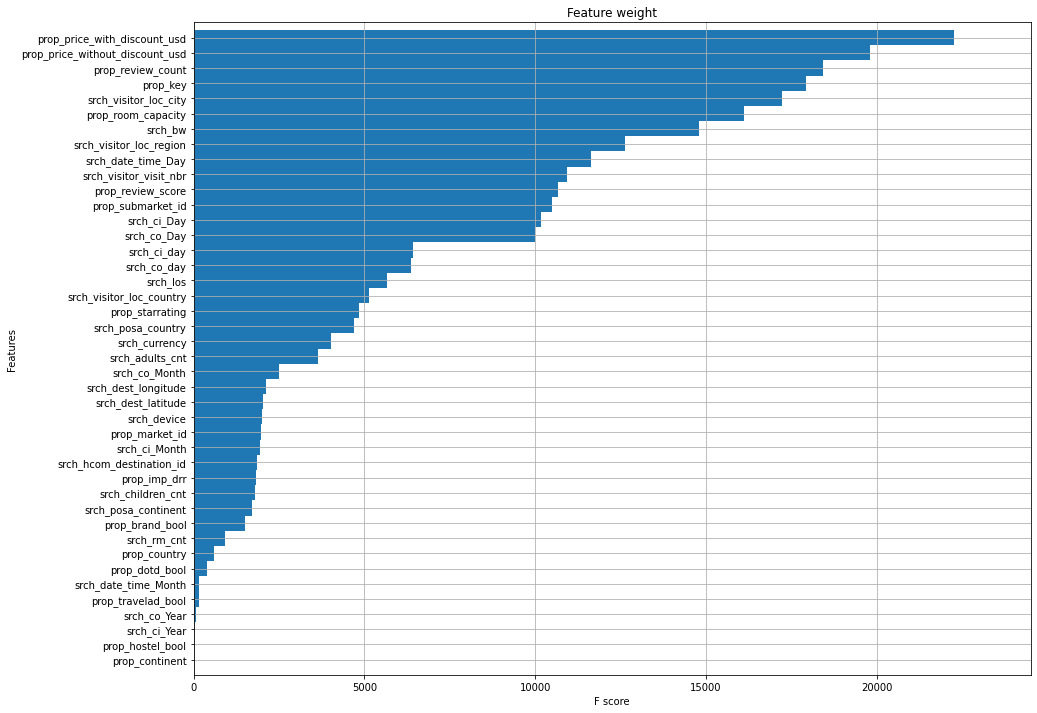

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(15,12))
xgb.plot_importance(
    booster=opt_model, 
    importance_type='weight',
    title='Feature weight',
    show_values=False,
    height=1,
    ax = ax
)

According to the chart above, `prop_price_with_disctount_usd`, `prop_price_without_disctount_usd`,`prop_review_cout` are the top 3 important features for the ranking task. 

In [50]:
shap.initjs()
X_sampled = X_train.sample(3000, random_state=10)
explainer = shap.TreeExplainer(opt_model)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [51]:
# # visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

The chart above is the shape value (-2.07) of the first sample, the value is much more smaller than base value (0.5333,the average model output over the training dataset we passed).  The above explanation shows features' contributions to push the model output from the base value. If there were any features pushing the class label higher they would be shown in red, otherwise they would be shown in blue.

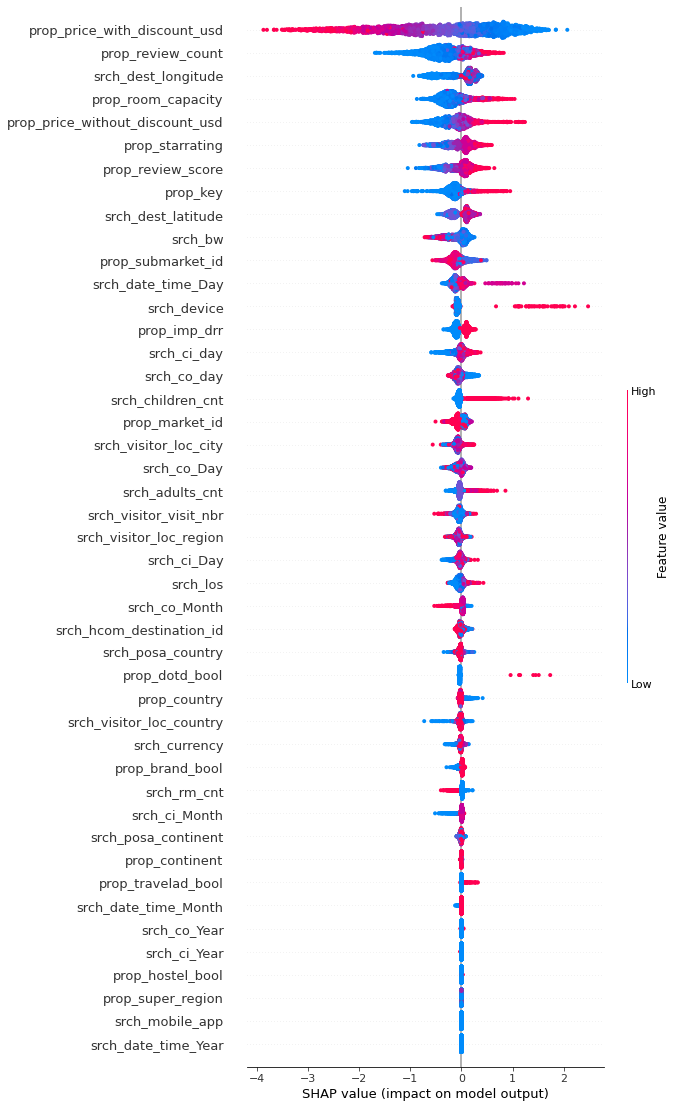

In [52]:
shap.summary_plot(shap_values, X_sampled,max_display=45)

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

According to the results of two method, `prop_price_with_discount_usd` and `prop_review_count` are the most important features for this ranking task. And `srch_date_time_Year`,`prop_hostel_bool`,`prop_super_region` features provide least contribution for the task. 

### Prediction

In [53]:
# def predict(model, df):
#     return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])

# pred = (test_clean.groupby('srch_id')
# for srch_id in pred1.index:
#     serch_pred = pred1[srch_id]
#     test_clean.loc[test_clean['srch_id']==srch_id,'predict']=serch_pred

In [54]:
# Prediction 
test_clean = features.loc[len(train):,:]
test_tmp = test_clean.drop('srch_id',axis=1)
pred = opt_model.predict(test_tmp)
test_clean['pred'] = pred
results = test_clean[['srch_id', 'prop_key', 'pred']]
results_to_csv = results.sort_values(['srch_id'], ascending=True).groupby(['srch_id'], sort=False).apply(lambda x: x.sort_values(['pred'], ascending=False)).reset_index(drop=True)

In [55]:
# Output the prediction
submissions = results_to_csv[["srch_id", "prop_key"]]
submissions.to_csv("./submission.csv", index=False)

### Final result: 
Score: 0.49221   
Ranking: 29